# Generative Adversarial Networks
# FEEC/Unicamp - July/2020
## Based on https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=1000)

Using TensorFlow backend.
W0715 16:24:31.266355 18828 deprecation.py:323] From D:\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

W0715 16:24:41.815015 18828 deprecation_wrapper.py:119] From D:\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

D:\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.993025, acc.: 39.06%] [G loss: 1.130126]


D:\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.399041, acc.: 96.88%] [G loss: 1.045447]
2 [D loss: 0.301083, acc.: 95.31%] [G loss: 1.137315]
3 [D loss: 0.304700, acc.: 92.19%] [G loss: 1.111958]
4 [D loss: 0.270199, acc.: 98.44%] [G loss: 1.173562]
5 [D loss: 0.237722, acc.: 100.00%] [G loss: 1.329052]
6 [D loss: 0.193639, acc.: 98.44%] [G loss: 1.475987]
7 [D loss: 0.174017, acc.: 100.00%] [G loss: 1.631826]
8 [D loss: 0.147093, acc.: 100.00%] [G loss: 1.748543]
9 [D loss: 0.127230, acc.: 100.00%] [G loss: 1.832329]
10 [D loss: 0.110290, acc.: 100.00%] [G loss: 2.056335]
11 [D loss: 0.084048, acc.: 100.00%] [G loss: 2.110154]
12 [D loss: 0.084020, acc.: 100.00%] [G loss: 2.148685]
13 [D loss: 0.072817, acc.: 100.00%] [G loss: 2.248858]
14 [D loss: 0.079950, acc.: 100.00%] [G loss: 2.398517]
15 [D loss: 0.063510, acc.: 100.00%] [G loss: 2.399781]
16 [D loss: 0.062510, acc.: 100.00%] [G loss: 2.593715]
17 [D loss: 0.051561, acc.: 100.00%] [G loss: 2.671758]
18 [D loss: 0.051463, acc.: 100.00%] [G loss: 2.755450]
19 [D 

157 [D loss: 0.279758, acc.: 82.81%] [G loss: 4.130889]
158 [D loss: 0.022552, acc.: 100.00%] [G loss: 5.078010]
159 [D loss: 0.470097, acc.: 78.12%] [G loss: 2.769662]
160 [D loss: 0.263045, acc.: 87.50%] [G loss: 3.715500]
161 [D loss: 0.095902, acc.: 95.31%] [G loss: 5.003577]
162 [D loss: 0.415996, acc.: 79.69%] [G loss: 2.814348]
163 [D loss: 0.126845, acc.: 95.31%] [G loss: 3.743405]
164 [D loss: 0.088814, acc.: 100.00%] [G loss: 4.533708]
165 [D loss: 0.182663, acc.: 96.88%] [G loss: 3.679534]
166 [D loss: 0.066983, acc.: 98.44%] [G loss: 3.863770]
167 [D loss: 0.121168, acc.: 93.75%] [G loss: 3.571606]
168 [D loss: 0.103812, acc.: 98.44%] [G loss: 3.286696]
169 [D loss: 0.158205, acc.: 95.31%] [G loss: 4.414686]
170 [D loss: 0.925501, acc.: 60.94%] [G loss: 1.591354]
171 [D loss: 0.490011, acc.: 71.88%] [G loss: 2.491064]
172 [D loss: 0.149084, acc.: 96.88%] [G loss: 4.251056]
173 [D loss: 0.157956, acc.: 95.31%] [G loss: 4.521283]
174 [D loss: 0.147089, acc.: 96.88%] [G loss: 

315 [D loss: 0.699922, acc.: 48.44%] [G loss: 0.710329]
316 [D loss: 0.654251, acc.: 45.31%] [G loss: 0.716767]
317 [D loss: 0.695531, acc.: 50.00%] [G loss: 0.717105]
318 [D loss: 0.693865, acc.: 37.50%] [G loss: 0.687652]
319 [D loss: 0.664828, acc.: 48.44%] [G loss: 0.676525]
320 [D loss: 0.664221, acc.: 48.44%] [G loss: 0.669695]
321 [D loss: 0.680710, acc.: 48.44%] [G loss: 0.665217]
322 [D loss: 0.684184, acc.: 46.88%] [G loss: 0.684736]
323 [D loss: 0.665004, acc.: 50.00%] [G loss: 0.687897]
324 [D loss: 0.645155, acc.: 54.69%] [G loss: 0.663460]
325 [D loss: 0.692643, acc.: 46.88%] [G loss: 0.663819]
326 [D loss: 0.665111, acc.: 46.88%] [G loss: 0.683346]
327 [D loss: 0.675947, acc.: 51.56%] [G loss: 0.712302]
328 [D loss: 0.651848, acc.: 50.00%] [G loss: 0.719231]
329 [D loss: 0.625785, acc.: 57.81%] [G loss: 0.712137]
330 [D loss: 0.667620, acc.: 51.56%] [G loss: 0.686432]
331 [D loss: 0.663915, acc.: 51.56%] [G loss: 0.691000]
332 [D loss: 0.642097, acc.: 60.94%] [G loss: 0.

463 [D loss: 0.630682, acc.: 59.38%] [G loss: 0.785681]
464 [D loss: 0.613991, acc.: 62.50%] [G loss: 0.755577]
465 [D loss: 0.624298, acc.: 62.50%] [G loss: 0.764761]
466 [D loss: 0.635706, acc.: 59.38%] [G loss: 0.771584]
467 [D loss: 0.658346, acc.: 59.38%] [G loss: 0.769560]
468 [D loss: 0.650973, acc.: 54.69%] [G loss: 0.753776]
469 [D loss: 0.676268, acc.: 51.56%] [G loss: 0.760304]
470 [D loss: 0.664009, acc.: 56.25%] [G loss: 0.742803]
471 [D loss: 0.646186, acc.: 54.69%] [G loss: 0.713665]
472 [D loss: 0.648837, acc.: 56.25%] [G loss: 0.701046]
473 [D loss: 0.635167, acc.: 51.56%] [G loss: 0.728345]
474 [D loss: 0.611977, acc.: 65.62%] [G loss: 0.750343]
475 [D loss: 0.668694, acc.: 48.44%] [G loss: 0.724474]
476 [D loss: 0.631554, acc.: 53.12%] [G loss: 0.754715]
477 [D loss: 0.671195, acc.: 50.00%] [G loss: 0.734086]
478 [D loss: 0.636666, acc.: 64.06%] [G loss: 0.738880]
479 [D loss: 0.662035, acc.: 51.56%] [G loss: 0.735761]
480 [D loss: 0.642884, acc.: 50.00%] [G loss: 0.

614 [D loss: 0.653721, acc.: 56.25%] [G loss: 0.756674]
615 [D loss: 0.650071, acc.: 60.94%] [G loss: 0.726581]
616 [D loss: 0.627951, acc.: 65.62%] [G loss: 0.732194]
617 [D loss: 0.659637, acc.: 59.38%] [G loss: 0.759906]
618 [D loss: 0.649157, acc.: 64.06%] [G loss: 0.731877]
619 [D loss: 0.638693, acc.: 71.88%] [G loss: 0.745932]
620 [D loss: 0.636118, acc.: 62.50%] [G loss: 0.743963]
621 [D loss: 0.627452, acc.: 65.62%] [G loss: 0.717271]
622 [D loss: 0.600511, acc.: 71.88%] [G loss: 0.758241]
623 [D loss: 0.651258, acc.: 62.50%] [G loss: 0.768279]
624 [D loss: 0.618150, acc.: 76.56%] [G loss: 0.781606]
625 [D loss: 0.655911, acc.: 54.69%] [G loss: 0.765668]
626 [D loss: 0.638572, acc.: 54.69%] [G loss: 0.786393]
627 [D loss: 0.640570, acc.: 62.50%] [G loss: 0.782269]
628 [D loss: 0.688289, acc.: 50.00%] [G loss: 0.787934]
629 [D loss: 0.644816, acc.: 60.94%] [G loss: 0.744537]
630 [D loss: 0.638807, acc.: 59.38%] [G loss: 0.755027]
631 [D loss: 0.662604, acc.: 62.50%] [G loss: 0.

763 [D loss: 0.648268, acc.: 56.25%] [G loss: 0.786359]
764 [D loss: 0.611907, acc.: 67.19%] [G loss: 0.781545]
765 [D loss: 0.637918, acc.: 64.06%] [G loss: 0.787690]
766 [D loss: 0.624801, acc.: 60.94%] [G loss: 0.814762]
767 [D loss: 0.635007, acc.: 67.19%] [G loss: 0.806004]
768 [D loss: 0.656820, acc.: 59.38%] [G loss: 0.760935]
769 [D loss: 0.622096, acc.: 67.19%] [G loss: 0.754548]
770 [D loss: 0.610608, acc.: 76.56%] [G loss: 0.792610]
771 [D loss: 0.619018, acc.: 67.19%] [G loss: 0.802244]
772 [D loss: 0.644394, acc.: 59.38%] [G loss: 0.766273]
773 [D loss: 0.599178, acc.: 78.12%] [G loss: 0.790285]
774 [D loss: 0.636599, acc.: 65.62%] [G loss: 0.777534]
775 [D loss: 0.583037, acc.: 75.00%] [G loss: 0.787185]
776 [D loss: 0.600934, acc.: 75.00%] [G loss: 0.790881]
777 [D loss: 0.637473, acc.: 71.88%] [G loss: 0.799198]
778 [D loss: 0.629232, acc.: 71.88%] [G loss: 0.768183]
779 [D loss: 0.579300, acc.: 71.88%] [G loss: 0.820514]
780 [D loss: 0.613891, acc.: 67.19%] [G loss: 0.

913 [D loss: 0.634433, acc.: 67.19%] [G loss: 0.840448]
914 [D loss: 0.610543, acc.: 67.19%] [G loss: 0.855578]
915 [D loss: 0.603290, acc.: 76.56%] [G loss: 0.803628]
916 [D loss: 0.620686, acc.: 70.31%] [G loss: 0.804229]
917 [D loss: 0.600013, acc.: 70.31%] [G loss: 0.801409]
918 [D loss: 0.680624, acc.: 56.25%] [G loss: 0.819625]
919 [D loss: 0.633033, acc.: 67.19%] [G loss: 0.825138]
920 [D loss: 0.595414, acc.: 75.00%] [G loss: 0.841007]
921 [D loss: 0.592033, acc.: 81.25%] [G loss: 0.807254]
922 [D loss: 0.652553, acc.: 60.94%] [G loss: 0.796624]
923 [D loss: 0.662284, acc.: 59.38%] [G loss: 0.799530]
924 [D loss: 0.640975, acc.: 59.38%] [G loss: 0.801635]
925 [D loss: 0.604910, acc.: 70.31%] [G loss: 0.810306]
926 [D loss: 0.636715, acc.: 65.62%] [G loss: 0.836569]
927 [D loss: 0.633323, acc.: 71.88%] [G loss: 0.874700]
928 [D loss: 0.621638, acc.: 70.31%] [G loss: 0.798067]
929 [D loss: 0.628595, acc.: 73.44%] [G loss: 0.831464]
930 [D loss: 0.613232, acc.: 73.44%] [G loss: 0.

1064 [D loss: 0.604561, acc.: 78.12%] [G loss: 0.929371]
1065 [D loss: 0.578494, acc.: 78.12%] [G loss: 0.826457]
1066 [D loss: 0.562500, acc.: 76.56%] [G loss: 0.837184]
1067 [D loss: 0.548183, acc.: 75.00%] [G loss: 0.870276]
1068 [D loss: 0.629427, acc.: 64.06%] [G loss: 0.874417]
1069 [D loss: 0.595834, acc.: 75.00%] [G loss: 0.858787]
1070 [D loss: 0.543170, acc.: 76.56%] [G loss: 0.874067]
1071 [D loss: 0.586369, acc.: 70.31%] [G loss: 0.884873]
1072 [D loss: 0.581713, acc.: 78.12%] [G loss: 0.925080]
1073 [D loss: 0.620415, acc.: 68.75%] [G loss: 0.856952]
1074 [D loss: 0.530098, acc.: 81.25%] [G loss: 0.949708]
1075 [D loss: 0.609582, acc.: 67.19%] [G loss: 0.892998]
1076 [D loss: 0.604569, acc.: 70.31%] [G loss: 0.886576]
1077 [D loss: 0.622621, acc.: 67.19%] [G loss: 0.819272]
1078 [D loss: 0.651026, acc.: 57.81%] [G loss: 0.849243]
1079 [D loss: 0.578765, acc.: 84.38%] [G loss: 0.890108]
1080 [D loss: 0.624007, acc.: 65.62%] [G loss: 0.858534]
1081 [D loss: 0.555838, acc.: 7

1210 [D loss: 0.611208, acc.: 64.06%] [G loss: 0.940798]
1211 [D loss: 0.566142, acc.: 76.56%] [G loss: 0.882753]
1212 [D loss: 0.577866, acc.: 79.69%] [G loss: 0.831044]
1213 [D loss: 0.539787, acc.: 75.00%] [G loss: 0.883136]
1214 [D loss: 0.623766, acc.: 70.31%] [G loss: 0.908026]
1215 [D loss: 0.575489, acc.: 75.00%] [G loss: 0.937262]
1216 [D loss: 0.556711, acc.: 79.69%] [G loss: 0.957250]
1217 [D loss: 0.625983, acc.: 67.19%] [G loss: 0.956011]
1218 [D loss: 0.594420, acc.: 71.88%] [G loss: 0.869854]
1219 [D loss: 0.538919, acc.: 82.81%] [G loss: 0.844576]
1220 [D loss: 0.599659, acc.: 70.31%] [G loss: 0.942583]
1221 [D loss: 0.572939, acc.: 73.44%] [G loss: 0.899722]
1222 [D loss: 0.621059, acc.: 65.62%] [G loss: 0.951897]
1223 [D loss: 0.586931, acc.: 67.19%] [G loss: 0.969700]
1224 [D loss: 0.586291, acc.: 68.75%] [G loss: 0.968523]
1225 [D loss: 0.581333, acc.: 78.12%] [G loss: 0.904644]
1226 [D loss: 0.597742, acc.: 70.31%] [G loss: 0.918944]
1227 [D loss: 0.540359, acc.: 7

1359 [D loss: 0.531986, acc.: 75.00%] [G loss: 0.961530]
1360 [D loss: 0.595264, acc.: 67.19%] [G loss: 0.957713]
1361 [D loss: 0.592293, acc.: 67.19%] [G loss: 0.950457]
1362 [D loss: 0.528105, acc.: 79.69%] [G loss: 0.999000]
1363 [D loss: 0.553552, acc.: 78.12%] [G loss: 0.963861]
1364 [D loss: 0.577316, acc.: 71.88%] [G loss: 0.885897]
1365 [D loss: 0.564237, acc.: 76.56%] [G loss: 0.914735]
1366 [D loss: 0.573919, acc.: 68.75%] [G loss: 0.992103]
1367 [D loss: 0.592558, acc.: 67.19%] [G loss: 0.969775]
1368 [D loss: 0.551015, acc.: 75.00%] [G loss: 0.994221]
1369 [D loss: 0.630336, acc.: 59.38%] [G loss: 0.948643]
1370 [D loss: 0.597387, acc.: 73.44%] [G loss: 0.936790]
1371 [D loss: 0.530665, acc.: 84.38%] [G loss: 1.029913]
1372 [D loss: 0.597795, acc.: 76.56%] [G loss: 0.949255]
1373 [D loss: 0.601517, acc.: 67.19%] [G loss: 0.998273]
1374 [D loss: 0.556069, acc.: 68.75%] [G loss: 0.910596]
1375 [D loss: 0.525882, acc.: 87.50%] [G loss: 0.895448]
1376 [D loss: 0.575827, acc.: 7

1510 [D loss: 0.513980, acc.: 79.69%] [G loss: 0.952744]
1511 [D loss: 0.585194, acc.: 75.00%] [G loss: 0.992022]
1512 [D loss: 0.594308, acc.: 73.44%] [G loss: 0.924842]
1513 [D loss: 0.571937, acc.: 73.44%] [G loss: 0.893115]
1514 [D loss: 0.531700, acc.: 78.12%] [G loss: 0.959136]
1515 [D loss: 0.515774, acc.: 81.25%] [G loss: 0.990224]
1516 [D loss: 0.538348, acc.: 71.88%] [G loss: 0.911764]
1517 [D loss: 0.539189, acc.: 79.69%] [G loss: 0.959628]
1518 [D loss: 0.539513, acc.: 71.88%] [G loss: 1.011673]
1519 [D loss: 0.590363, acc.: 73.44%] [G loss: 0.943388]
1520 [D loss: 0.643832, acc.: 59.38%] [G loss: 1.032509]
1521 [D loss: 0.584897, acc.: 67.19%] [G loss: 1.021415]
1522 [D loss: 0.540517, acc.: 76.56%] [G loss: 0.983446]
1523 [D loss: 0.633986, acc.: 73.44%] [G loss: 1.021104]
1524 [D loss: 0.597856, acc.: 67.19%] [G loss: 1.000841]
1525 [D loss: 0.564974, acc.: 79.69%] [G loss: 0.954965]
1526 [D loss: 0.580483, acc.: 75.00%] [G loss: 0.997052]
1527 [D loss: 0.605137, acc.: 5

1660 [D loss: 0.563348, acc.: 75.00%] [G loss: 0.964792]
1661 [D loss: 0.524861, acc.: 75.00%] [G loss: 0.962268]
1662 [D loss: 0.588511, acc.: 70.31%] [G loss: 1.015568]
1663 [D loss: 0.558821, acc.: 70.31%] [G loss: 0.998674]
1664 [D loss: 0.605952, acc.: 68.75%] [G loss: 1.062670]
1665 [D loss: 0.624522, acc.: 68.75%] [G loss: 0.950912]
1666 [D loss: 0.504235, acc.: 82.81%] [G loss: 0.971878]
1667 [D loss: 0.551306, acc.: 76.56%] [G loss: 1.022038]
1668 [D loss: 0.648416, acc.: 62.50%] [G loss: 0.953590]
1669 [D loss: 0.589505, acc.: 70.31%] [G loss: 0.902457]
1670 [D loss: 0.540513, acc.: 78.12%] [G loss: 0.959707]
1671 [D loss: 0.530948, acc.: 75.00%] [G loss: 1.020959]
1672 [D loss: 0.610195, acc.: 67.19%] [G loss: 0.952365]
1673 [D loss: 0.534569, acc.: 75.00%] [G loss: 0.967141]
1674 [D loss: 0.612442, acc.: 64.06%] [G loss: 0.941552]
1675 [D loss: 0.529644, acc.: 79.69%] [G loss: 0.922503]
1676 [D loss: 0.588553, acc.: 70.31%] [G loss: 0.938921]
1677 [D loss: 0.498999, acc.: 7

1813 [D loss: 0.535905, acc.: 79.69%] [G loss: 1.005772]
1814 [D loss: 0.580235, acc.: 70.31%] [G loss: 0.925436]
1815 [D loss: 0.572047, acc.: 70.31%] [G loss: 0.961197]
1816 [D loss: 0.555879, acc.: 73.44%] [G loss: 1.013207]
1817 [D loss: 0.544106, acc.: 76.56%] [G loss: 0.995105]
1818 [D loss: 0.579972, acc.: 70.31%] [G loss: 1.036305]
1819 [D loss: 0.587957, acc.: 70.31%] [G loss: 1.053773]
1820 [D loss: 0.624771, acc.: 65.62%] [G loss: 1.075067]
1821 [D loss: 0.522456, acc.: 76.56%] [G loss: 1.030437]
1822 [D loss: 0.599116, acc.: 76.56%] [G loss: 1.071544]
1823 [D loss: 0.597553, acc.: 70.31%] [G loss: 1.016673]
1824 [D loss: 0.538851, acc.: 71.88%] [G loss: 0.990753]
1825 [D loss: 0.567163, acc.: 73.44%] [G loss: 0.941030]
1826 [D loss: 0.552318, acc.: 71.88%] [G loss: 0.998952]
1827 [D loss: 0.567000, acc.: 78.12%] [G loss: 0.983979]
1828 [D loss: 0.564933, acc.: 64.06%] [G loss: 0.904558]
1829 [D loss: 0.614445, acc.: 65.62%] [G loss: 1.042412]
1830 [D loss: 0.557590, acc.: 7

1956 [D loss: 0.594445, acc.: 64.06%] [G loss: 1.052856]
1957 [D loss: 0.587597, acc.: 73.44%] [G loss: 0.964929]
1958 [D loss: 0.600686, acc.: 65.62%] [G loss: 1.008233]
1959 [D loss: 0.589810, acc.: 60.94%] [G loss: 1.028744]
1960 [D loss: 0.596596, acc.: 68.75%] [G loss: 0.928743]
1961 [D loss: 0.583650, acc.: 70.31%] [G loss: 1.027709]
1962 [D loss: 0.560607, acc.: 75.00%] [G loss: 0.963860]
1963 [D loss: 0.595348, acc.: 70.31%] [G loss: 0.947144]
1964 [D loss: 0.568576, acc.: 70.31%] [G loss: 0.919982]
1965 [D loss: 0.570274, acc.: 75.00%] [G loss: 1.013552]
1966 [D loss: 0.580473, acc.: 67.19%] [G loss: 0.954973]
1967 [D loss: 0.572379, acc.: 73.44%] [G loss: 0.969012]
1968 [D loss: 0.572512, acc.: 73.44%] [G loss: 0.982219]
1969 [D loss: 0.650265, acc.: 64.06%] [G loss: 0.941849]
1970 [D loss: 0.565572, acc.: 73.44%] [G loss: 0.929518]
1971 [D loss: 0.582138, acc.: 68.75%] [G loss: 0.936258]
1972 [D loss: 0.638070, acc.: 64.06%] [G loss: 0.945252]
1973 [D loss: 0.533113, acc.: 7

2100 [D loss: 0.608690, acc.: 67.19%] [G loss: 0.952857]
2101 [D loss: 0.560539, acc.: 78.12%] [G loss: 0.949485]
2102 [D loss: 0.610203, acc.: 68.75%] [G loss: 0.984621]
2103 [D loss: 0.610530, acc.: 67.19%] [G loss: 1.114735]
2104 [D loss: 0.649358, acc.: 56.25%] [G loss: 0.932646]
2105 [D loss: 0.503875, acc.: 82.81%] [G loss: 1.028275]
2106 [D loss: 0.545424, acc.: 73.44%] [G loss: 1.000158]
2107 [D loss: 0.608523, acc.: 65.62%] [G loss: 1.029775]
2108 [D loss: 0.567332, acc.: 75.00%] [G loss: 0.989063]
2109 [D loss: 0.642937, acc.: 64.06%] [G loss: 0.885296]
2110 [D loss: 0.574652, acc.: 70.31%] [G loss: 0.923752]
2111 [D loss: 0.575819, acc.: 71.88%] [G loss: 0.985526]
2112 [D loss: 0.583690, acc.: 71.88%] [G loss: 0.955520]
2113 [D loss: 0.496986, acc.: 90.62%] [G loss: 1.040859]
2114 [D loss: 0.634338, acc.: 60.94%] [G loss: 0.925245]
2115 [D loss: 0.572057, acc.: 71.88%] [G loss: 0.919062]
2116 [D loss: 0.625383, acc.: 60.94%] [G loss: 1.043396]
2117 [D loss: 0.571453, acc.: 7

2247 [D loss: 0.585053, acc.: 76.56%] [G loss: 1.006186]
2248 [D loss: 0.525847, acc.: 76.56%] [G loss: 0.956514]
2249 [D loss: 0.510672, acc.: 85.94%] [G loss: 1.022701]
2250 [D loss: 0.627697, acc.: 62.50%] [G loss: 0.976619]
2251 [D loss: 0.642969, acc.: 62.50%] [G loss: 0.928535]
2252 [D loss: 0.614812, acc.: 67.19%] [G loss: 0.999728]
2253 [D loss: 0.555003, acc.: 71.88%] [G loss: 0.924096]
2254 [D loss: 0.617186, acc.: 60.94%] [G loss: 1.050939]
2255 [D loss: 0.538597, acc.: 75.00%] [G loss: 0.933386]
2256 [D loss: 0.572634, acc.: 73.44%] [G loss: 0.998943]
2257 [D loss: 0.603283, acc.: 64.06%] [G loss: 1.090846]
2258 [D loss: 0.555278, acc.: 71.88%] [G loss: 0.983001]
2259 [D loss: 0.592625, acc.: 67.19%] [G loss: 0.946738]
2260 [D loss: 0.555699, acc.: 75.00%] [G loss: 1.097053]
2261 [D loss: 0.649858, acc.: 60.94%] [G loss: 0.891343]
2262 [D loss: 0.623752, acc.: 68.75%] [G loss: 0.876656]
2263 [D loss: 0.523904, acc.: 78.12%] [G loss: 0.912060]
2264 [D loss: 0.593847, acc.: 6

2395 [D loss: 0.582395, acc.: 78.12%] [G loss: 1.045371]
2396 [D loss: 0.628450, acc.: 64.06%] [G loss: 0.955670]
2397 [D loss: 0.594022, acc.: 71.88%] [G loss: 0.889758]
2398 [D loss: 0.502172, acc.: 76.56%] [G loss: 1.082816]
2399 [D loss: 0.537418, acc.: 78.12%] [G loss: 1.071250]
2400 [D loss: 0.562823, acc.: 75.00%] [G loss: 0.993666]
2401 [D loss: 0.602779, acc.: 68.75%] [G loss: 1.024963]
2402 [D loss: 0.551767, acc.: 73.44%] [G loss: 0.973008]
2403 [D loss: 0.556457, acc.: 70.31%] [G loss: 1.001901]
2404 [D loss: 0.577191, acc.: 70.31%] [G loss: 0.953506]
2405 [D loss: 0.595875, acc.: 64.06%] [G loss: 1.040189]
2406 [D loss: 0.611613, acc.: 65.62%] [G loss: 1.026795]
2407 [D loss: 0.535121, acc.: 79.69%] [G loss: 1.050787]
2408 [D loss: 0.610333, acc.: 64.06%] [G loss: 1.011196]
2409 [D loss: 0.580792, acc.: 70.31%] [G loss: 1.026506]
2410 [D loss: 0.633165, acc.: 62.50%] [G loss: 1.010112]
2411 [D loss: 0.533198, acc.: 75.00%] [G loss: 0.936355]
2412 [D loss: 0.657344, acc.: 6

2549 [D loss: 0.607919, acc.: 71.88%] [G loss: 1.084628]
2550 [D loss: 0.599779, acc.: 62.50%] [G loss: 0.974617]
2551 [D loss: 0.507065, acc.: 78.12%] [G loss: 0.974866]
2552 [D loss: 0.605469, acc.: 68.75%] [G loss: 0.999039]
2553 [D loss: 0.578577, acc.: 70.31%] [G loss: 0.951961]
2554 [D loss: 0.497350, acc.: 81.25%] [G loss: 0.971372]
2555 [D loss: 0.624339, acc.: 68.75%] [G loss: 0.944025]
2556 [D loss: 0.615080, acc.: 65.62%] [G loss: 0.990866]
2557 [D loss: 0.643164, acc.: 65.62%] [G loss: 1.013075]
2558 [D loss: 0.586621, acc.: 76.56%] [G loss: 0.969932]
2559 [D loss: 0.580781, acc.: 73.44%] [G loss: 1.117816]
2560 [D loss: 0.582212, acc.: 70.31%] [G loss: 0.942670]
2561 [D loss: 0.588478, acc.: 67.19%] [G loss: 0.999176]
2562 [D loss: 0.573610, acc.: 71.88%] [G loss: 1.016415]
2563 [D loss: 0.571229, acc.: 75.00%] [G loss: 0.992846]
2564 [D loss: 0.544350, acc.: 78.12%] [G loss: 0.992406]
2565 [D loss: 0.601956, acc.: 68.75%] [G loss: 1.015367]
2566 [D loss: 0.544189, acc.: 7

2701 [D loss: 0.517150, acc.: 78.12%] [G loss: 1.100281]
2702 [D loss: 0.575852, acc.: 73.44%] [G loss: 1.037693]
2703 [D loss: 0.606876, acc.: 70.31%] [G loss: 0.986069]
2704 [D loss: 0.606117, acc.: 67.19%] [G loss: 1.018449]
2705 [D loss: 0.615551, acc.: 68.75%] [G loss: 1.039257]
2706 [D loss: 0.630660, acc.: 65.62%] [G loss: 1.033318]
2707 [D loss: 0.569972, acc.: 70.31%] [G loss: 0.951981]
2708 [D loss: 0.527980, acc.: 75.00%] [G loss: 0.977165]
2709 [D loss: 0.607670, acc.: 64.06%] [G loss: 0.922566]
2710 [D loss: 0.560030, acc.: 70.31%] [G loss: 0.894168]
2711 [D loss: 0.563029, acc.: 73.44%] [G loss: 0.913873]
2712 [D loss: 0.628118, acc.: 65.62%] [G loss: 0.989203]
2713 [D loss: 0.515985, acc.: 81.25%] [G loss: 0.895420]
2714 [D loss: 0.567920, acc.: 68.75%] [G loss: 1.003568]
2715 [D loss: 0.562808, acc.: 75.00%] [G loss: 0.978376]
2716 [D loss: 0.539163, acc.: 75.00%] [G loss: 0.936310]
2717 [D loss: 0.562979, acc.: 68.75%] [G loss: 0.883689]
2718 [D loss: 0.555460, acc.: 7

2854 [D loss: 0.582163, acc.: 70.31%] [G loss: 0.899296]
2855 [D loss: 0.625544, acc.: 62.50%] [G loss: 0.975439]
2856 [D loss: 0.540625, acc.: 75.00%] [G loss: 1.019188]
2857 [D loss: 0.539552, acc.: 78.12%] [G loss: 1.042962]
2858 [D loss: 0.598139, acc.: 68.75%] [G loss: 1.029285]
2859 [D loss: 0.540309, acc.: 78.12%] [G loss: 1.008237]
2860 [D loss: 0.631173, acc.: 65.62%] [G loss: 0.892857]
2861 [D loss: 0.551590, acc.: 76.56%] [G loss: 0.914381]
2862 [D loss: 0.608729, acc.: 67.19%] [G loss: 0.944363]
2863 [D loss: 0.667027, acc.: 57.81%] [G loss: 1.006365]
2864 [D loss: 0.601812, acc.: 71.88%] [G loss: 1.058029]
2865 [D loss: 0.547481, acc.: 75.00%] [G loss: 1.002804]
2866 [D loss: 0.542086, acc.: 71.88%] [G loss: 1.006685]
2867 [D loss: 0.642619, acc.: 68.75%] [G loss: 0.978364]
2868 [D loss: 0.585515, acc.: 67.19%] [G loss: 0.964231]
2869 [D loss: 0.576990, acc.: 65.62%] [G loss: 0.997599]
2870 [D loss: 0.586821, acc.: 76.56%] [G loss: 1.107848]
2871 [D loss: 0.575814, acc.: 7

3001 [D loss: 0.554659, acc.: 71.88%] [G loss: 1.002082]
3002 [D loss: 0.519919, acc.: 76.56%] [G loss: 1.094071]
3003 [D loss: 0.547220, acc.: 70.31%] [G loss: 0.987581]
3004 [D loss: 0.559968, acc.: 70.31%] [G loss: 1.004997]
3005 [D loss: 0.602188, acc.: 70.31%] [G loss: 0.983590]
3006 [D loss: 0.560144, acc.: 64.06%] [G loss: 1.081990]
3007 [D loss: 0.562869, acc.: 67.19%] [G loss: 0.963585]
3008 [D loss: 0.540882, acc.: 81.25%] [G loss: 0.992221]
3009 [D loss: 0.643767, acc.: 59.38%] [G loss: 0.921950]
3010 [D loss: 0.508782, acc.: 76.56%] [G loss: 0.847901]
3011 [D loss: 0.625688, acc.: 67.19%] [G loss: 1.037579]
3012 [D loss: 0.506262, acc.: 76.56%] [G loss: 0.989164]
3013 [D loss: 0.502366, acc.: 81.25%] [G loss: 1.060907]
3014 [D loss: 0.552792, acc.: 73.44%] [G loss: 1.127080]
3015 [D loss: 0.614079, acc.: 62.50%] [G loss: 0.985777]
3016 [D loss: 0.480587, acc.: 84.38%] [G loss: 1.096703]
3017 [D loss: 0.601889, acc.: 65.62%] [G loss: 0.953130]
3018 [D loss: 0.654858, acc.: 6

3151 [D loss: 0.679932, acc.: 56.25%] [G loss: 0.967492]
3152 [D loss: 0.524213, acc.: 75.00%] [G loss: 1.055378]
3153 [D loss: 0.625227, acc.: 68.75%] [G loss: 1.007676]
3154 [D loss: 0.576987, acc.: 70.31%] [G loss: 1.089813]
3155 [D loss: 0.605948, acc.: 70.31%] [G loss: 1.020413]
3156 [D loss: 0.604590, acc.: 68.75%] [G loss: 1.054670]
3157 [D loss: 0.669127, acc.: 57.81%] [G loss: 0.977564]
3158 [D loss: 0.588809, acc.: 62.50%] [G loss: 1.138931]
3159 [D loss: 0.662311, acc.: 60.94%] [G loss: 1.003738]
3160 [D loss: 0.590059, acc.: 68.75%] [G loss: 1.012515]
3161 [D loss: 0.564590, acc.: 73.44%] [G loss: 0.934664]
3162 [D loss: 0.570386, acc.: 71.88%] [G loss: 1.051721]
3163 [D loss: 0.602918, acc.: 67.19%] [G loss: 0.931475]
3164 [D loss: 0.584747, acc.: 71.88%] [G loss: 0.924873]
3165 [D loss: 0.558055, acc.: 76.56%] [G loss: 0.971420]
3166 [D loss: 0.568916, acc.: 70.31%] [G loss: 0.960639]
3167 [D loss: 0.569238, acc.: 75.00%] [G loss: 0.984297]
3168 [D loss: 0.609277, acc.: 6

3299 [D loss: 0.622606, acc.: 60.94%] [G loss: 1.013873]
3300 [D loss: 0.593593, acc.: 70.31%] [G loss: 0.920657]
3301 [D loss: 0.535044, acc.: 76.56%] [G loss: 0.946561]
3302 [D loss: 0.496476, acc.: 75.00%] [G loss: 1.094785]
3303 [D loss: 0.590618, acc.: 62.50%] [G loss: 1.084983]
3304 [D loss: 0.624217, acc.: 64.06%] [G loss: 1.037197]
3305 [D loss: 0.622028, acc.: 60.94%] [G loss: 1.012034]
3306 [D loss: 0.521030, acc.: 75.00%] [G loss: 0.990615]
3307 [D loss: 0.643958, acc.: 62.50%] [G loss: 1.006098]
3308 [D loss: 0.525721, acc.: 75.00%] [G loss: 1.040983]
3309 [D loss: 0.674803, acc.: 65.62%] [G loss: 1.013263]
3310 [D loss: 0.555049, acc.: 76.56%] [G loss: 1.022689]
3311 [D loss: 0.638495, acc.: 67.19%] [G loss: 0.940056]
3312 [D loss: 0.583528, acc.: 71.88%] [G loss: 0.967855]
3313 [D loss: 0.601642, acc.: 64.06%] [G loss: 1.139366]
3314 [D loss: 0.564632, acc.: 79.69%] [G loss: 1.001689]
3315 [D loss: 0.560194, acc.: 73.44%] [G loss: 0.924254]
3316 [D loss: 0.583198, acc.: 7

3445 [D loss: 0.592554, acc.: 73.44%] [G loss: 0.989772]
3446 [D loss: 0.640924, acc.: 65.62%] [G loss: 0.981323]
3447 [D loss: 0.660450, acc.: 60.94%] [G loss: 0.983459]
3448 [D loss: 0.583976, acc.: 64.06%] [G loss: 0.977924]
3449 [D loss: 0.568152, acc.: 67.19%] [G loss: 0.891531]
3450 [D loss: 0.630186, acc.: 59.38%] [G loss: 0.877095]
3451 [D loss: 0.629824, acc.: 64.06%] [G loss: 1.065474]
3452 [D loss: 0.588518, acc.: 65.62%] [G loss: 0.961003]
3453 [D loss: 0.605010, acc.: 65.62%] [G loss: 0.980657]
3454 [D loss: 0.562259, acc.: 70.31%] [G loss: 1.058987]
3455 [D loss: 0.451078, acc.: 84.38%] [G loss: 1.061588]
3456 [D loss: 0.578530, acc.: 70.31%] [G loss: 1.108257]
3457 [D loss: 0.602939, acc.: 65.62%] [G loss: 1.024732]
3458 [D loss: 0.623546, acc.: 68.75%] [G loss: 0.992095]
3459 [D loss: 0.625717, acc.: 65.62%] [G loss: 0.959686]
3460 [D loss: 0.644088, acc.: 56.25%] [G loss: 0.887122]
3461 [D loss: 0.593355, acc.: 65.62%] [G loss: 0.950370]
3462 [D loss: 0.665019, acc.: 5

3596 [D loss: 0.605365, acc.: 64.06%] [G loss: 0.967285]
3597 [D loss: 0.558476, acc.: 73.44%] [G loss: 1.055255]
3598 [D loss: 0.590958, acc.: 64.06%] [G loss: 0.908956]
3599 [D loss: 0.528215, acc.: 81.25%] [G loss: 1.002553]
3600 [D loss: 0.605898, acc.: 67.19%] [G loss: 0.996495]
3601 [D loss: 0.611355, acc.: 65.62%] [G loss: 1.066656]
3602 [D loss: 0.663261, acc.: 64.06%] [G loss: 0.954290]
3603 [D loss: 0.611122, acc.: 64.06%] [G loss: 0.938596]
3604 [D loss: 0.578555, acc.: 71.88%] [G loss: 1.041940]
3605 [D loss: 0.562107, acc.: 70.31%] [G loss: 1.058432]
3606 [D loss: 0.594929, acc.: 59.38%] [G loss: 1.068732]
3607 [D loss: 0.639099, acc.: 60.94%] [G loss: 0.993132]
3608 [D loss: 0.612393, acc.: 64.06%] [G loss: 1.018856]
3609 [D loss: 0.575846, acc.: 71.88%] [G loss: 1.011600]
3610 [D loss: 0.532585, acc.: 76.56%] [G loss: 1.046912]
3611 [D loss: 0.581841, acc.: 71.88%] [G loss: 0.997380]
3612 [D loss: 0.713376, acc.: 53.12%] [G loss: 1.005302]
3613 [D loss: 0.627661, acc.: 6

3743 [D loss: 0.594429, acc.: 75.00%] [G loss: 1.041166]
3744 [D loss: 0.576333, acc.: 71.88%] [G loss: 0.952080]
3745 [D loss: 0.548085, acc.: 75.00%] [G loss: 1.084585]
3746 [D loss: 0.665822, acc.: 67.19%] [G loss: 0.965030]
3747 [D loss: 0.602901, acc.: 71.88%] [G loss: 1.021749]
3748 [D loss: 0.584488, acc.: 70.31%] [G loss: 1.062734]
3749 [D loss: 0.590871, acc.: 68.75%] [G loss: 0.992162]
3750 [D loss: 0.595258, acc.: 68.75%] [G loss: 1.011642]
3751 [D loss: 0.617877, acc.: 60.94%] [G loss: 1.009176]
3752 [D loss: 0.503855, acc.: 79.69%] [G loss: 1.076483]
3753 [D loss: 0.529698, acc.: 75.00%] [G loss: 1.015554]
3754 [D loss: 0.550912, acc.: 75.00%] [G loss: 0.989373]
3755 [D loss: 0.640374, acc.: 65.62%] [G loss: 1.073096]
3756 [D loss: 0.605791, acc.: 65.62%] [G loss: 0.998769]
3757 [D loss: 0.594402, acc.: 67.19%] [G loss: 1.064140]
3758 [D loss: 0.559183, acc.: 71.88%] [G loss: 0.989089]
3759 [D loss: 0.587688, acc.: 64.06%] [G loss: 1.106561]
3760 [D loss: 0.568083, acc.: 7

3893 [D loss: 0.572439, acc.: 81.25%] [G loss: 0.999836]
3894 [D loss: 0.572103, acc.: 71.88%] [G loss: 1.014487]
3895 [D loss: 0.588068, acc.: 70.31%] [G loss: 1.085675]
3896 [D loss: 0.599310, acc.: 71.88%] [G loss: 1.016977]
3897 [D loss: 0.630982, acc.: 62.50%] [G loss: 0.935890]
3898 [D loss: 0.484357, acc.: 84.38%] [G loss: 1.027016]
3899 [D loss: 0.613228, acc.: 64.06%] [G loss: 1.014505]
3900 [D loss: 0.537393, acc.: 79.69%] [G loss: 1.057586]
3901 [D loss: 0.577853, acc.: 67.19%] [G loss: 1.049957]
3902 [D loss: 0.585920, acc.: 65.62%] [G loss: 1.022657]
3903 [D loss: 0.613940, acc.: 65.62%] [G loss: 1.003173]
3904 [D loss: 0.510711, acc.: 79.69%] [G loss: 0.977486]
3905 [D loss: 0.639985, acc.: 62.50%] [G loss: 1.069443]
3906 [D loss: 0.639709, acc.: 59.38%] [G loss: 0.979819]
3907 [D loss: 0.582636, acc.: 75.00%] [G loss: 0.980798]
3908 [D loss: 0.557777, acc.: 73.44%] [G loss: 0.981294]
3909 [D loss: 0.564444, acc.: 73.44%] [G loss: 0.998554]
3910 [D loss: 0.573957, acc.: 7

4038 [D loss: 0.595492, acc.: 64.06%] [G loss: 0.961726]
4039 [D loss: 0.632572, acc.: 59.38%] [G loss: 1.042200]
4040 [D loss: 0.573381, acc.: 70.31%] [G loss: 0.946414]
4041 [D loss: 0.594159, acc.: 75.00%] [G loss: 1.088733]
4042 [D loss: 0.539962, acc.: 73.44%] [G loss: 0.999666]
4043 [D loss: 0.644783, acc.: 56.25%] [G loss: 1.064129]
4044 [D loss: 0.656858, acc.: 59.38%] [G loss: 1.011235]
4045 [D loss: 0.642044, acc.: 60.94%] [G loss: 1.010107]
4046 [D loss: 0.667265, acc.: 59.38%] [G loss: 0.987286]
4047 [D loss: 0.555428, acc.: 71.88%] [G loss: 0.927787]
4048 [D loss: 0.613686, acc.: 70.31%] [G loss: 0.913739]
4049 [D loss: 0.558096, acc.: 78.12%] [G loss: 0.966280]
4050 [D loss: 0.550084, acc.: 79.69%] [G loss: 0.997932]
4051 [D loss: 0.578113, acc.: 67.19%] [G loss: 0.970818]
4052 [D loss: 0.622984, acc.: 70.31%] [G loss: 1.022057]
4053 [D loss: 0.649610, acc.: 62.50%] [G loss: 0.982438]
4054 [D loss: 0.577765, acc.: 68.75%] [G loss: 1.007945]
4055 [D loss: 0.586781, acc.: 7

4184 [D loss: 0.641517, acc.: 64.06%] [G loss: 1.113739]
4185 [D loss: 0.634485, acc.: 67.19%] [G loss: 1.073706]
4186 [D loss: 0.636382, acc.: 68.75%] [G loss: 0.878373]
4187 [D loss: 0.700709, acc.: 56.25%] [G loss: 0.888413]
4188 [D loss: 0.597520, acc.: 67.19%] [G loss: 0.989059]
4189 [D loss: 0.648481, acc.: 65.62%] [G loss: 1.097707]
4190 [D loss: 0.589394, acc.: 60.94%] [G loss: 1.076108]
4191 [D loss: 0.630026, acc.: 62.50%] [G loss: 0.941636]
4192 [D loss: 0.582716, acc.: 59.38%] [G loss: 0.919585]
4193 [D loss: 0.523608, acc.: 75.00%] [G loss: 1.026278]
4194 [D loss: 0.472208, acc.: 82.81%] [G loss: 1.078040]
4195 [D loss: 0.583404, acc.: 70.31%] [G loss: 1.051331]
4196 [D loss: 0.546691, acc.: 75.00%] [G loss: 1.110406]
4197 [D loss: 0.590025, acc.: 68.75%] [G loss: 0.964593]
4198 [D loss: 0.654836, acc.: 60.94%] [G loss: 1.104004]
4199 [D loss: 0.609417, acc.: 65.62%] [G loss: 1.030505]
4200 [D loss: 0.606834, acc.: 68.75%] [G loss: 0.947003]
4201 [D loss: 0.593690, acc.: 6

4329 [D loss: 0.653465, acc.: 60.94%] [G loss: 0.980457]
4330 [D loss: 0.580254, acc.: 73.44%] [G loss: 0.947815]
4331 [D loss: 0.607402, acc.: 60.94%] [G loss: 0.994475]
4332 [D loss: 0.602470, acc.: 64.06%] [G loss: 1.006041]
4333 [D loss: 0.545932, acc.: 76.56%] [G loss: 1.048604]
4334 [D loss: 0.530653, acc.: 79.69%] [G loss: 1.011720]
4335 [D loss: 0.657616, acc.: 68.75%] [G loss: 0.960721]
4336 [D loss: 0.593611, acc.: 64.06%] [G loss: 0.927031]
4337 [D loss: 0.581422, acc.: 71.88%] [G loss: 0.919118]
4338 [D loss: 0.633246, acc.: 62.50%] [G loss: 0.978895]
4339 [D loss: 0.639860, acc.: 64.06%] [G loss: 0.967596]
4340 [D loss: 0.610470, acc.: 70.31%] [G loss: 1.040526]
4341 [D loss: 0.582545, acc.: 70.31%] [G loss: 1.038029]
4342 [D loss: 0.680713, acc.: 60.94%] [G loss: 1.003114]
4343 [D loss: 0.537690, acc.: 73.44%] [G loss: 1.033925]
4344 [D loss: 0.585014, acc.: 68.75%] [G loss: 0.985477]
4345 [D loss: 0.664739, acc.: 64.06%] [G loss: 0.877289]
4346 [D loss: 0.550123, acc.: 7

4481 [D loss: 0.645543, acc.: 64.06%] [G loss: 1.025957]
4482 [D loss: 0.642628, acc.: 62.50%] [G loss: 1.055132]
4483 [D loss: 0.636990, acc.: 62.50%] [G loss: 0.980087]
4484 [D loss: 0.573921, acc.: 73.44%] [G loss: 1.061448]
4485 [D loss: 0.591605, acc.: 65.62%] [G loss: 1.005272]
4486 [D loss: 0.629504, acc.: 65.62%] [G loss: 1.020232]
4487 [D loss: 0.570405, acc.: 73.44%] [G loss: 1.099368]
4488 [D loss: 0.642209, acc.: 64.06%] [G loss: 0.998370]
4489 [D loss: 0.546947, acc.: 78.12%] [G loss: 1.107397]
4490 [D loss: 0.604869, acc.: 68.75%] [G loss: 1.038981]
4491 [D loss: 0.511007, acc.: 81.25%] [G loss: 1.031572]
4492 [D loss: 0.563125, acc.: 76.56%] [G loss: 0.935455]
4493 [D loss: 0.600580, acc.: 78.12%] [G loss: 1.022028]
4494 [D loss: 0.701418, acc.: 59.38%] [G loss: 0.948050]
4495 [D loss: 0.597899, acc.: 70.31%] [G loss: 0.920548]
4496 [D loss: 0.544704, acc.: 78.12%] [G loss: 1.004072]
4497 [D loss: 0.648283, acc.: 59.38%] [G loss: 1.081594]
4498 [D loss: 0.598956, acc.: 7

4632 [D loss: 0.569004, acc.: 68.75%] [G loss: 1.015352]
4633 [D loss: 0.676927, acc.: 60.94%] [G loss: 0.962079]
4634 [D loss: 0.678607, acc.: 65.62%] [G loss: 0.997499]
4635 [D loss: 0.659679, acc.: 60.94%] [G loss: 0.946711]
4636 [D loss: 0.616583, acc.: 62.50%] [G loss: 0.948239]
4637 [D loss: 0.643488, acc.: 60.94%] [G loss: 0.992655]
4638 [D loss: 0.626667, acc.: 54.69%] [G loss: 0.914766]
4639 [D loss: 0.594610, acc.: 67.19%] [G loss: 1.007119]
4640 [D loss: 0.620861, acc.: 65.62%] [G loss: 0.907188]
4641 [D loss: 0.654748, acc.: 64.06%] [G loss: 0.949365]
4642 [D loss: 0.643975, acc.: 65.62%] [G loss: 0.963624]
4643 [D loss: 0.535021, acc.: 76.56%] [G loss: 1.049233]
4644 [D loss: 0.627408, acc.: 67.19%] [G loss: 1.006925]
4645 [D loss: 0.633957, acc.: 64.06%] [G loss: 0.975482]
4646 [D loss: 0.568702, acc.: 70.31%] [G loss: 0.871164]
4647 [D loss: 0.577961, acc.: 70.31%] [G loss: 0.957502]
4648 [D loss: 0.641014, acc.: 57.81%] [G loss: 1.005481]
4649 [D loss: 0.593696, acc.: 7

4780 [D loss: 0.539880, acc.: 75.00%] [G loss: 1.013974]
4781 [D loss: 0.595821, acc.: 64.06%] [G loss: 0.948756]
4782 [D loss: 0.566227, acc.: 70.31%] [G loss: 1.016943]
4783 [D loss: 0.568142, acc.: 71.88%] [G loss: 0.907410]
4784 [D loss: 0.621641, acc.: 65.62%] [G loss: 0.953461]
4785 [D loss: 0.642162, acc.: 65.62%] [G loss: 0.938943]
4786 [D loss: 0.606146, acc.: 67.19%] [G loss: 0.925612]
4787 [D loss: 0.605156, acc.: 65.62%] [G loss: 1.028879]
4788 [D loss: 0.682314, acc.: 60.94%] [G loss: 1.069420]
4789 [D loss: 0.607495, acc.: 70.31%] [G loss: 0.964529]
4790 [D loss: 0.625048, acc.: 67.19%] [G loss: 1.005126]
4791 [D loss: 0.609820, acc.: 68.75%] [G loss: 1.049620]
4792 [D loss: 0.620972, acc.: 64.06%] [G loss: 1.078907]
4793 [D loss: 0.575075, acc.: 71.88%] [G loss: 0.929859]
4794 [D loss: 0.568066, acc.: 73.44%] [G loss: 1.003232]
4795 [D loss: 0.651234, acc.: 60.94%] [G loss: 1.003651]
4796 [D loss: 0.633906, acc.: 59.38%] [G loss: 1.056167]
4797 [D loss: 0.704158, acc.: 5

4926 [D loss: 0.582275, acc.: 73.44%] [G loss: 1.016469]
4927 [D loss: 0.610959, acc.: 68.75%] [G loss: 0.969407]
4928 [D loss: 0.649419, acc.: 60.94%] [G loss: 1.091174]
4929 [D loss: 0.578021, acc.: 68.75%] [G loss: 1.092575]
4930 [D loss: 0.704119, acc.: 54.69%] [G loss: 1.029935]
4931 [D loss: 0.567383, acc.: 73.44%] [G loss: 1.002002]
4932 [D loss: 0.584721, acc.: 70.31%] [G loss: 1.014550]
4933 [D loss: 0.644412, acc.: 67.19%] [G loss: 0.935131]
4934 [D loss: 0.660413, acc.: 64.06%] [G loss: 0.854917]
4935 [D loss: 0.651554, acc.: 54.69%] [G loss: 0.970897]
4936 [D loss: 0.593618, acc.: 68.75%] [G loss: 1.011653]
4937 [D loss: 0.598637, acc.: 70.31%] [G loss: 0.992346]
4938 [D loss: 0.598148, acc.: 67.19%] [G loss: 0.942565]
4939 [D loss: 0.609221, acc.: 65.62%] [G loss: 0.888074]
4940 [D loss: 0.496804, acc.: 84.38%] [G loss: 0.934282]
4941 [D loss: 0.597999, acc.: 67.19%] [G loss: 0.901350]
4942 [D loss: 0.557230, acc.: 73.44%] [G loss: 0.913886]
4943 [D loss: 0.636428, acc.: 6

5074 [D loss: 0.558322, acc.: 65.62%] [G loss: 0.939570]
5075 [D loss: 0.571853, acc.: 71.88%] [G loss: 1.131689]
5076 [D loss: 0.670388, acc.: 51.56%] [G loss: 1.007892]
5077 [D loss: 0.702255, acc.: 59.38%] [G loss: 1.014775]
5078 [D loss: 0.560049, acc.: 75.00%] [G loss: 1.056325]
5079 [D loss: 0.534188, acc.: 75.00%] [G loss: 1.020820]
5080 [D loss: 0.553691, acc.: 70.31%] [G loss: 0.935055]
5081 [D loss: 0.689384, acc.: 53.12%] [G loss: 1.016569]
5082 [D loss: 0.618316, acc.: 64.06%] [G loss: 0.952191]
5083 [D loss: 0.637391, acc.: 60.94%] [G loss: 0.948804]
5084 [D loss: 0.619563, acc.: 67.19%] [G loss: 0.977625]
5085 [D loss: 0.678798, acc.: 59.38%] [G loss: 0.891693]
5086 [D loss: 0.602496, acc.: 60.94%] [G loss: 0.902102]
5087 [D loss: 0.542799, acc.: 79.69%] [G loss: 0.965771]
5088 [D loss: 0.701218, acc.: 57.81%] [G loss: 1.059163]
5089 [D loss: 0.595311, acc.: 67.19%] [G loss: 0.951352]
5090 [D loss: 0.559243, acc.: 71.88%] [G loss: 0.953091]
5091 [D loss: 0.735800, acc.: 5

5229 [D loss: 0.612042, acc.: 65.62%] [G loss: 1.000462]
5230 [D loss: 0.647368, acc.: 57.81%] [G loss: 0.998836]
5231 [D loss: 0.572441, acc.: 71.88%] [G loss: 0.853287]
5232 [D loss: 0.650258, acc.: 56.25%] [G loss: 1.011139]
5233 [D loss: 0.594789, acc.: 64.06%] [G loss: 0.957078]
5234 [D loss: 0.687406, acc.: 56.25%] [G loss: 1.015412]
5235 [D loss: 0.562329, acc.: 71.88%] [G loss: 1.078724]
5236 [D loss: 0.627685, acc.: 64.06%] [G loss: 0.988395]
5237 [D loss: 0.583541, acc.: 70.31%] [G loss: 1.008798]
5238 [D loss: 0.644974, acc.: 56.25%] [G loss: 1.112909]
5239 [D loss: 0.645815, acc.: 65.62%] [G loss: 0.889557]
5240 [D loss: 0.675738, acc.: 51.56%] [G loss: 0.977975]
5241 [D loss: 0.684620, acc.: 59.38%] [G loss: 0.965837]
5242 [D loss: 0.674524, acc.: 64.06%] [G loss: 0.982232]
5243 [D loss: 0.649615, acc.: 59.38%] [G loss: 1.045383]
5244 [D loss: 0.665635, acc.: 60.94%] [G loss: 0.997411]
5245 [D loss: 0.720268, acc.: 51.56%] [G loss: 1.016144]
5246 [D loss: 0.598772, acc.: 7

5377 [D loss: 0.700540, acc.: 53.12%] [G loss: 0.966866]
5378 [D loss: 0.624730, acc.: 70.31%] [G loss: 1.061027]
5379 [D loss: 0.659583, acc.: 65.62%] [G loss: 1.013204]
5380 [D loss: 0.581841, acc.: 75.00%] [G loss: 1.031913]
5381 [D loss: 0.620268, acc.: 68.75%] [G loss: 1.009957]
5382 [D loss: 0.559207, acc.: 73.44%] [G loss: 0.915952]
5383 [D loss: 0.565885, acc.: 76.56%] [G loss: 1.045685]
5384 [D loss: 0.629309, acc.: 62.50%] [G loss: 0.995939]
5385 [D loss: 0.628317, acc.: 64.06%] [G loss: 0.886634]
5386 [D loss: 0.637630, acc.: 68.75%] [G loss: 0.929117]
5387 [D loss: 0.621707, acc.: 70.31%] [G loss: 0.927533]
5388 [D loss: 0.660762, acc.: 60.94%] [G loss: 0.859514]
5389 [D loss: 0.646012, acc.: 67.19%] [G loss: 0.854385]
5390 [D loss: 0.638870, acc.: 59.38%] [G loss: 0.866611]
5391 [D loss: 0.586358, acc.: 73.44%] [G loss: 1.080369]
5392 [D loss: 0.597989, acc.: 73.44%] [G loss: 0.992675]
5393 [D loss: 0.610754, acc.: 65.62%] [G loss: 1.064204]
5394 [D loss: 0.624281, acc.: 6

5526 [D loss: 0.567584, acc.: 71.88%] [G loss: 0.964881]
5527 [D loss: 0.638346, acc.: 68.75%] [G loss: 0.979988]
5528 [D loss: 0.650033, acc.: 60.94%] [G loss: 0.998347]
5529 [D loss: 0.628719, acc.: 67.19%] [G loss: 0.988465]
5530 [D loss: 0.609461, acc.: 64.06%] [G loss: 0.999164]
5531 [D loss: 0.641897, acc.: 65.62%] [G loss: 1.046178]
5532 [D loss: 0.610134, acc.: 73.44%] [G loss: 0.958523]
5533 [D loss: 0.670212, acc.: 59.38%] [G loss: 0.896498]
5534 [D loss: 0.647041, acc.: 64.06%] [G loss: 0.943360]
5535 [D loss: 0.580156, acc.: 68.75%] [G loss: 1.033660]
5536 [D loss: 0.709026, acc.: 48.44%] [G loss: 0.992896]
5537 [D loss: 0.593180, acc.: 67.19%] [G loss: 0.985490]
5538 [D loss: 0.601038, acc.: 62.50%] [G loss: 0.923622]
5539 [D loss: 0.585947, acc.: 73.44%] [G loss: 0.937468]
5540 [D loss: 0.699913, acc.: 57.81%] [G loss: 1.056763]
5541 [D loss: 0.593635, acc.: 71.88%] [G loss: 1.062074]
5542 [D loss: 0.594045, acc.: 64.06%] [G loss: 0.954155]
5543 [D loss: 0.657788, acc.: 6

5675 [D loss: 0.643198, acc.: 62.50%] [G loss: 0.909588]
5676 [D loss: 0.638554, acc.: 62.50%] [G loss: 0.898044]
5677 [D loss: 0.621884, acc.: 76.56%] [G loss: 1.014340]
5678 [D loss: 0.662471, acc.: 62.50%] [G loss: 1.034677]
5679 [D loss: 0.663654, acc.: 59.38%] [G loss: 0.947543]
5680 [D loss: 0.628251, acc.: 60.94%] [G loss: 0.907678]
5681 [D loss: 0.621017, acc.: 62.50%] [G loss: 0.973044]
5682 [D loss: 0.594161, acc.: 76.56%] [G loss: 0.925497]
5683 [D loss: 0.680230, acc.: 56.25%] [G loss: 0.839231]
5684 [D loss: 0.583168, acc.: 68.75%] [G loss: 0.881306]
5685 [D loss: 0.650507, acc.: 56.25%] [G loss: 0.831198]
5686 [D loss: 0.656673, acc.: 64.06%] [G loss: 0.868408]
5687 [D loss: 0.633485, acc.: 68.75%] [G loss: 0.928594]
5688 [D loss: 0.659013, acc.: 60.94%] [G loss: 1.131025]
5689 [D loss: 0.614477, acc.: 70.31%] [G loss: 0.923335]
5690 [D loss: 0.678825, acc.: 59.38%] [G loss: 1.099073]
5691 [D loss: 0.611069, acc.: 62.50%] [G loss: 1.057459]
5692 [D loss: 0.597156, acc.: 6

5827 [D loss: 0.625795, acc.: 67.19%] [G loss: 0.944314]
5828 [D loss: 0.678984, acc.: 60.94%] [G loss: 0.977600]
5829 [D loss: 0.648228, acc.: 57.81%] [G loss: 0.892457]
5830 [D loss: 0.683582, acc.: 59.38%] [G loss: 1.040332]
5831 [D loss: 0.600064, acc.: 64.06%] [G loss: 0.993610]
5832 [D loss: 0.631400, acc.: 59.38%] [G loss: 0.934985]
5833 [D loss: 0.654290, acc.: 62.50%] [G loss: 0.986280]
5834 [D loss: 0.649978, acc.: 62.50%] [G loss: 1.027313]
5835 [D loss: 0.647187, acc.: 59.38%] [G loss: 1.098844]
5836 [D loss: 0.751787, acc.: 54.69%] [G loss: 0.952501]
5837 [D loss: 0.590424, acc.: 68.75%] [G loss: 1.005931]
5838 [D loss: 0.584173, acc.: 75.00%] [G loss: 1.014829]
5839 [D loss: 0.689938, acc.: 57.81%] [G loss: 0.904119]
5840 [D loss: 0.642146, acc.: 59.38%] [G loss: 0.922265]
5841 [D loss: 0.582876, acc.: 67.19%] [G loss: 0.969785]
5842 [D loss: 0.656573, acc.: 73.44%] [G loss: 1.023234]
5843 [D loss: 0.686383, acc.: 59.38%] [G loss: 0.895582]
5844 [D loss: 0.649602, acc.: 6

5979 [D loss: 0.596017, acc.: 70.31%] [G loss: 0.949376]
5980 [D loss: 0.720435, acc.: 56.25%] [G loss: 0.918537]
5981 [D loss: 0.645414, acc.: 73.44%] [G loss: 0.979860]
5982 [D loss: 0.562502, acc.: 71.88%] [G loss: 0.915731]
5983 [D loss: 0.609692, acc.: 65.62%] [G loss: 0.833157]
5984 [D loss: 0.608704, acc.: 59.38%] [G loss: 0.934336]
5985 [D loss: 0.670344, acc.: 67.19%] [G loss: 1.052741]
5986 [D loss: 0.661503, acc.: 59.38%] [G loss: 1.007854]
5987 [D loss: 0.623995, acc.: 70.31%] [G loss: 0.964558]
5988 [D loss: 0.603421, acc.: 65.62%] [G loss: 1.034559]
5989 [D loss: 0.648116, acc.: 60.94%] [G loss: 1.018820]
5990 [D loss: 0.635286, acc.: 67.19%] [G loss: 1.055895]
5991 [D loss: 0.584267, acc.: 75.00%] [G loss: 0.969262]
5992 [D loss: 0.613170, acc.: 68.75%] [G loss: 0.988553]
5993 [D loss: 0.624618, acc.: 60.94%] [G loss: 0.973385]
5994 [D loss: 0.634802, acc.: 60.94%] [G loss: 1.013954]
5995 [D loss: 0.658573, acc.: 60.94%] [G loss: 0.940755]
5996 [D loss: 0.547065, acc.: 7

6124 [D loss: 0.654155, acc.: 60.94%] [G loss: 1.014330]
6125 [D loss: 0.597648, acc.: 70.31%] [G loss: 0.989800]
6126 [D loss: 0.675675, acc.: 56.25%] [G loss: 0.993224]
6127 [D loss: 0.653968, acc.: 60.94%] [G loss: 0.950952]
6128 [D loss: 0.641171, acc.: 60.94%] [G loss: 1.022468]
6129 [D loss: 0.554185, acc.: 75.00%] [G loss: 0.864571]
6130 [D loss: 0.704247, acc.: 56.25%] [G loss: 0.999198]
6131 [D loss: 0.603181, acc.: 73.44%] [G loss: 0.969070]
6132 [D loss: 0.599125, acc.: 68.75%] [G loss: 0.993715]
6133 [D loss: 0.601023, acc.: 73.44%] [G loss: 0.971057]
6134 [D loss: 0.663764, acc.: 59.38%] [G loss: 0.933115]
6135 [D loss: 0.669373, acc.: 59.38%] [G loss: 0.991310]
6136 [D loss: 0.625305, acc.: 59.38%] [G loss: 0.961496]
6137 [D loss: 0.654988, acc.: 53.12%] [G loss: 0.960976]
6138 [D loss: 0.672229, acc.: 59.38%] [G loss: 1.073961]
6139 [D loss: 0.644574, acc.: 60.94%] [G loss: 0.855054]
6140 [D loss: 0.633282, acc.: 59.38%] [G loss: 1.011392]
6141 [D loss: 0.590834, acc.: 7

6273 [D loss: 0.638566, acc.: 67.19%] [G loss: 0.920756]
6274 [D loss: 0.631505, acc.: 70.31%] [G loss: 0.987103]
6275 [D loss: 0.578191, acc.: 76.56%] [G loss: 0.941231]
6276 [D loss: 0.612334, acc.: 68.75%] [G loss: 0.885513]
6277 [D loss: 0.571572, acc.: 73.44%] [G loss: 0.985578]
6278 [D loss: 0.651582, acc.: 64.06%] [G loss: 0.937540]
6279 [D loss: 0.650572, acc.: 56.25%] [G loss: 0.983308]
6280 [D loss: 0.617784, acc.: 67.19%] [G loss: 0.907233]
6281 [D loss: 0.624191, acc.: 59.38%] [G loss: 0.931186]
6282 [D loss: 0.693747, acc.: 57.81%] [G loss: 1.002131]
6283 [D loss: 0.554783, acc.: 76.56%] [G loss: 1.004203]
6284 [D loss: 0.664424, acc.: 53.12%] [G loss: 1.011712]
6285 [D loss: 0.585809, acc.: 71.88%] [G loss: 0.947503]
6286 [D loss: 0.628016, acc.: 65.62%] [G loss: 0.865461]
6287 [D loss: 0.618181, acc.: 65.62%] [G loss: 0.959722]
6288 [D loss: 0.600527, acc.: 64.06%] [G loss: 0.982420]
6289 [D loss: 0.613575, acc.: 64.06%] [G loss: 0.964577]
6290 [D loss: 0.658612, acc.: 6

6425 [D loss: 0.663423, acc.: 62.50%] [G loss: 0.904543]
6426 [D loss: 0.656347, acc.: 57.81%] [G loss: 0.986640]
6427 [D loss: 0.630122, acc.: 65.62%] [G loss: 1.048951]
6428 [D loss: 0.666123, acc.: 54.69%] [G loss: 0.965561]
6429 [D loss: 0.599269, acc.: 71.88%] [G loss: 1.009434]
6430 [D loss: 0.691769, acc.: 57.81%] [G loss: 1.011894]
6431 [D loss: 0.583850, acc.: 70.31%] [G loss: 0.906195]
6432 [D loss: 0.585077, acc.: 65.62%] [G loss: 0.954853]
6433 [D loss: 0.666238, acc.: 59.38%] [G loss: 0.971355]
6434 [D loss: 0.585768, acc.: 75.00%] [G loss: 0.962168]
6435 [D loss: 0.682788, acc.: 57.81%] [G loss: 0.956656]
6436 [D loss: 0.635957, acc.: 60.94%] [G loss: 0.878483]
6437 [D loss: 0.627815, acc.: 70.31%] [G loss: 0.943305]
6438 [D loss: 0.644329, acc.: 56.25%] [G loss: 0.873579]
6439 [D loss: 0.630447, acc.: 68.75%] [G loss: 1.001963]
6440 [D loss: 0.623808, acc.: 59.38%] [G loss: 0.901083]
6441 [D loss: 0.633649, acc.: 64.06%] [G loss: 0.853259]
6442 [D loss: 0.626672, acc.: 6

6575 [D loss: 0.613650, acc.: 67.19%] [G loss: 0.879585]
6576 [D loss: 0.674643, acc.: 62.50%] [G loss: 1.021669]
6577 [D loss: 0.610288, acc.: 64.06%] [G loss: 0.919251]
6578 [D loss: 0.587229, acc.: 73.44%] [G loss: 1.024055]
6579 [D loss: 0.652047, acc.: 60.94%] [G loss: 1.033458]
6580 [D loss: 0.607092, acc.: 62.50%] [G loss: 1.026220]
6581 [D loss: 0.628046, acc.: 65.62%] [G loss: 1.054139]
6582 [D loss: 0.643226, acc.: 65.62%] [G loss: 0.982214]
6583 [D loss: 0.648467, acc.: 65.62%] [G loss: 1.032558]
6584 [D loss: 0.569915, acc.: 71.88%] [G loss: 1.088083]
6585 [D loss: 0.588608, acc.: 68.75%] [G loss: 1.043554]
6586 [D loss: 0.721267, acc.: 48.44%] [G loss: 1.041312]
6587 [D loss: 0.681431, acc.: 57.81%] [G loss: 0.980143]
6588 [D loss: 0.579141, acc.: 68.75%] [G loss: 0.967864]
6589 [D loss: 0.635156, acc.: 68.75%] [G loss: 0.997357]
6590 [D loss: 0.673637, acc.: 59.38%] [G loss: 0.880523]
6591 [D loss: 0.623055, acc.: 71.88%] [G loss: 0.856691]
6592 [D loss: 0.685466, acc.: 4

6728 [D loss: 0.597916, acc.: 71.88%] [G loss: 1.050764]
6729 [D loss: 0.599459, acc.: 68.75%] [G loss: 0.952548]
6730 [D loss: 0.629517, acc.: 67.19%] [G loss: 1.011832]
6731 [D loss: 0.681536, acc.: 54.69%] [G loss: 1.150158]
6732 [D loss: 0.676414, acc.: 57.81%] [G loss: 1.035356]
6733 [D loss: 0.632661, acc.: 60.94%] [G loss: 0.982971]
6734 [D loss: 0.635085, acc.: 65.62%] [G loss: 1.045971]
6735 [D loss: 0.586278, acc.: 70.31%] [G loss: 1.092003]
6736 [D loss: 0.694301, acc.: 60.94%] [G loss: 1.023097]
6737 [D loss: 0.599279, acc.: 70.31%] [G loss: 1.012865]
6738 [D loss: 0.651183, acc.: 62.50%] [G loss: 0.828862]
6739 [D loss: 0.630839, acc.: 64.06%] [G loss: 0.880074]
6740 [D loss: 0.630839, acc.: 62.50%] [G loss: 0.974374]
6741 [D loss: 0.657707, acc.: 65.62%] [G loss: 1.010774]
6742 [D loss: 0.588054, acc.: 71.88%] [G loss: 0.997203]
6743 [D loss: 0.666280, acc.: 60.94%] [G loss: 1.027463]
6744 [D loss: 0.614368, acc.: 65.62%] [G loss: 0.904794]
6745 [D loss: 0.662577, acc.: 6

6876 [D loss: 0.616053, acc.: 67.19%] [G loss: 0.836308]
6877 [D loss: 0.598751, acc.: 70.31%] [G loss: 0.952206]
6878 [D loss: 0.647821, acc.: 62.50%] [G loss: 0.941834]
6879 [D loss: 0.559863, acc.: 75.00%] [G loss: 1.000139]
6880 [D loss: 0.715781, acc.: 60.94%] [G loss: 1.059761]
6881 [D loss: 0.658122, acc.: 59.38%] [G loss: 0.906995]
6882 [D loss: 0.667038, acc.: 62.50%] [G loss: 0.920177]
6883 [D loss: 0.709384, acc.: 56.25%] [G loss: 1.000941]
6884 [D loss: 0.603206, acc.: 70.31%] [G loss: 0.885267]
6885 [D loss: 0.669688, acc.: 56.25%] [G loss: 0.957198]
6886 [D loss: 0.685258, acc.: 60.94%] [G loss: 1.043711]
6887 [D loss: 0.656465, acc.: 51.56%] [G loss: 0.995436]
6888 [D loss: 0.580496, acc.: 67.19%] [G loss: 1.008815]
6889 [D loss: 0.618810, acc.: 64.06%] [G loss: 1.012763]
6890 [D loss: 0.606199, acc.: 65.62%] [G loss: 1.063979]
6891 [D loss: 0.618218, acc.: 62.50%] [G loss: 1.096853]
6892 [D loss: 0.662881, acc.: 57.81%] [G loss: 0.978634]
6893 [D loss: 0.618033, acc.: 6

7021 [D loss: 0.670424, acc.: 62.50%] [G loss: 0.924379]
7022 [D loss: 0.619317, acc.: 71.88%] [G loss: 0.987876]
7023 [D loss: 0.661158, acc.: 59.38%] [G loss: 0.956714]
7024 [D loss: 0.697549, acc.: 68.75%] [G loss: 0.929023]
7025 [D loss: 0.660671, acc.: 65.62%] [G loss: 1.007639]
7026 [D loss: 0.704405, acc.: 56.25%] [G loss: 0.987416]
7027 [D loss: 0.626667, acc.: 59.38%] [G loss: 1.017662]
7028 [D loss: 0.591382, acc.: 62.50%] [G loss: 0.965040]
7029 [D loss: 0.555550, acc.: 70.31%] [G loss: 1.013904]
7030 [D loss: 0.564812, acc.: 75.00%] [G loss: 0.992931]
7031 [D loss: 0.686141, acc.: 54.69%] [G loss: 1.053631]
7032 [D loss: 0.747147, acc.: 54.69%] [G loss: 0.927544]
7033 [D loss: 0.683675, acc.: 57.81%] [G loss: 0.922646]
7034 [D loss: 0.600131, acc.: 64.06%] [G loss: 0.911474]
7035 [D loss: 0.603832, acc.: 65.62%] [G loss: 0.940212]
7036 [D loss: 0.611783, acc.: 71.88%] [G loss: 1.043577]
7037 [D loss: 0.601354, acc.: 67.19%] [G loss: 0.968574]
7038 [D loss: 0.623720, acc.: 6

7170 [D loss: 0.686150, acc.: 65.62%] [G loss: 0.871200]
7171 [D loss: 0.561813, acc.: 71.88%] [G loss: 0.994156]
7172 [D loss: 0.591874, acc.: 65.62%] [G loss: 0.981267]
7173 [D loss: 0.581969, acc.: 71.88%] [G loss: 1.032271]
7174 [D loss: 0.671209, acc.: 59.38%] [G loss: 1.008263]
7175 [D loss: 0.596205, acc.: 68.75%] [G loss: 0.982908]
7176 [D loss: 0.689232, acc.: 57.81%] [G loss: 0.995191]
7177 [D loss: 0.618662, acc.: 59.38%] [G loss: 1.047559]
7178 [D loss: 0.717192, acc.: 54.69%] [G loss: 1.025306]
7179 [D loss: 0.663933, acc.: 62.50%] [G loss: 0.937294]
7180 [D loss: 0.637812, acc.: 64.06%] [G loss: 1.054820]
7181 [D loss: 0.603050, acc.: 65.62%] [G loss: 1.048306]
7182 [D loss: 0.621212, acc.: 65.62%] [G loss: 0.896248]
7183 [D loss: 0.642754, acc.: 65.62%] [G loss: 0.916606]
7184 [D loss: 0.601805, acc.: 64.06%] [G loss: 0.901207]
7185 [D loss: 0.607604, acc.: 68.75%] [G loss: 1.031958]
7186 [D loss: 0.545839, acc.: 71.88%] [G loss: 0.942205]
7187 [D loss: 0.652784, acc.: 5

7313 [D loss: 0.599158, acc.: 73.44%] [G loss: 0.962306]
7314 [D loss: 0.643642, acc.: 65.62%] [G loss: 0.960630]
7315 [D loss: 0.680571, acc.: 56.25%] [G loss: 0.858221]
7316 [D loss: 0.617145, acc.: 65.62%] [G loss: 0.921122]
7317 [D loss: 0.617601, acc.: 62.50%] [G loss: 0.993580]
7318 [D loss: 0.629933, acc.: 67.19%] [G loss: 0.926389]
7319 [D loss: 0.602108, acc.: 68.75%] [G loss: 0.906113]
7320 [D loss: 0.618244, acc.: 70.31%] [G loss: 0.942263]
7321 [D loss: 0.644097, acc.: 64.06%] [G loss: 1.048748]
7322 [D loss: 0.709573, acc.: 54.69%] [G loss: 0.983546]
7323 [D loss: 0.629393, acc.: 64.06%] [G loss: 0.940566]
7324 [D loss: 0.681160, acc.: 57.81%] [G loss: 0.966401]
7325 [D loss: 0.650009, acc.: 67.19%] [G loss: 1.046412]
7326 [D loss: 0.641768, acc.: 60.94%] [G loss: 1.176787]
7327 [D loss: 0.583783, acc.: 65.62%] [G loss: 1.001588]
7328 [D loss: 0.638113, acc.: 59.38%] [G loss: 0.979219]
7329 [D loss: 0.624647, acc.: 64.06%] [G loss: 0.932490]
7330 [D loss: 0.649920, acc.: 6

7466 [D loss: 0.645662, acc.: 62.50%] [G loss: 0.983491]
7467 [D loss: 0.605062, acc.: 70.31%] [G loss: 1.070961]
7468 [D loss: 0.608567, acc.: 70.31%] [G loss: 1.008628]
7469 [D loss: 0.606695, acc.: 65.62%] [G loss: 0.981952]
7470 [D loss: 0.644736, acc.: 68.75%] [G loss: 0.982015]
7471 [D loss: 0.655607, acc.: 68.75%] [G loss: 0.932937]
7472 [D loss: 0.643177, acc.: 67.19%] [G loss: 1.051039]
7473 [D loss: 0.603039, acc.: 65.62%] [G loss: 0.955968]
7474 [D loss: 0.636751, acc.: 57.81%] [G loss: 0.955976]
7475 [D loss: 0.594411, acc.: 71.88%] [G loss: 0.887147]
7476 [D loss: 0.699629, acc.: 51.56%] [G loss: 1.056275]
7477 [D loss: 0.620208, acc.: 60.94%] [G loss: 0.904852]
7478 [D loss: 0.624533, acc.: 56.25%] [G loss: 0.952758]
7479 [D loss: 0.578142, acc.: 65.62%] [G loss: 0.982164]
7480 [D loss: 0.687634, acc.: 59.38%] [G loss: 0.913135]
7481 [D loss: 0.674753, acc.: 59.38%] [G loss: 0.944452]
7482 [D loss: 0.621815, acc.: 67.19%] [G loss: 0.939877]
7483 [D loss: 0.733116, acc.: 5

7613 [D loss: 0.671033, acc.: 56.25%] [G loss: 0.859134]
7614 [D loss: 0.590208, acc.: 65.62%] [G loss: 0.870377]
7615 [D loss: 0.586406, acc.: 62.50%] [G loss: 0.964017]
7616 [D loss: 0.720134, acc.: 45.31%] [G loss: 0.984158]
7617 [D loss: 0.603555, acc.: 67.19%] [G loss: 1.003011]
7618 [D loss: 0.677022, acc.: 57.81%] [G loss: 0.974066]
7619 [D loss: 0.607240, acc.: 65.62%] [G loss: 0.979410]
7620 [D loss: 0.611837, acc.: 65.62%] [G loss: 0.932795]
7621 [D loss: 0.593422, acc.: 67.19%] [G loss: 0.941045]
7622 [D loss: 0.600534, acc.: 67.19%] [G loss: 0.945503]
7623 [D loss: 0.590815, acc.: 70.31%] [G loss: 0.916256]
7624 [D loss: 0.612931, acc.: 67.19%] [G loss: 0.804734]
7625 [D loss: 0.623103, acc.: 62.50%] [G loss: 0.952776]
7626 [D loss: 0.674587, acc.: 64.06%] [G loss: 0.977874]
7627 [D loss: 0.614900, acc.: 70.31%] [G loss: 1.091609]
7628 [D loss: 0.642248, acc.: 59.38%] [G loss: 1.019479]
7629 [D loss: 0.668120, acc.: 60.94%] [G loss: 1.052553]
7630 [D loss: 0.629117, acc.: 6

7762 [D loss: 0.747354, acc.: 54.69%] [G loss: 0.909147]
7763 [D loss: 0.594004, acc.: 67.19%] [G loss: 1.071899]
7764 [D loss: 0.653834, acc.: 67.19%] [G loss: 0.923927]
7765 [D loss: 0.629634, acc.: 59.38%] [G loss: 0.892136]
7766 [D loss: 0.657422, acc.: 59.38%] [G loss: 0.981559]
7767 [D loss: 0.594269, acc.: 75.00%] [G loss: 1.005445]
7768 [D loss: 0.619103, acc.: 62.50%] [G loss: 0.999413]
7769 [D loss: 0.566760, acc.: 70.31%] [G loss: 1.103592]
7770 [D loss: 0.638832, acc.: 57.81%] [G loss: 1.009473]
7771 [D loss: 0.653272, acc.: 60.94%] [G loss: 0.965858]
7772 [D loss: 0.581851, acc.: 73.44%] [G loss: 1.036286]
7773 [D loss: 0.576225, acc.: 68.75%] [G loss: 1.097278]
7774 [D loss: 0.658781, acc.: 57.81%] [G loss: 0.984172]
7775 [D loss: 0.622321, acc.: 68.75%] [G loss: 1.022850]
7776 [D loss: 0.657589, acc.: 60.94%] [G loss: 0.936320]
7777 [D loss: 0.613170, acc.: 64.06%] [G loss: 1.114655]
7778 [D loss: 0.515903, acc.: 78.12%] [G loss: 0.993047]
7779 [D loss: 0.655096, acc.: 6

7914 [D loss: 0.576066, acc.: 68.75%] [G loss: 0.940882]
7915 [D loss: 0.690128, acc.: 59.38%] [G loss: 1.033310]
7916 [D loss: 0.695381, acc.: 62.50%] [G loss: 0.973092]
7917 [D loss: 0.562626, acc.: 75.00%] [G loss: 1.054066]
7918 [D loss: 0.621265, acc.: 64.06%] [G loss: 0.966546]
7919 [D loss: 0.606858, acc.: 67.19%] [G loss: 1.075202]
7920 [D loss: 0.705469, acc.: 59.38%] [G loss: 1.013579]
7921 [D loss: 0.669889, acc.: 62.50%] [G loss: 1.002181]
7922 [D loss: 0.650118, acc.: 53.12%] [G loss: 0.916024]
7923 [D loss: 0.612850, acc.: 59.38%] [G loss: 0.895809]
7924 [D loss: 0.560136, acc.: 73.44%] [G loss: 0.948789]
7925 [D loss: 0.629199, acc.: 68.75%] [G loss: 1.009672]
7926 [D loss: 0.623698, acc.: 67.19%] [G loss: 0.852336]
7927 [D loss: 0.676787, acc.: 60.94%] [G loss: 1.009452]
7928 [D loss: 0.682961, acc.: 59.38%] [G loss: 0.948089]
7929 [D loss: 0.594704, acc.: 70.31%] [G loss: 1.023575]
7930 [D loss: 0.649258, acc.: 65.62%] [G loss: 0.917189]
7931 [D loss: 0.656890, acc.: 6

8064 [D loss: 0.649105, acc.: 59.38%] [G loss: 1.008357]
8065 [D loss: 0.706265, acc.: 57.81%] [G loss: 0.979733]
8066 [D loss: 0.633335, acc.: 65.62%] [G loss: 0.945317]
8067 [D loss: 0.637908, acc.: 67.19%] [G loss: 0.930540]
8068 [D loss: 0.647295, acc.: 59.38%] [G loss: 0.906724]
8069 [D loss: 0.552846, acc.: 76.56%] [G loss: 0.930448]
8070 [D loss: 0.718106, acc.: 50.00%] [G loss: 0.953091]
8071 [D loss: 0.700071, acc.: 56.25%] [G loss: 0.912861]
8072 [D loss: 0.628283, acc.: 70.31%] [G loss: 0.962157]
8073 [D loss: 0.715043, acc.: 51.56%] [G loss: 0.890704]
8074 [D loss: 0.633559, acc.: 68.75%] [G loss: 0.953392]
8075 [D loss: 0.620805, acc.: 59.38%] [G loss: 0.842616]
8076 [D loss: 0.612833, acc.: 65.62%] [G loss: 0.854102]
8077 [D loss: 0.642054, acc.: 57.81%] [G loss: 0.868886]
8078 [D loss: 0.620932, acc.: 60.94%] [G loss: 0.909212]
8079 [D loss: 0.599055, acc.: 70.31%] [G loss: 0.949704]
8080 [D loss: 0.612032, acc.: 62.50%] [G loss: 0.952971]
8081 [D loss: 0.585857, acc.: 6

8215 [D loss: 0.622813, acc.: 56.25%] [G loss: 1.020704]
8216 [D loss: 0.674806, acc.: 56.25%] [G loss: 1.025292]
8217 [D loss: 0.690783, acc.: 56.25%] [G loss: 0.974716]
8218 [D loss: 0.587713, acc.: 70.31%] [G loss: 1.039582]
8219 [D loss: 0.578445, acc.: 71.88%] [G loss: 0.972971]
8220 [D loss: 0.675215, acc.: 56.25%] [G loss: 0.970894]
8221 [D loss: 0.652557, acc.: 60.94%] [G loss: 0.913708]
8222 [D loss: 0.578526, acc.: 68.75%] [G loss: 0.964238]
8223 [D loss: 0.632725, acc.: 64.06%] [G loss: 0.973093]
8224 [D loss: 0.672568, acc.: 60.94%] [G loss: 1.035679]
8225 [D loss: 0.577057, acc.: 64.06%] [G loss: 0.919372]
8226 [D loss: 0.651744, acc.: 57.81%] [G loss: 0.899727]
8227 [D loss: 0.596583, acc.: 64.06%] [G loss: 0.855078]
8228 [D loss: 0.742559, acc.: 62.50%] [G loss: 0.834493]
8229 [D loss: 0.602886, acc.: 71.88%] [G loss: 0.914644]
8230 [D loss: 0.601608, acc.: 68.75%] [G loss: 1.000713]
8231 [D loss: 0.660308, acc.: 60.94%] [G loss: 0.878302]
8232 [D loss: 0.709668, acc.: 5

8368 [D loss: 0.612857, acc.: 68.75%] [G loss: 0.999016]
8369 [D loss: 0.671971, acc.: 62.50%] [G loss: 0.901484]
8370 [D loss: 0.668297, acc.: 57.81%] [G loss: 0.966368]
8371 [D loss: 0.646231, acc.: 54.69%] [G loss: 0.868220]
8372 [D loss: 0.576581, acc.: 73.44%] [G loss: 0.968263]
8373 [D loss: 0.682170, acc.: 56.25%] [G loss: 0.937366]
8374 [D loss: 0.709437, acc.: 54.69%] [G loss: 0.943016]
8375 [D loss: 0.616190, acc.: 62.50%] [G loss: 0.939232]
8376 [D loss: 0.695460, acc.: 60.94%] [G loss: 1.043678]
8377 [D loss: 0.612353, acc.: 59.38%] [G loss: 1.173359]
8378 [D loss: 0.626831, acc.: 70.31%] [G loss: 0.960415]
8379 [D loss: 0.587858, acc.: 71.88%] [G loss: 0.927275]
8380 [D loss: 0.716208, acc.: 51.56%] [G loss: 0.979919]
8381 [D loss: 0.618329, acc.: 60.94%] [G loss: 0.974249]
8382 [D loss: 0.610019, acc.: 67.19%] [G loss: 0.828374]
8383 [D loss: 0.692587, acc.: 57.81%] [G loss: 0.893717]
8384 [D loss: 0.624161, acc.: 60.94%] [G loss: 0.983262]
8385 [D loss: 0.654869, acc.: 6

8516 [D loss: 0.621465, acc.: 64.06%] [G loss: 0.992675]
8517 [D loss: 0.533799, acc.: 76.56%] [G loss: 1.052700]
8518 [D loss: 0.702780, acc.: 56.25%] [G loss: 0.914639]
8519 [D loss: 0.623924, acc.: 60.94%] [G loss: 0.906848]
8520 [D loss: 0.635640, acc.: 53.12%] [G loss: 0.876625]
8521 [D loss: 0.579569, acc.: 71.88%] [G loss: 0.937460]
8522 [D loss: 0.620723, acc.: 68.75%] [G loss: 0.920063]
8523 [D loss: 0.646314, acc.: 62.50%] [G loss: 0.970303]
8524 [D loss: 0.581386, acc.: 70.31%] [G loss: 1.022231]
8525 [D loss: 0.736575, acc.: 53.12%] [G loss: 0.910280]
8526 [D loss: 0.659919, acc.: 57.81%] [G loss: 0.999844]
8527 [D loss: 0.652062, acc.: 60.94%] [G loss: 0.929483]
8528 [D loss: 0.619562, acc.: 65.62%] [G loss: 0.970174]
8529 [D loss: 0.721302, acc.: 51.56%] [G loss: 0.996728]
8530 [D loss: 0.589686, acc.: 76.56%] [G loss: 0.972234]
8531 [D loss: 0.672318, acc.: 60.94%] [G loss: 0.936228]
8532 [D loss: 0.617827, acc.: 64.06%] [G loss: 0.929027]
8533 [D loss: 0.659998, acc.: 5

8668 [D loss: 0.656068, acc.: 64.06%] [G loss: 0.966967]
8669 [D loss: 0.588968, acc.: 67.19%] [G loss: 0.995291]
8670 [D loss: 0.703693, acc.: 48.44%] [G loss: 0.812859]
8671 [D loss: 0.621814, acc.: 65.62%] [G loss: 0.936576]
8672 [D loss: 0.570226, acc.: 71.88%] [G loss: 1.027776]
8673 [D loss: 0.730607, acc.: 54.69%] [G loss: 0.945837]
8674 [D loss: 0.668055, acc.: 62.50%] [G loss: 0.881796]
8675 [D loss: 0.647700, acc.: 60.94%] [G loss: 1.073635]
8676 [D loss: 0.704313, acc.: 51.56%] [G loss: 1.056115]
8677 [D loss: 0.692881, acc.: 59.38%] [G loss: 0.852503]
8678 [D loss: 0.601572, acc.: 68.75%] [G loss: 0.981111]
8679 [D loss: 0.727448, acc.: 50.00%] [G loss: 0.939259]
8680 [D loss: 0.706508, acc.: 50.00%] [G loss: 0.927400]
8681 [D loss: 0.631576, acc.: 73.44%] [G loss: 0.954363]
8682 [D loss: 0.624225, acc.: 64.06%] [G loss: 0.954772]
8683 [D loss: 0.680029, acc.: 57.81%] [G loss: 0.939142]
8684 [D loss: 0.650664, acc.: 57.81%] [G loss: 1.079414]
8685 [D loss: 0.630486, acc.: 7

8816 [D loss: 0.632844, acc.: 68.75%] [G loss: 0.978753]
8817 [D loss: 0.635475, acc.: 65.62%] [G loss: 0.920825]
8818 [D loss: 0.626215, acc.: 68.75%] [G loss: 1.031582]
8819 [D loss: 0.688626, acc.: 56.25%] [G loss: 1.058938]
8820 [D loss: 0.630103, acc.: 60.94%] [G loss: 0.942222]
8821 [D loss: 0.634200, acc.: 60.94%] [G loss: 0.927489]
8822 [D loss: 0.640144, acc.: 67.19%] [G loss: 0.970150]
8823 [D loss: 0.607607, acc.: 65.62%] [G loss: 1.065069]
8824 [D loss: 0.663698, acc.: 59.38%] [G loss: 1.053189]
8825 [D loss: 0.615741, acc.: 65.62%] [G loss: 0.943638]
8826 [D loss: 0.703387, acc.: 54.69%] [G loss: 0.921139]
8827 [D loss: 0.571224, acc.: 68.75%] [G loss: 1.070283]
8828 [D loss: 0.719460, acc.: 57.81%] [G loss: 1.005555]
8829 [D loss: 0.613534, acc.: 70.31%] [G loss: 0.980018]
8830 [D loss: 0.674437, acc.: 54.69%] [G loss: 0.856179]
8831 [D loss: 0.692613, acc.: 53.12%] [G loss: 1.062625]
8832 [D loss: 0.595261, acc.: 67.19%] [G loss: 0.982025]
8833 [D loss: 0.648849, acc.: 6

8968 [D loss: 0.655185, acc.: 57.81%] [G loss: 0.891187]
8969 [D loss: 0.660198, acc.: 70.31%] [G loss: 1.043114]
8970 [D loss: 0.570470, acc.: 75.00%] [G loss: 0.997883]
8971 [D loss: 0.630065, acc.: 64.06%] [G loss: 1.062837]
8972 [D loss: 0.725088, acc.: 51.56%] [G loss: 1.045411]
8973 [D loss: 0.572821, acc.: 70.31%] [G loss: 1.016796]
8974 [D loss: 0.621611, acc.: 62.50%] [G loss: 1.034346]
8975 [D loss: 0.670091, acc.: 56.25%] [G loss: 0.954707]
8976 [D loss: 0.623919, acc.: 65.62%] [G loss: 0.925510]
8977 [D loss: 0.570944, acc.: 67.19%] [G loss: 0.962289]
8978 [D loss: 0.709539, acc.: 59.38%] [G loss: 1.030035]
8979 [D loss: 0.730557, acc.: 62.50%] [G loss: 0.844558]
8980 [D loss: 0.638123, acc.: 68.75%] [G loss: 0.918864]
8981 [D loss: 0.632455, acc.: 64.06%] [G loss: 0.897927]
8982 [D loss: 0.613782, acc.: 70.31%] [G loss: 0.890330]
8983 [D loss: 0.584448, acc.: 70.31%] [G loss: 0.894583]
8984 [D loss: 0.677606, acc.: 50.00%] [G loss: 0.944980]
8985 [D loss: 0.620601, acc.: 6

9117 [D loss: 0.605932, acc.: 67.19%] [G loss: 0.932708]
9118 [D loss: 0.565551, acc.: 71.88%] [G loss: 0.932303]
9119 [D loss: 0.654248, acc.: 62.50%] [G loss: 0.971546]
9120 [D loss: 0.660460, acc.: 64.06%] [G loss: 0.877585]
9121 [D loss: 0.658677, acc.: 60.94%] [G loss: 0.991161]
9122 [D loss: 0.539487, acc.: 75.00%] [G loss: 0.886133]
9123 [D loss: 0.673890, acc.: 54.69%] [G loss: 0.920118]
9124 [D loss: 0.677909, acc.: 57.81%] [G loss: 0.872579]
9125 [D loss: 0.575850, acc.: 73.44%] [G loss: 0.960604]
9126 [D loss: 0.653775, acc.: 60.94%] [G loss: 0.843642]
9127 [D loss: 0.593509, acc.: 71.88%] [G loss: 0.955829]
9128 [D loss: 0.578796, acc.: 67.19%] [G loss: 1.013300]
9129 [D loss: 0.623705, acc.: 68.75%] [G loss: 0.997489]
9130 [D loss: 0.630007, acc.: 59.38%] [G loss: 0.964504]
9131 [D loss: 0.641446, acc.: 54.69%] [G loss: 1.079077]
9132 [D loss: 0.608440, acc.: 68.75%] [G loss: 1.016672]
9133 [D loss: 0.654936, acc.: 62.50%] [G loss: 0.999965]
9134 [D loss: 0.637279, acc.: 5

9260 [D loss: 0.685406, acc.: 59.38%] [G loss: 1.016351]
9261 [D loss: 0.611121, acc.: 67.19%] [G loss: 0.991230]
9262 [D loss: 0.706537, acc.: 54.69%] [G loss: 0.930216]
9263 [D loss: 0.626616, acc.: 64.06%] [G loss: 0.868509]
9264 [D loss: 0.637018, acc.: 67.19%] [G loss: 0.969247]
9265 [D loss: 0.638303, acc.: 64.06%] [G loss: 0.913191]
9266 [D loss: 0.641955, acc.: 59.38%] [G loss: 0.996383]
9267 [D loss: 0.663501, acc.: 60.94%] [G loss: 0.955669]
9268 [D loss: 0.639484, acc.: 62.50%] [G loss: 0.980658]
9269 [D loss: 0.643098, acc.: 62.50%] [G loss: 1.017493]
9270 [D loss: 0.675387, acc.: 54.69%] [G loss: 0.879488]
9271 [D loss: 0.588953, acc.: 70.31%] [G loss: 1.020205]
9272 [D loss: 0.591047, acc.: 68.75%] [G loss: 1.007853]
9273 [D loss: 0.645806, acc.: 64.06%] [G loss: 1.085660]
9274 [D loss: 0.636572, acc.: 60.94%] [G loss: 1.023218]
9275 [D loss: 0.588735, acc.: 73.44%] [G loss: 1.063213]
9276 [D loss: 0.598229, acc.: 65.62%] [G loss: 0.965922]
9277 [D loss: 0.553948, acc.: 7

9410 [D loss: 0.637208, acc.: 60.94%] [G loss: 0.944268]
9411 [D loss: 0.595953, acc.: 70.31%] [G loss: 0.954212]
9412 [D loss: 0.652340, acc.: 60.94%] [G loss: 0.939499]
9413 [D loss: 0.638008, acc.: 73.44%] [G loss: 0.894980]
9414 [D loss: 0.700554, acc.: 57.81%] [G loss: 0.893408]
9415 [D loss: 0.636050, acc.: 64.06%] [G loss: 0.986589]
9416 [D loss: 0.636932, acc.: 67.19%] [G loss: 0.969403]
9417 [D loss: 0.536619, acc.: 76.56%] [G loss: 1.066730]
9418 [D loss: 0.609594, acc.: 65.62%] [G loss: 1.062189]
9419 [D loss: 0.641958, acc.: 62.50%] [G loss: 1.090376]
9420 [D loss: 0.753656, acc.: 50.00%] [G loss: 0.923512]
9421 [D loss: 0.689326, acc.: 64.06%] [G loss: 1.014177]
9422 [D loss: 0.655908, acc.: 62.50%] [G loss: 0.964578]
9423 [D loss: 0.639562, acc.: 70.31%] [G loss: 0.918448]
9424 [D loss: 0.634917, acc.: 67.19%] [G loss: 1.047137]
9425 [D loss: 0.635094, acc.: 65.62%] [G loss: 0.952727]
9426 [D loss: 0.555425, acc.: 73.44%] [G loss: 1.153500]
9427 [D loss: 0.621168, acc.: 7

9563 [D loss: 0.656577, acc.: 59.38%] [G loss: 1.016467]
9564 [D loss: 0.659002, acc.: 62.50%] [G loss: 0.949552]
9565 [D loss: 0.701874, acc.: 50.00%] [G loss: 0.951326]
9566 [D loss: 0.623649, acc.: 59.38%] [G loss: 0.988995]
9567 [D loss: 0.638559, acc.: 65.62%] [G loss: 0.929485]
9568 [D loss: 0.652664, acc.: 65.62%] [G loss: 0.956124]
9569 [D loss: 0.622878, acc.: 64.06%] [G loss: 0.919130]
9570 [D loss: 0.644297, acc.: 64.06%] [G loss: 1.035934]
9571 [D loss: 0.620430, acc.: 64.06%] [G loss: 0.909108]
9572 [D loss: 0.621973, acc.: 68.75%] [G loss: 1.033645]
9573 [D loss: 0.641233, acc.: 60.94%] [G loss: 1.040112]
9574 [D loss: 0.661320, acc.: 62.50%] [G loss: 0.984312]
9575 [D loss: 0.605886, acc.: 64.06%] [G loss: 1.027764]
9576 [D loss: 0.668069, acc.: 54.69%] [G loss: 0.936481]
9577 [D loss: 0.610982, acc.: 64.06%] [G loss: 0.977556]
9578 [D loss: 0.653162, acc.: 65.62%] [G loss: 0.967814]
9579 [D loss: 0.650851, acc.: 60.94%] [G loss: 1.014158]
9580 [D loss: 0.631028, acc.: 5

9712 [D loss: 0.626313, acc.: 60.94%] [G loss: 0.898936]
9713 [D loss: 0.714459, acc.: 50.00%] [G loss: 0.889089]
9714 [D loss: 0.656239, acc.: 60.94%] [G loss: 0.829279]
9715 [D loss: 0.648754, acc.: 71.88%] [G loss: 0.858841]
9716 [D loss: 0.616177, acc.: 68.75%] [G loss: 1.059002]
9717 [D loss: 0.678469, acc.: 59.38%] [G loss: 0.856119]
9718 [D loss: 0.711417, acc.: 53.12%] [G loss: 0.996388]
9719 [D loss: 0.642783, acc.: 65.62%] [G loss: 0.948854]
9720 [D loss: 0.659619, acc.: 64.06%] [G loss: 1.080120]
9721 [D loss: 0.592841, acc.: 67.19%] [G loss: 1.087246]
9722 [D loss: 0.594896, acc.: 70.31%] [G loss: 1.012960]
9723 [D loss: 0.764306, acc.: 48.44%] [G loss: 0.975178]
9724 [D loss: 0.571578, acc.: 68.75%] [G loss: 0.948924]
9725 [D loss: 0.624323, acc.: 67.19%] [G loss: 0.919149]
9726 [D loss: 0.613661, acc.: 65.62%] [G loss: 1.009044]
9727 [D loss: 0.646511, acc.: 65.62%] [G loss: 0.890461]
9728 [D loss: 0.660797, acc.: 53.12%] [G loss: 0.843520]
9729 [D loss: 0.693743, acc.: 5

9858 [D loss: 0.663499, acc.: 62.50%] [G loss: 0.975120]
9859 [D loss: 0.607846, acc.: 73.44%] [G loss: 0.970252]
9860 [D loss: 0.688771, acc.: 53.12%] [G loss: 1.033276]
9861 [D loss: 0.654273, acc.: 62.50%] [G loss: 0.987820]
9862 [D loss: 0.627134, acc.: 68.75%] [G loss: 0.902234]
9863 [D loss: 0.738638, acc.: 51.56%] [G loss: 1.018974]
9864 [D loss: 0.609827, acc.: 62.50%] [G loss: 0.990810]
9865 [D loss: 0.586252, acc.: 65.62%] [G loss: 0.893235]
9866 [D loss: 0.598708, acc.: 75.00%] [G loss: 1.002546]
9867 [D loss: 0.626363, acc.: 60.94%] [G loss: 1.067836]
9868 [D loss: 0.627622, acc.: 60.94%] [G loss: 0.985340]
9869 [D loss: 0.614840, acc.: 67.19%] [G loss: 0.886444]
9870 [D loss: 0.615473, acc.: 62.50%] [G loss: 0.900272]
9871 [D loss: 0.628740, acc.: 65.62%] [G loss: 0.884744]
9872 [D loss: 0.689319, acc.: 56.25%] [G loss: 0.988453]
9873 [D loss: 0.553453, acc.: 73.44%] [G loss: 1.064902]
9874 [D loss: 0.623235, acc.: 64.06%] [G loss: 0.967974]
9875 [D loss: 0.631490, acc.: 6

10013 [D loss: 0.649365, acc.: 64.06%] [G loss: 0.938855]
10014 [D loss: 0.631475, acc.: 67.19%] [G loss: 1.017843]
10015 [D loss: 0.545668, acc.: 76.56%] [G loss: 0.960338]
10016 [D loss: 0.669804, acc.: 64.06%] [G loss: 0.992404]
10017 [D loss: 0.643947, acc.: 67.19%] [G loss: 0.933530]
10018 [D loss: 0.667685, acc.: 54.69%] [G loss: 0.999577]
10019 [D loss: 0.658425, acc.: 56.25%] [G loss: 1.002525]
10020 [D loss: 0.699801, acc.: 59.38%] [G loss: 1.033766]
10021 [D loss: 0.648504, acc.: 68.75%] [G loss: 1.027410]
10022 [D loss: 0.697465, acc.: 50.00%] [G loss: 0.960191]
10023 [D loss: 0.594567, acc.: 70.31%] [G loss: 1.031388]
10024 [D loss: 0.661311, acc.: 57.81%] [G loss: 0.910997]
10025 [D loss: 0.615881, acc.: 68.75%] [G loss: 0.861700]
10026 [D loss: 0.608204, acc.: 65.62%] [G loss: 0.916209]
10027 [D loss: 0.573855, acc.: 71.88%] [G loss: 1.004305]
10028 [D loss: 0.661685, acc.: 64.06%] [G loss: 0.870629]
10029 [D loss: 0.677104, acc.: 56.25%] [G loss: 1.004268]
10030 [D loss:

10157 [D loss: 0.644611, acc.: 60.94%] [G loss: 0.891121]
10158 [D loss: 0.578224, acc.: 70.31%] [G loss: 0.961776]
10159 [D loss: 0.647846, acc.: 70.31%] [G loss: 0.918428]
10160 [D loss: 0.681763, acc.: 57.81%] [G loss: 0.927338]
10161 [D loss: 0.699239, acc.: 60.94%] [G loss: 0.949807]
10162 [D loss: 0.611231, acc.: 65.62%] [G loss: 1.070646]
10163 [D loss: 0.625771, acc.: 65.62%] [G loss: 0.902294]
10164 [D loss: 0.625438, acc.: 67.19%] [G loss: 0.908948]
10165 [D loss: 0.627124, acc.: 62.50%] [G loss: 0.955543]
10166 [D loss: 0.632056, acc.: 65.62%] [G loss: 1.037152]
10167 [D loss: 0.667975, acc.: 53.12%] [G loss: 0.983471]
10168 [D loss: 0.588526, acc.: 64.06%] [G loss: 0.954567]
10169 [D loss: 0.590726, acc.: 68.75%] [G loss: 0.943732]
10170 [D loss: 0.639759, acc.: 60.94%] [G loss: 0.985444]
10171 [D loss: 0.646815, acc.: 65.62%] [G loss: 1.021878]
10172 [D loss: 0.631536, acc.: 67.19%] [G loss: 1.075517]
10173 [D loss: 0.640561, acc.: 65.62%] [G loss: 0.951295]
10174 [D loss:

10308 [D loss: 0.730993, acc.: 48.44%] [G loss: 1.088821]
10309 [D loss: 0.662393, acc.: 59.38%] [G loss: 0.992156]
10310 [D loss: 0.570071, acc.: 75.00%] [G loss: 1.057158]
10311 [D loss: 0.646830, acc.: 65.62%] [G loss: 0.898324]
10312 [D loss: 0.626343, acc.: 64.06%] [G loss: 0.932264]
10313 [D loss: 0.562005, acc.: 68.75%] [G loss: 0.865932]
10314 [D loss: 0.656588, acc.: 62.50%] [G loss: 0.945962]
10315 [D loss: 0.782260, acc.: 45.31%] [G loss: 0.986063]
10316 [D loss: 0.594867, acc.: 70.31%] [G loss: 1.012067]
10317 [D loss: 0.648268, acc.: 60.94%] [G loss: 1.030395]
10318 [D loss: 0.617382, acc.: 70.31%] [G loss: 0.909479]
10319 [D loss: 0.618448, acc.: 67.19%] [G loss: 0.929318]
10320 [D loss: 0.585119, acc.: 75.00%] [G loss: 0.962130]
10321 [D loss: 0.648669, acc.: 59.38%] [G loss: 0.938617]
10322 [D loss: 0.696916, acc.: 59.38%] [G loss: 0.912994]
10323 [D loss: 0.635404, acc.: 64.06%] [G loss: 0.895441]
10324 [D loss: 0.625729, acc.: 68.75%] [G loss: 1.101997]
10325 [D loss:

10452 [D loss: 0.650748, acc.: 62.50%] [G loss: 1.008317]
10453 [D loss: 0.657221, acc.: 57.81%] [G loss: 0.922648]
10454 [D loss: 0.669634, acc.: 65.62%] [G loss: 1.046596]
10455 [D loss: 0.594864, acc.: 70.31%] [G loss: 1.026689]
10456 [D loss: 0.578068, acc.: 75.00%] [G loss: 0.977331]
10457 [D loss: 0.641754, acc.: 67.19%] [G loss: 0.892980]
10458 [D loss: 0.536292, acc.: 76.56%] [G loss: 0.957043]
10459 [D loss: 0.674644, acc.: 60.94%] [G loss: 0.983485]
10460 [D loss: 0.691863, acc.: 51.56%] [G loss: 0.936964]
10461 [D loss: 0.564714, acc.: 75.00%] [G loss: 0.978558]
10462 [D loss: 0.649583, acc.: 62.50%] [G loss: 0.947215]
10463 [D loss: 0.649077, acc.: 62.50%] [G loss: 1.037408]
10464 [D loss: 0.679952, acc.: 57.81%] [G loss: 0.925135]
10465 [D loss: 0.611823, acc.: 68.75%] [G loss: 0.963735]
10466 [D loss: 0.631648, acc.: 60.94%] [G loss: 0.899675]
10467 [D loss: 0.685716, acc.: 68.75%] [G loss: 1.002239]
10468 [D loss: 0.512130, acc.: 84.38%] [G loss: 0.950004]
10469 [D loss:

10600 [D loss: 0.638761, acc.: 65.62%] [G loss: 1.075752]
10601 [D loss: 0.644309, acc.: 62.50%] [G loss: 0.926820]
10602 [D loss: 0.726698, acc.: 54.69%] [G loss: 0.969319]
10603 [D loss: 0.579860, acc.: 73.44%] [G loss: 0.945537]
10604 [D loss: 0.634565, acc.: 70.31%] [G loss: 0.945291]
10605 [D loss: 0.589887, acc.: 67.19%] [G loss: 1.068372]
10606 [D loss: 0.655491, acc.: 57.81%] [G loss: 1.005056]
10607 [D loss: 0.650925, acc.: 65.62%] [G loss: 0.965963]
10608 [D loss: 0.642768, acc.: 62.50%] [G loss: 0.960481]
10609 [D loss: 0.622681, acc.: 68.75%] [G loss: 1.009995]
10610 [D loss: 0.706183, acc.: 53.12%] [G loss: 1.029460]
10611 [D loss: 0.621243, acc.: 64.06%] [G loss: 0.956043]
10612 [D loss: 0.667924, acc.: 62.50%] [G loss: 0.917137]
10613 [D loss: 0.639157, acc.: 65.62%] [G loss: 0.883055]
10614 [D loss: 0.639392, acc.: 59.38%] [G loss: 0.895569]
10615 [D loss: 0.662489, acc.: 62.50%] [G loss: 0.906555]
10616 [D loss: 0.643994, acc.: 60.94%] [G loss: 0.963677]
10617 [D loss:

10750 [D loss: 0.678160, acc.: 57.81%] [G loss: 1.021592]
10751 [D loss: 0.665040, acc.: 56.25%] [G loss: 1.002664]
10752 [D loss: 0.612433, acc.: 64.06%] [G loss: 0.956358]
10753 [D loss: 0.603110, acc.: 65.62%] [G loss: 1.054961]
10754 [D loss: 0.668339, acc.: 57.81%] [G loss: 1.015724]
10755 [D loss: 0.591502, acc.: 73.44%] [G loss: 0.897192]
10756 [D loss: 0.607976, acc.: 65.62%] [G loss: 0.978020]
10757 [D loss: 0.578153, acc.: 71.88%] [G loss: 0.963192]
10758 [D loss: 0.640214, acc.: 64.06%] [G loss: 0.947613]
10759 [D loss: 0.643296, acc.: 67.19%] [G loss: 1.047115]
10760 [D loss: 0.627572, acc.: 60.94%] [G loss: 0.948971]
10761 [D loss: 0.657291, acc.: 60.94%] [G loss: 1.012908]
10762 [D loss: 0.579964, acc.: 73.44%] [G loss: 0.857766]
10763 [D loss: 0.592029, acc.: 70.31%] [G loss: 1.033900]
10764 [D loss: 0.634491, acc.: 67.19%] [G loss: 0.973764]
10765 [D loss: 0.667899, acc.: 53.12%] [G loss: 0.960844]
10766 [D loss: 0.652781, acc.: 59.38%] [G loss: 0.988251]
10767 [D loss:

10897 [D loss: 0.595639, acc.: 75.00%] [G loss: 1.004437]
10898 [D loss: 0.629569, acc.: 67.19%] [G loss: 0.996617]
10899 [D loss: 0.601948, acc.: 70.31%] [G loss: 1.095629]
10900 [D loss: 0.607098, acc.: 70.31%] [G loss: 0.996754]
10901 [D loss: 0.601782, acc.: 65.62%] [G loss: 0.941859]
10902 [D loss: 0.597886, acc.: 62.50%] [G loss: 0.976526]
10903 [D loss: 0.617868, acc.: 60.94%] [G loss: 0.990466]
10904 [D loss: 0.661128, acc.: 60.94%] [G loss: 1.021435]
10905 [D loss: 0.648452, acc.: 60.94%] [G loss: 0.911989]
10906 [D loss: 0.626174, acc.: 65.62%] [G loss: 0.941947]
10907 [D loss: 0.537557, acc.: 73.44%] [G loss: 1.007557]
10908 [D loss: 0.608848, acc.: 62.50%] [G loss: 1.063318]
10909 [D loss: 0.647534, acc.: 62.50%] [G loss: 0.960151]
10910 [D loss: 0.665691, acc.: 48.44%] [G loss: 0.973380]
10911 [D loss: 0.668904, acc.: 62.50%] [G loss: 1.033241]
10912 [D loss: 0.571680, acc.: 75.00%] [G loss: 0.897012]
10913 [D loss: 0.620827, acc.: 53.12%] [G loss: 1.032221]
10914 [D loss:

11047 [D loss: 0.714317, acc.: 50.00%] [G loss: 1.038216]
11048 [D loss: 0.580317, acc.: 76.56%] [G loss: 0.924371]
11049 [D loss: 0.659537, acc.: 57.81%] [G loss: 0.920157]
11050 [D loss: 0.644844, acc.: 65.62%] [G loss: 1.002676]
11051 [D loss: 0.637234, acc.: 62.50%] [G loss: 0.955376]
11052 [D loss: 0.701709, acc.: 53.12%] [G loss: 0.980969]
11053 [D loss: 0.655980, acc.: 70.31%] [G loss: 0.970549]
11054 [D loss: 0.688573, acc.: 59.38%] [G loss: 1.042244]
11055 [D loss: 0.695957, acc.: 57.81%] [G loss: 0.959026]
11056 [D loss: 0.626774, acc.: 59.38%] [G loss: 0.875203]
11057 [D loss: 0.592058, acc.: 65.62%] [G loss: 1.007481]
11058 [D loss: 0.637498, acc.: 64.06%] [G loss: 0.959880]
11059 [D loss: 0.676816, acc.: 64.06%] [G loss: 0.962680]
11060 [D loss: 0.684674, acc.: 54.69%] [G loss: 1.023319]
11061 [D loss: 0.654922, acc.: 60.94%] [G loss: 0.969091]
11062 [D loss: 0.676468, acc.: 65.62%] [G loss: 1.042614]
11063 [D loss: 0.727555, acc.: 46.88%] [G loss: 1.007974]
11064 [D loss:

11192 [D loss: 0.657247, acc.: 54.69%] [G loss: 1.072733]
11193 [D loss: 0.659349, acc.: 57.81%] [G loss: 1.005371]
11194 [D loss: 0.561709, acc.: 70.31%] [G loss: 1.014452]
11195 [D loss: 0.635037, acc.: 71.88%] [G loss: 1.017946]
11196 [D loss: 0.582718, acc.: 68.75%] [G loss: 0.844909]
11197 [D loss: 0.584402, acc.: 71.88%] [G loss: 1.065211]
11198 [D loss: 0.604204, acc.: 68.75%] [G loss: 0.886487]
11199 [D loss: 0.652491, acc.: 59.38%] [G loss: 1.005141]
11200 [D loss: 0.659105, acc.: 59.38%] [G loss: 0.931954]
11201 [D loss: 0.574498, acc.: 68.75%] [G loss: 1.052919]
11202 [D loss: 0.611431, acc.: 73.44%] [G loss: 0.977425]
11203 [D loss: 0.632543, acc.: 62.50%] [G loss: 0.921120]
11204 [D loss: 0.649766, acc.: 64.06%] [G loss: 1.017920]
11205 [D loss: 0.672459, acc.: 57.81%] [G loss: 0.844454]
11206 [D loss: 0.570284, acc.: 76.56%] [G loss: 0.909246]
11207 [D loss: 0.577989, acc.: 73.44%] [G loss: 0.990539]
11208 [D loss: 0.586615, acc.: 68.75%] [G loss: 1.066871]
11209 [D loss:

11336 [D loss: 0.710151, acc.: 57.81%] [G loss: 0.974315]
11337 [D loss: 0.648307, acc.: 60.94%] [G loss: 0.923149]
11338 [D loss: 0.622075, acc.: 68.75%] [G loss: 0.923029]
11339 [D loss: 0.682892, acc.: 57.81%] [G loss: 1.018212]
11340 [D loss: 0.660560, acc.: 64.06%] [G loss: 1.014037]
11341 [D loss: 0.656623, acc.: 57.81%] [G loss: 0.999900]
11342 [D loss: 0.693857, acc.: 51.56%] [G loss: 0.901262]
11343 [D loss: 0.640238, acc.: 60.94%] [G loss: 0.926597]
11344 [D loss: 0.661459, acc.: 64.06%] [G loss: 0.889771]
11345 [D loss: 0.616108, acc.: 67.19%] [G loss: 0.912371]
11346 [D loss: 0.551922, acc.: 76.56%] [G loss: 1.032301]
11347 [D loss: 0.656153, acc.: 64.06%] [G loss: 0.972435]
11348 [D loss: 0.634937, acc.: 62.50%] [G loss: 0.951555]
11349 [D loss: 0.649638, acc.: 57.81%] [G loss: 1.062874]
11350 [D loss: 0.632894, acc.: 62.50%] [G loss: 0.956526]
11351 [D loss: 0.618800, acc.: 64.06%] [G loss: 1.001867]
11352 [D loss: 0.604125, acc.: 67.19%] [G loss: 0.937925]
11353 [D loss:

11478 [D loss: 0.649009, acc.: 59.38%] [G loss: 1.024230]
11479 [D loss: 0.640562, acc.: 60.94%] [G loss: 0.997067]
11480 [D loss: 0.717547, acc.: 48.44%] [G loss: 1.066916]
11481 [D loss: 0.656106, acc.: 60.94%] [G loss: 0.867036]
11482 [D loss: 0.616685, acc.: 64.06%] [G loss: 0.870257]
11483 [D loss: 0.619620, acc.: 70.31%] [G loss: 1.014331]
11484 [D loss: 0.572515, acc.: 76.56%] [G loss: 0.845487]
11485 [D loss: 0.635067, acc.: 65.62%] [G loss: 0.999383]
11486 [D loss: 0.718462, acc.: 53.12%] [G loss: 0.833036]
11487 [D loss: 0.609110, acc.: 70.31%] [G loss: 0.917070]
11488 [D loss: 0.672142, acc.: 54.69%] [G loss: 0.935439]
11489 [D loss: 0.676561, acc.: 54.69%] [G loss: 0.918420]
11490 [D loss: 0.625978, acc.: 60.94%] [G loss: 0.909428]
11491 [D loss: 0.690648, acc.: 60.94%] [G loss: 0.812921]
11492 [D loss: 0.695852, acc.: 56.25%] [G loss: 0.940291]
11493 [D loss: 0.630525, acc.: 68.75%] [G loss: 0.951033]
11494 [D loss: 0.657862, acc.: 57.81%] [G loss: 1.068294]
11495 [D loss:

11629 [D loss: 0.623699, acc.: 62.50%] [G loss: 0.943661]
11630 [D loss: 0.602061, acc.: 70.31%] [G loss: 1.010950]
11631 [D loss: 0.616583, acc.: 65.62%] [G loss: 1.028473]
11632 [D loss: 0.646489, acc.: 60.94%] [G loss: 0.969251]
11633 [D loss: 0.642137, acc.: 62.50%] [G loss: 1.094196]
11634 [D loss: 0.715581, acc.: 56.25%] [G loss: 1.106060]
11635 [D loss: 0.655284, acc.: 65.62%] [G loss: 1.013042]
11636 [D loss: 0.605922, acc.: 67.19%] [G loss: 0.991001]
11637 [D loss: 0.719599, acc.: 51.56%] [G loss: 0.970470]
11638 [D loss: 0.633447, acc.: 62.50%] [G loss: 1.054210]
11639 [D loss: 0.646528, acc.: 70.31%] [G loss: 0.971315]
11640 [D loss: 0.653148, acc.: 64.06%] [G loss: 0.820539]
11641 [D loss: 0.684362, acc.: 60.94%] [G loss: 0.912506]
11642 [D loss: 0.669498, acc.: 60.94%] [G loss: 0.933326]
11643 [D loss: 0.623748, acc.: 65.62%] [G loss: 0.940767]
11644 [D loss: 0.580328, acc.: 71.88%] [G loss: 0.930531]
11645 [D loss: 0.715616, acc.: 53.12%] [G loss: 0.901322]
11646 [D loss:

11779 [D loss: 0.659208, acc.: 60.94%] [G loss: 0.927903]
11780 [D loss: 0.600937, acc.: 65.62%] [G loss: 0.889297]
11781 [D loss: 0.683971, acc.: 64.06%] [G loss: 1.034261]
11782 [D loss: 0.607156, acc.: 73.44%] [G loss: 1.048460]
11783 [D loss: 0.626974, acc.: 65.62%] [G loss: 0.908443]
11784 [D loss: 0.650964, acc.: 60.94%] [G loss: 0.973828]
11785 [D loss: 0.709959, acc.: 56.25%] [G loss: 0.918184]
11786 [D loss: 0.715025, acc.: 54.69%] [G loss: 0.914294]
11787 [D loss: 0.649636, acc.: 60.94%] [G loss: 0.875517]
11788 [D loss: 0.642448, acc.: 60.94%] [G loss: 1.080679]
11789 [D loss: 0.632855, acc.: 65.62%] [G loss: 0.924967]
11790 [D loss: 0.637836, acc.: 64.06%] [G loss: 1.033516]
11791 [D loss: 0.603798, acc.: 67.19%] [G loss: 0.973610]
11792 [D loss: 0.648484, acc.: 56.25%] [G loss: 0.953666]
11793 [D loss: 0.715097, acc.: 57.81%] [G loss: 0.892938]
11794 [D loss: 0.662449, acc.: 59.38%] [G loss: 0.998636]
11795 [D loss: 0.753833, acc.: 50.00%] [G loss: 0.991675]
11796 [D loss:

11929 [D loss: 0.641751, acc.: 59.38%] [G loss: 0.906991]
11930 [D loss: 0.634256, acc.: 71.88%] [G loss: 0.945208]
11931 [D loss: 0.689998, acc.: 59.38%] [G loss: 0.961560]
11932 [D loss: 0.677525, acc.: 59.38%] [G loss: 0.984987]
11933 [D loss: 0.595697, acc.: 65.62%] [G loss: 1.049901]
11934 [D loss: 0.664480, acc.: 62.50%] [G loss: 1.009938]
11935 [D loss: 0.667159, acc.: 57.81%] [G loss: 0.906427]
11936 [D loss: 0.672320, acc.: 57.81%] [G loss: 0.982910]
11937 [D loss: 0.570035, acc.: 73.44%] [G loss: 0.957365]
11938 [D loss: 0.737359, acc.: 50.00%] [G loss: 0.982153]
11939 [D loss: 0.676457, acc.: 56.25%] [G loss: 0.886920]
11940 [D loss: 0.630510, acc.: 60.94%] [G loss: 0.971822]
11941 [D loss: 0.623457, acc.: 56.25%] [G loss: 1.019702]
11942 [D loss: 0.663311, acc.: 56.25%] [G loss: 0.941305]
11943 [D loss: 0.623294, acc.: 64.06%] [G loss: 0.961457]
11944 [D loss: 0.632784, acc.: 65.62%] [G loss: 1.006559]
11945 [D loss: 0.673197, acc.: 57.81%] [G loss: 1.006252]
11946 [D loss:

12076 [D loss: 0.734122, acc.: 57.81%] [G loss: 1.058684]
12077 [D loss: 0.556146, acc.: 76.56%] [G loss: 1.004002]
12078 [D loss: 0.605673, acc.: 65.62%] [G loss: 0.943619]
12079 [D loss: 0.633572, acc.: 64.06%] [G loss: 0.940315]
12080 [D loss: 0.667925, acc.: 60.94%] [G loss: 0.815872]
12081 [D loss: 0.551643, acc.: 67.19%] [G loss: 1.009979]
12082 [D loss: 0.683025, acc.: 57.81%] [G loss: 0.951208]
12083 [D loss: 0.690298, acc.: 60.94%] [G loss: 0.897156]
12084 [D loss: 0.576765, acc.: 67.19%] [G loss: 0.918138]
12085 [D loss: 0.605093, acc.: 67.19%] [G loss: 0.971166]
12086 [D loss: 0.537636, acc.: 78.12%] [G loss: 0.938916]
12087 [D loss: 0.692853, acc.: 56.25%] [G loss: 1.038327]
12088 [D loss: 0.674318, acc.: 56.25%] [G loss: 0.957389]
12089 [D loss: 0.666643, acc.: 56.25%] [G loss: 0.995507]
12090 [D loss: 0.644750, acc.: 62.50%] [G loss: 1.039476]
12091 [D loss: 0.621428, acc.: 70.31%] [G loss: 0.961968]
12092 [D loss: 0.580774, acc.: 71.88%] [G loss: 0.931037]
12093 [D loss:

12225 [D loss: 0.601996, acc.: 75.00%] [G loss: 1.020497]
12226 [D loss: 0.587834, acc.: 73.44%] [G loss: 1.120608]
12227 [D loss: 0.625396, acc.: 64.06%] [G loss: 0.981774]
12228 [D loss: 0.704479, acc.: 57.81%] [G loss: 1.040875]
12229 [D loss: 0.641434, acc.: 64.06%] [G loss: 0.964745]
12230 [D loss: 0.651783, acc.: 65.62%] [G loss: 0.943876]
12231 [D loss: 0.625520, acc.: 62.50%] [G loss: 1.055765]
12232 [D loss: 0.681151, acc.: 68.75%] [G loss: 0.934010]
12233 [D loss: 0.696677, acc.: 48.44%] [G loss: 0.878607]
12234 [D loss: 0.627273, acc.: 65.62%] [G loss: 0.934614]
12235 [D loss: 0.630032, acc.: 62.50%] [G loss: 0.933344]
12236 [D loss: 0.664275, acc.: 62.50%] [G loss: 0.916017]
12237 [D loss: 0.663446, acc.: 59.38%] [G loss: 0.911291]
12238 [D loss: 0.603018, acc.: 62.50%] [G loss: 0.879142]
12239 [D loss: 0.650176, acc.: 62.50%] [G loss: 1.001561]
12240 [D loss: 0.604098, acc.: 70.31%] [G loss: 1.058244]
12241 [D loss: 0.615571, acc.: 70.31%] [G loss: 1.031111]
12242 [D loss:

12373 [D loss: 0.634301, acc.: 67.19%] [G loss: 0.984212]
12374 [D loss: 0.643127, acc.: 60.94%] [G loss: 0.869429]
12375 [D loss: 0.611320, acc.: 62.50%] [G loss: 0.962169]
12376 [D loss: 0.628627, acc.: 60.94%] [G loss: 0.974984]
12377 [D loss: 0.654335, acc.: 64.06%] [G loss: 1.009731]
12378 [D loss: 0.663999, acc.: 54.69%] [G loss: 1.076766]
12379 [D loss: 0.670430, acc.: 56.25%] [G loss: 0.970110]
12380 [D loss: 0.593490, acc.: 70.31%] [G loss: 0.892017]
12381 [D loss: 0.629734, acc.: 68.75%] [G loss: 0.979055]
12382 [D loss: 0.635495, acc.: 56.25%] [G loss: 0.880247]
12383 [D loss: 0.643058, acc.: 64.06%] [G loss: 0.911796]
12384 [D loss: 0.637116, acc.: 68.75%] [G loss: 0.985891]
12385 [D loss: 0.691223, acc.: 56.25%] [G loss: 0.971786]
12386 [D loss: 0.588764, acc.: 68.75%] [G loss: 1.031546]
12387 [D loss: 0.643478, acc.: 59.38%] [G loss: 1.045597]
12388 [D loss: 0.607830, acc.: 75.00%] [G loss: 0.981142]
12389 [D loss: 0.592804, acc.: 68.75%] [G loss: 1.021033]
12390 [D loss:

12523 [D loss: 0.574934, acc.: 75.00%] [G loss: 0.947555]
12524 [D loss: 0.599687, acc.: 65.62%] [G loss: 0.870838]
12525 [D loss: 0.678725, acc.: 68.75%] [G loss: 0.977199]
12526 [D loss: 0.673394, acc.: 59.38%] [G loss: 0.815964]
12527 [D loss: 0.660534, acc.: 56.25%] [G loss: 0.934956]
12528 [D loss: 0.622883, acc.: 60.94%] [G loss: 1.027326]
12529 [D loss: 0.637643, acc.: 64.06%] [G loss: 0.863113]
12530 [D loss: 0.638806, acc.: 62.50%] [G loss: 1.010332]
12531 [D loss: 0.650306, acc.: 62.50%] [G loss: 1.031320]
12532 [D loss: 0.699409, acc.: 65.62%] [G loss: 1.073706]
12533 [D loss: 0.680019, acc.: 59.38%] [G loss: 0.920987]
12534 [D loss: 0.658656, acc.: 60.94%] [G loss: 1.109583]
12535 [D loss: 0.710364, acc.: 59.38%] [G loss: 0.941759]
12536 [D loss: 0.591000, acc.: 68.75%] [G loss: 0.991229]
12537 [D loss: 0.735840, acc.: 59.38%] [G loss: 0.960527]
12538 [D loss: 0.609864, acc.: 70.31%] [G loss: 1.054229]
12539 [D loss: 0.573484, acc.: 68.75%] [G loss: 1.034516]
12540 [D loss:

12672 [D loss: 0.630868, acc.: 67.19%] [G loss: 0.927484]
12673 [D loss: 0.619274, acc.: 68.75%] [G loss: 1.008372]
12674 [D loss: 0.652927, acc.: 64.06%] [G loss: 1.015942]
12675 [D loss: 0.619736, acc.: 65.62%] [G loss: 0.993273]
12676 [D loss: 0.722807, acc.: 54.69%] [G loss: 1.036010]
12677 [D loss: 0.623859, acc.: 57.81%] [G loss: 0.912973]
12678 [D loss: 0.607296, acc.: 68.75%] [G loss: 0.975538]
12679 [D loss: 0.619293, acc.: 67.19%] [G loss: 0.937582]
12680 [D loss: 0.607876, acc.: 65.62%] [G loss: 0.841938]
12681 [D loss: 0.632704, acc.: 62.50%] [G loss: 0.923165]
12682 [D loss: 0.613107, acc.: 64.06%] [G loss: 0.928906]
12683 [D loss: 0.648020, acc.: 67.19%] [G loss: 1.054473]
12684 [D loss: 0.639408, acc.: 67.19%] [G loss: 0.941009]
12685 [D loss: 0.816429, acc.: 50.00%] [G loss: 0.952704]
12686 [D loss: 0.664897, acc.: 57.81%] [G loss: 1.020147]
12687 [D loss: 0.635713, acc.: 62.50%] [G loss: 0.968104]
12688 [D loss: 0.640984, acc.: 56.25%] [G loss: 1.039814]
12689 [D loss:

12824 [D loss: 0.594699, acc.: 67.19%] [G loss: 1.049047]
12825 [D loss: 0.575238, acc.: 70.31%] [G loss: 0.972857]
12826 [D loss: 0.653668, acc.: 57.81%] [G loss: 0.983416]
12827 [D loss: 0.658915, acc.: 60.94%] [G loss: 1.051904]
12828 [D loss: 0.640665, acc.: 64.06%] [G loss: 0.925997]
12829 [D loss: 0.679651, acc.: 56.25%] [G loss: 0.949108]
12830 [D loss: 0.609734, acc.: 65.62%] [G loss: 1.022414]
12831 [D loss: 0.695067, acc.: 59.38%] [G loss: 1.009190]
12832 [D loss: 0.578237, acc.: 75.00%] [G loss: 1.034466]
12833 [D loss: 0.577236, acc.: 68.75%] [G loss: 0.938718]
12834 [D loss: 0.669029, acc.: 51.56%] [G loss: 1.006889]
12835 [D loss: 0.634744, acc.: 64.06%] [G loss: 1.056028]
12836 [D loss: 0.638595, acc.: 65.62%] [G loss: 0.981693]
12837 [D loss: 0.626630, acc.: 67.19%] [G loss: 0.927133]
12838 [D loss: 0.706037, acc.: 54.69%] [G loss: 1.026892]
12839 [D loss: 0.574864, acc.: 67.19%] [G loss: 0.946436]
12840 [D loss: 0.592191, acc.: 67.19%] [G loss: 0.916074]
12841 [D loss:

12976 [D loss: 0.645169, acc.: 60.94%] [G loss: 0.999720]
12977 [D loss: 0.699596, acc.: 51.56%] [G loss: 1.025998]
12978 [D loss: 0.609786, acc.: 64.06%] [G loss: 1.016738]
12979 [D loss: 0.678985, acc.: 56.25%] [G loss: 1.090672]
12980 [D loss: 0.668821, acc.: 60.94%] [G loss: 0.988857]
12981 [D loss: 0.597506, acc.: 70.31%] [G loss: 1.104280]
12982 [D loss: 0.671586, acc.: 64.06%] [G loss: 0.913496]
12983 [D loss: 0.603637, acc.: 71.88%] [G loss: 1.040442]
12984 [D loss: 0.745354, acc.: 43.75%] [G loss: 0.953878]
12985 [D loss: 0.641720, acc.: 59.38%] [G loss: 0.897803]
12986 [D loss: 0.639096, acc.: 65.62%] [G loss: 0.955258]
12987 [D loss: 0.614957, acc.: 67.19%] [G loss: 0.999367]
12988 [D loss: 0.653960, acc.: 56.25%] [G loss: 0.958308]
12989 [D loss: 0.588512, acc.: 67.19%] [G loss: 0.917801]
12990 [D loss: 0.577333, acc.: 64.06%] [G loss: 1.040691]
12991 [D loss: 0.679774, acc.: 57.81%] [G loss: 0.996485]
12992 [D loss: 0.583342, acc.: 65.62%] [G loss: 1.014841]
12993 [D loss:

13125 [D loss: 0.580465, acc.: 70.31%] [G loss: 0.977190]
13126 [D loss: 0.729971, acc.: 53.12%] [G loss: 1.056241]
13127 [D loss: 0.616255, acc.: 68.75%] [G loss: 0.964805]
13128 [D loss: 0.633136, acc.: 64.06%] [G loss: 0.966467]
13129 [D loss: 0.616659, acc.: 65.62%] [G loss: 1.084302]
13130 [D loss: 0.623929, acc.: 62.50%] [G loss: 1.075769]
13131 [D loss: 0.592301, acc.: 70.31%] [G loss: 0.871831]
13132 [D loss: 0.701874, acc.: 51.56%] [G loss: 1.110491]
13133 [D loss: 0.688691, acc.: 62.50%] [G loss: 0.955641]
13134 [D loss: 0.561828, acc.: 71.88%] [G loss: 1.198694]
13135 [D loss: 0.683135, acc.: 54.69%] [G loss: 0.935995]
13136 [D loss: 0.632941, acc.: 62.50%] [G loss: 1.009342]
13137 [D loss: 0.598111, acc.: 71.88%] [G loss: 0.980474]
13138 [D loss: 0.605151, acc.: 70.31%] [G loss: 0.893840]
13139 [D loss: 0.612042, acc.: 68.75%] [G loss: 0.859543]
13140 [D loss: 0.677609, acc.: 57.81%] [G loss: 0.908471]
13141 [D loss: 0.668203, acc.: 57.81%] [G loss: 1.015832]
13142 [D loss:

13273 [D loss: 0.647772, acc.: 64.06%] [G loss: 0.910487]
13274 [D loss: 0.520869, acc.: 78.12%] [G loss: 0.897113]
13275 [D loss: 0.679538, acc.: 56.25%] [G loss: 0.972129]
13276 [D loss: 0.620099, acc.: 71.88%] [G loss: 1.037755]
13277 [D loss: 0.675619, acc.: 60.94%] [G loss: 0.947939]
13278 [D loss: 0.591944, acc.: 71.88%] [G loss: 0.912963]
13279 [D loss: 0.714437, acc.: 59.38%] [G loss: 0.988841]
13280 [D loss: 0.597548, acc.: 67.19%] [G loss: 1.010542]
13281 [D loss: 0.628714, acc.: 65.62%] [G loss: 0.998483]
13282 [D loss: 0.602928, acc.: 70.31%] [G loss: 0.939305]
13283 [D loss: 0.606813, acc.: 71.88%] [G loss: 0.933985]
13284 [D loss: 0.705810, acc.: 53.12%] [G loss: 0.847045]
13285 [D loss: 0.603923, acc.: 70.31%] [G loss: 0.966823]
13286 [D loss: 0.680614, acc.: 60.94%] [G loss: 0.973360]
13287 [D loss: 0.591087, acc.: 67.19%] [G loss: 0.994128]
13288 [D loss: 0.633453, acc.: 64.06%] [G loss: 1.061795]
13289 [D loss: 0.617914, acc.: 59.38%] [G loss: 1.026206]
13290 [D loss:

13425 [D loss: 0.621988, acc.: 68.75%] [G loss: 1.046721]
13426 [D loss: 0.643829, acc.: 60.94%] [G loss: 1.016825]
13427 [D loss: 0.573523, acc.: 68.75%] [G loss: 0.970294]
13428 [D loss: 0.535233, acc.: 76.56%] [G loss: 1.023012]
13429 [D loss: 0.629283, acc.: 68.75%] [G loss: 0.962561]
13430 [D loss: 0.676697, acc.: 60.94%] [G loss: 1.014696]
13431 [D loss: 0.660881, acc.: 59.38%] [G loss: 1.075106]
13432 [D loss: 0.661647, acc.: 64.06%] [G loss: 1.020343]
13433 [D loss: 0.613652, acc.: 64.06%] [G loss: 0.918936]
13434 [D loss: 0.605891, acc.: 73.44%] [G loss: 0.915887]
13435 [D loss: 0.704542, acc.: 59.38%] [G loss: 0.955803]
13436 [D loss: 0.591408, acc.: 67.19%] [G loss: 0.876973]
13437 [D loss: 0.581279, acc.: 75.00%] [G loss: 0.875977]
13438 [D loss: 0.647569, acc.: 68.75%] [G loss: 0.916302]
13439 [D loss: 0.597930, acc.: 67.19%] [G loss: 1.006904]
13440 [D loss: 0.551111, acc.: 76.56%] [G loss: 0.982582]
13441 [D loss: 0.633318, acc.: 65.62%] [G loss: 1.040144]
13442 [D loss:

13570 [D loss: 0.674955, acc.: 54.69%] [G loss: 0.934352]
13571 [D loss: 0.585424, acc.: 65.62%] [G loss: 1.014494]
13572 [D loss: 0.660150, acc.: 64.06%] [G loss: 1.032039]
13573 [D loss: 0.623337, acc.: 64.06%] [G loss: 1.022117]
13574 [D loss: 0.678355, acc.: 59.38%] [G loss: 1.072376]
13575 [D loss: 0.660800, acc.: 64.06%] [G loss: 0.907146]
13576 [D loss: 0.615576, acc.: 68.75%] [G loss: 0.985654]
13577 [D loss: 0.631474, acc.: 62.50%] [G loss: 0.945243]
13578 [D loss: 0.607826, acc.: 70.31%] [G loss: 0.967352]
13579 [D loss: 0.609903, acc.: 68.75%] [G loss: 1.034295]
13580 [D loss: 0.631582, acc.: 64.06%] [G loss: 0.998573]
13581 [D loss: 0.584346, acc.: 70.31%] [G loss: 0.984462]
13582 [D loss: 0.679824, acc.: 57.81%] [G loss: 1.112050]
13583 [D loss: 0.599578, acc.: 76.56%] [G loss: 1.105502]
13584 [D loss: 0.588513, acc.: 68.75%] [G loss: 1.103051]
13585 [D loss: 0.623114, acc.: 67.19%] [G loss: 0.934651]
13586 [D loss: 0.624096, acc.: 57.81%] [G loss: 0.955134]
13587 [D loss:

13715 [D loss: 0.624098, acc.: 67.19%] [G loss: 0.910117]
13716 [D loss: 0.669140, acc.: 60.94%] [G loss: 1.052097]
13717 [D loss: 0.552949, acc.: 76.56%] [G loss: 0.988719]
13718 [D loss: 0.630155, acc.: 64.06%] [G loss: 0.950659]
13719 [D loss: 0.657857, acc.: 60.94%] [G loss: 0.961667]
13720 [D loss: 0.589502, acc.: 79.69%] [G loss: 0.897537]
13721 [D loss: 0.627312, acc.: 64.06%] [G loss: 0.971521]
13722 [D loss: 0.640857, acc.: 56.25%] [G loss: 0.974057]
13723 [D loss: 0.622099, acc.: 64.06%] [G loss: 0.875209]
13724 [D loss: 0.685379, acc.: 60.94%] [G loss: 1.019332]
13725 [D loss: 0.656370, acc.: 56.25%] [G loss: 0.965319]
13726 [D loss: 0.655615, acc.: 64.06%] [G loss: 0.893826]
13727 [D loss: 0.634730, acc.: 65.62%] [G loss: 0.880658]
13728 [D loss: 0.639321, acc.: 62.50%] [G loss: 0.876615]
13729 [D loss: 0.617115, acc.: 65.62%] [G loss: 0.920415]
13730 [D loss: 0.617079, acc.: 62.50%] [G loss: 0.945358]
13731 [D loss: 0.667195, acc.: 54.69%] [G loss: 0.922965]
13732 [D loss:

13864 [D loss: 0.631713, acc.: 67.19%] [G loss: 1.002056]
13865 [D loss: 0.647617, acc.: 62.50%] [G loss: 0.903778]
13866 [D loss: 0.660208, acc.: 60.94%] [G loss: 0.942308]
13867 [D loss: 0.669834, acc.: 64.06%] [G loss: 0.888854]
13868 [D loss: 0.661210, acc.: 59.38%] [G loss: 0.948409]
13869 [D loss: 0.574638, acc.: 67.19%] [G loss: 0.973064]
13870 [D loss: 0.675897, acc.: 59.38%] [G loss: 0.919342]
13871 [D loss: 0.716931, acc.: 59.38%] [G loss: 0.971475]
13872 [D loss: 0.575896, acc.: 75.00%] [G loss: 1.009818]
13873 [D loss: 0.679574, acc.: 50.00%] [G loss: 0.941461]
13874 [D loss: 0.706441, acc.: 59.38%] [G loss: 1.000703]
13875 [D loss: 0.657131, acc.: 48.44%] [G loss: 0.930364]
13876 [D loss: 0.649414, acc.: 68.75%] [G loss: 0.933217]
13877 [D loss: 0.621455, acc.: 67.19%] [G loss: 0.949507]
13878 [D loss: 0.621157, acc.: 70.31%] [G loss: 0.945106]
13879 [D loss: 0.618399, acc.: 68.75%] [G loss: 0.975679]
13880 [D loss: 0.603072, acc.: 67.19%] [G loss: 0.928630]
13881 [D loss:

14011 [D loss: 0.640606, acc.: 60.94%] [G loss: 0.999487]
14012 [D loss: 0.706651, acc.: 56.25%] [G loss: 0.919574]
14013 [D loss: 0.690790, acc.: 64.06%] [G loss: 1.157942]
14014 [D loss: 0.666220, acc.: 64.06%] [G loss: 0.970467]
14015 [D loss: 0.681886, acc.: 50.00%] [G loss: 0.964934]
14016 [D loss: 0.622196, acc.: 59.38%] [G loss: 0.889756]
14017 [D loss: 0.618147, acc.: 68.75%] [G loss: 0.890553]
14018 [D loss: 0.612362, acc.: 67.19%] [G loss: 0.941784]
14019 [D loss: 0.642402, acc.: 62.50%] [G loss: 0.930107]
14020 [D loss: 0.672557, acc.: 56.25%] [G loss: 0.930767]
14021 [D loss: 0.630214, acc.: 67.19%] [G loss: 0.992554]
14022 [D loss: 0.612871, acc.: 65.62%] [G loss: 0.913452]
14023 [D loss: 0.619071, acc.: 70.31%] [G loss: 0.989707]
14024 [D loss: 0.631853, acc.: 54.69%] [G loss: 0.963542]
14025 [D loss: 0.677984, acc.: 57.81%] [G loss: 0.977557]
14026 [D loss: 0.627214, acc.: 64.06%] [G loss: 0.979969]
14027 [D loss: 0.611125, acc.: 65.62%] [G loss: 0.924347]
14028 [D loss:

14158 [D loss: 0.705976, acc.: 54.69%] [G loss: 1.012262]
14159 [D loss: 0.745965, acc.: 54.69%] [G loss: 1.012053]
14160 [D loss: 0.577502, acc.: 73.44%] [G loss: 0.898651]
14161 [D loss: 0.586733, acc.: 68.75%] [G loss: 0.931529]
14162 [D loss: 0.602218, acc.: 70.31%] [G loss: 0.958586]
14163 [D loss: 0.706340, acc.: 53.12%] [G loss: 0.948417]
14164 [D loss: 0.695843, acc.: 57.81%] [G loss: 0.871361]
14165 [D loss: 0.701471, acc.: 57.81%] [G loss: 0.954878]
14166 [D loss: 0.650477, acc.: 59.38%] [G loss: 1.018753]
14167 [D loss: 0.693612, acc.: 57.81%] [G loss: 0.862481]
14168 [D loss: 0.623536, acc.: 57.81%] [G loss: 1.016472]
14169 [D loss: 0.691539, acc.: 53.12%] [G loss: 0.935673]
14170 [D loss: 0.625786, acc.: 68.75%] [G loss: 0.968394]
14171 [D loss: 0.574622, acc.: 76.56%] [G loss: 1.031862]
14172 [D loss: 0.702889, acc.: 56.25%] [G loss: 0.993120]
14173 [D loss: 0.727093, acc.: 51.56%] [G loss: 0.952771]
14174 [D loss: 0.569259, acc.: 71.88%] [G loss: 1.021199]
14175 [D loss:

14300 [D loss: 0.682834, acc.: 56.25%] [G loss: 1.023350]
14301 [D loss: 0.699711, acc.: 59.38%] [G loss: 0.895529]
14302 [D loss: 0.609716, acc.: 65.62%] [G loss: 0.952264]
14303 [D loss: 0.634670, acc.: 75.00%] [G loss: 1.118631]
14304 [D loss: 0.740823, acc.: 54.69%] [G loss: 1.034246]
14305 [D loss: 0.583064, acc.: 71.88%] [G loss: 1.005362]
14306 [D loss: 0.662232, acc.: 53.12%] [G loss: 1.044814]
14307 [D loss: 0.640700, acc.: 68.75%] [G loss: 0.887710]
14308 [D loss: 0.612160, acc.: 70.31%] [G loss: 0.993381]
14309 [D loss: 0.608672, acc.: 70.31%] [G loss: 0.973774]
14310 [D loss: 0.643629, acc.: 65.62%] [G loss: 0.907067]
14311 [D loss: 0.630612, acc.: 59.38%] [G loss: 0.862388]
14312 [D loss: 0.609618, acc.: 71.88%] [G loss: 0.908909]
14313 [D loss: 0.571691, acc.: 70.31%] [G loss: 0.931209]
14314 [D loss: 0.642725, acc.: 59.38%] [G loss: 0.972606]
14315 [D loss: 0.680941, acc.: 57.81%] [G loss: 0.883643]
14316 [D loss: 0.653166, acc.: 59.38%] [G loss: 1.011497]
14317 [D loss:

14453 [D loss: 0.652523, acc.: 59.38%] [G loss: 0.943148]
14454 [D loss: 0.657749, acc.: 59.38%] [G loss: 1.065244]
14455 [D loss: 0.668819, acc.: 57.81%] [G loss: 0.945654]
14456 [D loss: 0.629748, acc.: 57.81%] [G loss: 0.923148]
14457 [D loss: 0.617072, acc.: 67.19%] [G loss: 1.104582]
14458 [D loss: 0.609726, acc.: 62.50%] [G loss: 0.897946]
14459 [D loss: 0.654559, acc.: 62.50%] [G loss: 0.993547]
14460 [D loss: 0.614606, acc.: 65.62%] [G loss: 1.083432]
14461 [D loss: 0.674830, acc.: 60.94%] [G loss: 1.049494]
14462 [D loss: 0.656072, acc.: 53.12%] [G loss: 0.983316]
14463 [D loss: 0.671682, acc.: 64.06%] [G loss: 1.069834]
14464 [D loss: 0.594514, acc.: 67.19%] [G loss: 1.132359]
14465 [D loss: 0.645251, acc.: 62.50%] [G loss: 1.088393]
14466 [D loss: 0.590984, acc.: 67.19%] [G loss: 1.005557]
14467 [D loss: 0.647822, acc.: 62.50%] [G loss: 1.009549]
14468 [D loss: 0.655013, acc.: 65.62%] [G loss: 1.036127]
14469 [D loss: 0.600366, acc.: 64.06%] [G loss: 1.074250]
14470 [D loss:

14599 [D loss: 0.657037, acc.: 59.38%] [G loss: 0.944662]
14600 [D loss: 0.648780, acc.: 59.38%] [G loss: 0.997598]
14601 [D loss: 0.681673, acc.: 56.25%] [G loss: 0.881725]
14602 [D loss: 0.630507, acc.: 65.62%] [G loss: 0.965231]
14603 [D loss: 0.608204, acc.: 62.50%] [G loss: 1.005239]
14604 [D loss: 0.728455, acc.: 46.88%] [G loss: 0.959906]
14605 [D loss: 0.594208, acc.: 70.31%] [G loss: 0.974057]
14606 [D loss: 0.654924, acc.: 64.06%] [G loss: 0.960098]
14607 [D loss: 0.696308, acc.: 53.12%] [G loss: 1.016643]
14608 [D loss: 0.697875, acc.: 57.81%] [G loss: 0.967757]
14609 [D loss: 0.688619, acc.: 56.25%] [G loss: 0.937889]
14610 [D loss: 0.611259, acc.: 67.19%] [G loss: 0.926058]
14611 [D loss: 0.634780, acc.: 57.81%] [G loss: 1.039998]
14612 [D loss: 0.580845, acc.: 65.62%] [G loss: 0.896169]
14613 [D loss: 0.683387, acc.: 53.12%] [G loss: 0.998298]
14614 [D loss: 0.557845, acc.: 81.25%] [G loss: 0.858225]
14615 [D loss: 0.611874, acc.: 70.31%] [G loss: 0.869548]
14616 [D loss:

14749 [D loss: 0.629946, acc.: 70.31%] [G loss: 1.024984]
14750 [D loss: 0.601436, acc.: 68.75%] [G loss: 0.868639]
14751 [D loss: 0.604820, acc.: 65.62%] [G loss: 1.034692]
14752 [D loss: 0.682327, acc.: 57.81%] [G loss: 0.987737]
14753 [D loss: 0.591442, acc.: 70.31%] [G loss: 1.119967]
14754 [D loss: 0.665636, acc.: 60.94%] [G loss: 0.963326]
14755 [D loss: 0.707999, acc.: 56.25%] [G loss: 0.902677]
14756 [D loss: 0.653556, acc.: 68.75%] [G loss: 0.920406]
14757 [D loss: 0.664403, acc.: 64.06%] [G loss: 0.989881]
14758 [D loss: 0.609303, acc.: 64.06%] [G loss: 1.109441]
14759 [D loss: 0.710169, acc.: 53.12%] [G loss: 0.956411]
14760 [D loss: 0.740236, acc.: 54.69%] [G loss: 0.822001]
14761 [D loss: 0.705330, acc.: 64.06%] [G loss: 1.054990]
14762 [D loss: 0.681094, acc.: 56.25%] [G loss: 1.036726]
14763 [D loss: 0.623135, acc.: 70.31%] [G loss: 0.914311]
14764 [D loss: 0.600860, acc.: 64.06%] [G loss: 1.028722]
14765 [D loss: 0.637980, acc.: 67.19%] [G loss: 0.926125]
14766 [D loss:

14893 [D loss: 0.653343, acc.: 57.81%] [G loss: 0.997889]
14894 [D loss: 0.609934, acc.: 75.00%] [G loss: 0.867089]
14895 [D loss: 0.676905, acc.: 62.50%] [G loss: 0.903259]
14896 [D loss: 0.633324, acc.: 64.06%] [G loss: 0.958472]
14897 [D loss: 0.646601, acc.: 57.81%] [G loss: 0.989689]
14898 [D loss: 0.633407, acc.: 60.94%] [G loss: 0.979582]
14899 [D loss: 0.619096, acc.: 59.38%] [G loss: 1.087903]
14900 [D loss: 0.625557, acc.: 64.06%] [G loss: 0.946557]
14901 [D loss: 0.701043, acc.: 59.38%] [G loss: 0.982412]
14902 [D loss: 0.621045, acc.: 62.50%] [G loss: 1.001640]
14903 [D loss: 0.599374, acc.: 67.19%] [G loss: 0.914455]
14904 [D loss: 0.661368, acc.: 54.69%] [G loss: 1.000585]
14905 [D loss: 0.679727, acc.: 59.38%] [G loss: 0.971528]
14906 [D loss: 0.667011, acc.: 56.25%] [G loss: 0.981645]
14907 [D loss: 0.661442, acc.: 62.50%] [G loss: 0.963843]
14908 [D loss: 0.648249, acc.: 60.94%] [G loss: 0.843316]
14909 [D loss: 0.711141, acc.: 45.31%] [G loss: 0.909492]
14910 [D loss:

15034 [D loss: 0.657808, acc.: 62.50%] [G loss: 0.985318]
15035 [D loss: 0.689490, acc.: 60.94%] [G loss: 0.922467]
15036 [D loss: 0.615703, acc.: 68.75%] [G loss: 0.965570]
15037 [D loss: 0.712984, acc.: 59.38%] [G loss: 0.916944]
15038 [D loss: 0.651399, acc.: 64.06%] [G loss: 0.904780]
15039 [D loss: 0.686757, acc.: 54.69%] [G loss: 1.007145]
15040 [D loss: 0.642669, acc.: 64.06%] [G loss: 0.938142]
15041 [D loss: 0.597528, acc.: 68.75%] [G loss: 0.826013]
15042 [D loss: 0.673303, acc.: 60.94%] [G loss: 0.963075]
15043 [D loss: 0.674139, acc.: 57.81%] [G loss: 1.054025]
15044 [D loss: 0.640903, acc.: 62.50%] [G loss: 0.920807]
15045 [D loss: 0.635536, acc.: 60.94%] [G loss: 1.113729]
15046 [D loss: 0.703681, acc.: 60.94%] [G loss: 1.087566]
15047 [D loss: 0.648772, acc.: 59.38%] [G loss: 1.044111]
15048 [D loss: 0.681454, acc.: 56.25%] [G loss: 1.082658]
15049 [D loss: 0.600605, acc.: 71.88%] [G loss: 1.083868]
15050 [D loss: 0.632514, acc.: 68.75%] [G loss: 1.035525]
15051 [D loss:

15185 [D loss: 0.607503, acc.: 62.50%] [G loss: 1.100020]
15186 [D loss: 0.690206, acc.: 60.94%] [G loss: 0.998623]
15187 [D loss: 0.636405, acc.: 65.62%] [G loss: 0.977495]
15188 [D loss: 0.584088, acc.: 71.88%] [G loss: 0.942797]
15189 [D loss: 0.549108, acc.: 75.00%] [G loss: 1.083533]
15190 [D loss: 0.690654, acc.: 53.12%] [G loss: 1.138641]
15191 [D loss: 0.694802, acc.: 54.69%] [G loss: 0.974982]
15192 [D loss: 0.637877, acc.: 64.06%] [G loss: 0.957457]
15193 [D loss: 0.623039, acc.: 65.62%] [G loss: 0.966780]
15194 [D loss: 0.666786, acc.: 56.25%] [G loss: 0.921326]
15195 [D loss: 0.613917, acc.: 65.62%] [G loss: 0.898868]
15196 [D loss: 0.652282, acc.: 60.94%] [G loss: 0.934810]
15197 [D loss: 0.623472, acc.: 68.75%] [G loss: 1.062194]
15198 [D loss: 0.618843, acc.: 65.62%] [G loss: 0.998518]
15199 [D loss: 0.594452, acc.: 65.62%] [G loss: 0.879822]
15200 [D loss: 0.582022, acc.: 65.62%] [G loss: 1.037140]
15201 [D loss: 0.657105, acc.: 54.69%] [G loss: 1.006070]
15202 [D loss:

15330 [D loss: 0.527123, acc.: 73.44%] [G loss: 1.072072]
15331 [D loss: 0.698793, acc.: 57.81%] [G loss: 0.869469]
15332 [D loss: 0.737491, acc.: 48.44%] [G loss: 0.917076]
15333 [D loss: 0.658664, acc.: 59.38%] [G loss: 0.956871]
15334 [D loss: 0.623921, acc.: 60.94%] [G loss: 0.980726]
15335 [D loss: 0.579474, acc.: 70.31%] [G loss: 0.972052]
15336 [D loss: 0.663186, acc.: 67.19%] [G loss: 0.921295]
15337 [D loss: 0.568768, acc.: 71.88%] [G loss: 0.988187]
15338 [D loss: 0.680463, acc.: 57.81%] [G loss: 0.885819]
15339 [D loss: 0.621282, acc.: 64.06%] [G loss: 0.904212]
15340 [D loss: 0.643285, acc.: 56.25%] [G loss: 0.908644]
15341 [D loss: 0.540717, acc.: 73.44%] [G loss: 1.034817]
15342 [D loss: 0.554845, acc.: 73.44%] [G loss: 1.072435]
15343 [D loss: 0.708960, acc.: 54.69%] [G loss: 0.833418]
15344 [D loss: 0.588385, acc.: 75.00%] [G loss: 0.931156]
15345 [D loss: 0.689573, acc.: 57.81%] [G loss: 0.904670]
15346 [D loss: 0.586013, acc.: 70.31%] [G loss: 0.849842]
15347 [D loss:

15482 [D loss: 0.695962, acc.: 53.12%] [G loss: 0.966479]
15483 [D loss: 0.649029, acc.: 67.19%] [G loss: 0.951954]
15484 [D loss: 0.663982, acc.: 51.56%] [G loss: 0.969195]
15485 [D loss: 0.624501, acc.: 62.50%] [G loss: 0.985331]
15486 [D loss: 0.626887, acc.: 65.62%] [G loss: 0.988237]
15487 [D loss: 0.668837, acc.: 65.62%] [G loss: 0.982967]
15488 [D loss: 0.674726, acc.: 57.81%] [G loss: 1.031406]
15489 [D loss: 0.665645, acc.: 59.38%] [G loss: 1.039375]
15490 [D loss: 0.612168, acc.: 75.00%] [G loss: 1.040103]
15491 [D loss: 0.600839, acc.: 71.88%] [G loss: 1.009268]
15492 [D loss: 0.612570, acc.: 67.19%] [G loss: 0.964396]
15493 [D loss: 0.621241, acc.: 65.62%] [G loss: 1.005037]
15494 [D loss: 0.660450, acc.: 64.06%] [G loss: 1.059378]
15495 [D loss: 0.654428, acc.: 60.94%] [G loss: 0.995149]
15496 [D loss: 0.630488, acc.: 59.38%] [G loss: 0.979208]
15497 [D loss: 0.674505, acc.: 60.94%] [G loss: 1.026924]
15498 [D loss: 0.665251, acc.: 56.25%] [G loss: 0.988643]
15499 [D loss:

15627 [D loss: 0.662906, acc.: 57.81%] [G loss: 0.960518]
15628 [D loss: 0.647863, acc.: 64.06%] [G loss: 0.968065]
15629 [D loss: 0.699339, acc.: 54.69%] [G loss: 0.892502]
15630 [D loss: 0.631796, acc.: 65.62%] [G loss: 0.888904]
15631 [D loss: 0.640599, acc.: 62.50%] [G loss: 1.003093]
15632 [D loss: 0.691720, acc.: 62.50%] [G loss: 0.931469]
15633 [D loss: 0.641362, acc.: 60.94%] [G loss: 0.896866]
15634 [D loss: 0.624448, acc.: 62.50%] [G loss: 0.963868]
15635 [D loss: 0.557786, acc.: 67.19%] [G loss: 0.923174]
15636 [D loss: 0.699635, acc.: 53.12%] [G loss: 0.852521]
15637 [D loss: 0.630048, acc.: 64.06%] [G loss: 0.906178]
15638 [D loss: 0.632452, acc.: 65.62%] [G loss: 0.921034]
15639 [D loss: 0.659616, acc.: 62.50%] [G loss: 0.969688]
15640 [D loss: 0.638447, acc.: 60.94%] [G loss: 0.961426]
15641 [D loss: 0.665516, acc.: 59.38%] [G loss: 0.781008]
15642 [D loss: 0.668906, acc.: 65.62%] [G loss: 0.857122]
15643 [D loss: 0.595970, acc.: 70.31%] [G loss: 1.075675]
15644 [D loss:

15770 [D loss: 0.610348, acc.: 64.06%] [G loss: 1.044657]
15771 [D loss: 0.667807, acc.: 54.69%] [G loss: 1.004248]
15772 [D loss: 0.678711, acc.: 59.38%] [G loss: 0.977127]
15773 [D loss: 0.626603, acc.: 70.31%] [G loss: 0.927387]
15774 [D loss: 0.660900, acc.: 67.19%] [G loss: 1.093772]
15775 [D loss: 0.690286, acc.: 51.56%] [G loss: 0.938420]
15776 [D loss: 0.670625, acc.: 59.38%] [G loss: 0.852908]
15777 [D loss: 0.633442, acc.: 62.50%] [G loss: 1.012615]
15778 [D loss: 0.634123, acc.: 64.06%] [G loss: 0.935733]
15779 [D loss: 0.631980, acc.: 64.06%] [G loss: 0.955663]
15780 [D loss: 0.578719, acc.: 70.31%] [G loss: 1.002503]
15781 [D loss: 0.587393, acc.: 68.75%] [G loss: 1.061392]
15782 [D loss: 0.612823, acc.: 68.75%] [G loss: 1.122146]
15783 [D loss: 0.656673, acc.: 64.06%] [G loss: 1.012209]
15784 [D loss: 0.727098, acc.: 54.69%] [G loss: 0.906587]
15785 [D loss: 0.640257, acc.: 62.50%] [G loss: 0.883391]
15786 [D loss: 0.585038, acc.: 70.31%] [G loss: 0.922554]
15787 [D loss:

15912 [D loss: 0.642027, acc.: 64.06%] [G loss: 0.919572]
15913 [D loss: 0.668653, acc.: 54.69%] [G loss: 1.056268]
15914 [D loss: 0.587440, acc.: 68.75%] [G loss: 0.918596]
15915 [D loss: 0.654179, acc.: 54.69%] [G loss: 0.969222]
15916 [D loss: 0.541859, acc.: 71.88%] [G loss: 1.078914]
15917 [D loss: 0.652315, acc.: 64.06%] [G loss: 0.977727]
15918 [D loss: 0.595051, acc.: 70.31%] [G loss: 0.950999]
15919 [D loss: 0.658472, acc.: 62.50%] [G loss: 0.999648]
15920 [D loss: 0.686711, acc.: 57.81%] [G loss: 0.946007]
15921 [D loss: 0.602179, acc.: 70.31%] [G loss: 0.992583]
15922 [D loss: 0.658126, acc.: 59.38%] [G loss: 0.825060]
15923 [D loss: 0.640011, acc.: 62.50%] [G loss: 0.907293]
15924 [D loss: 0.630596, acc.: 65.62%] [G loss: 0.913378]
15925 [D loss: 0.669162, acc.: 57.81%] [G loss: 0.956548]
15926 [D loss: 0.665309, acc.: 62.50%] [G loss: 0.956313]
15927 [D loss: 0.587143, acc.: 67.19%] [G loss: 1.060907]
15928 [D loss: 0.679062, acc.: 56.25%] [G loss: 0.905604]
15929 [D loss:

16063 [D loss: 0.614342, acc.: 67.19%] [G loss: 0.927361]
16064 [D loss: 0.589049, acc.: 70.31%] [G loss: 0.995926]
16065 [D loss: 0.621119, acc.: 64.06%] [G loss: 1.001642]
16066 [D loss: 0.618942, acc.: 68.75%] [G loss: 1.053755]
16067 [D loss: 0.588947, acc.: 73.44%] [G loss: 0.946005]
16068 [D loss: 0.676287, acc.: 60.94%] [G loss: 0.999006]
16069 [D loss: 0.684034, acc.: 54.69%] [G loss: 0.948004]
16070 [D loss: 0.670248, acc.: 64.06%] [G loss: 1.021987]
16071 [D loss: 0.689250, acc.: 54.69%] [G loss: 0.992920]
16072 [D loss: 0.703304, acc.: 57.81%] [G loss: 0.972277]
16073 [D loss: 0.653046, acc.: 64.06%] [G loss: 0.965044]
16074 [D loss: 0.727774, acc.: 51.56%] [G loss: 0.888163]
16075 [D loss: 0.639821, acc.: 62.50%] [G loss: 0.916086]
16076 [D loss: 0.739321, acc.: 45.31%] [G loss: 1.079818]
16077 [D loss: 0.624450, acc.: 62.50%] [G loss: 0.919299]
16078 [D loss: 0.565889, acc.: 73.44%] [G loss: 0.884688]
16079 [D loss: 0.672629, acc.: 60.94%] [G loss: 1.023627]
16080 [D loss:

16210 [D loss: 0.807300, acc.: 54.69%] [G loss: 1.015394]
16211 [D loss: 0.646956, acc.: 60.94%] [G loss: 1.029533]
16212 [D loss: 0.641573, acc.: 62.50%] [G loss: 1.048912]
16213 [D loss: 0.643371, acc.: 59.38%] [G loss: 0.949145]
16214 [D loss: 0.654634, acc.: 53.12%] [G loss: 0.940945]
16215 [D loss: 0.674077, acc.: 54.69%] [G loss: 0.960200]
16216 [D loss: 0.630616, acc.: 64.06%] [G loss: 0.889029]
16217 [D loss: 0.675130, acc.: 62.50%] [G loss: 0.958694]
16218 [D loss: 0.691297, acc.: 51.56%] [G loss: 1.028450]
16219 [D loss: 0.590236, acc.: 64.06%] [G loss: 1.005849]
16220 [D loss: 0.658223, acc.: 60.94%] [G loss: 1.018392]
16221 [D loss: 0.631202, acc.: 57.81%] [G loss: 1.030004]
16222 [D loss: 0.605978, acc.: 70.31%] [G loss: 0.944670]
16223 [D loss: 0.671645, acc.: 57.81%] [G loss: 1.004055]
16224 [D loss: 0.631090, acc.: 64.06%] [G loss: 1.044447]
16225 [D loss: 0.692032, acc.: 59.38%] [G loss: 0.983506]
16226 [D loss: 0.684050, acc.: 59.38%] [G loss: 1.011434]
16227 [D loss:

16355 [D loss: 0.551407, acc.: 75.00%] [G loss: 1.100143]
16356 [D loss: 0.686391, acc.: 59.38%] [G loss: 1.013964]
16357 [D loss: 0.611249, acc.: 59.38%] [G loss: 1.088148]
16358 [D loss: 0.633831, acc.: 57.81%] [G loss: 1.117218]
16359 [D loss: 0.621602, acc.: 64.06%] [G loss: 1.025864]
16360 [D loss: 0.651618, acc.: 62.50%] [G loss: 1.088077]
16361 [D loss: 0.634378, acc.: 56.25%] [G loss: 0.894831]
16362 [D loss: 0.637763, acc.: 60.94%] [G loss: 0.985754]
16363 [D loss: 0.696798, acc.: 64.06%] [G loss: 1.020517]
16364 [D loss: 0.653343, acc.: 67.19%] [G loss: 1.064320]
16365 [D loss: 0.622824, acc.: 65.62%] [G loss: 0.908977]
16366 [D loss: 0.603011, acc.: 68.75%] [G loss: 0.945740]
16367 [D loss: 0.667735, acc.: 54.69%] [G loss: 0.919842]
16368 [D loss: 0.735978, acc.: 59.38%] [G loss: 0.979443]
16369 [D loss: 0.622813, acc.: 64.06%] [G loss: 0.920886]
16370 [D loss: 0.632294, acc.: 65.62%] [G loss: 0.927631]
16371 [D loss: 0.671597, acc.: 53.12%] [G loss: 0.913501]
16372 [D loss:

16498 [D loss: 0.636597, acc.: 65.62%] [G loss: 0.956978]
16499 [D loss: 0.631757, acc.: 62.50%] [G loss: 0.949868]
16500 [D loss: 0.621612, acc.: 60.94%] [G loss: 0.918557]
16501 [D loss: 0.534410, acc.: 75.00%] [G loss: 0.926103]
16502 [D loss: 0.627148, acc.: 65.62%] [G loss: 0.892240]
16503 [D loss: 0.716346, acc.: 59.38%] [G loss: 1.086572]
16504 [D loss: 0.656987, acc.: 65.62%] [G loss: 1.034143]
16505 [D loss: 0.539756, acc.: 71.88%] [G loss: 0.952080]
16506 [D loss: 0.610593, acc.: 60.94%] [G loss: 1.004089]
16507 [D loss: 0.643332, acc.: 59.38%] [G loss: 0.862094]
16508 [D loss: 0.588653, acc.: 67.19%] [G loss: 0.965682]
16509 [D loss: 0.711023, acc.: 51.56%] [G loss: 0.960338]
16510 [D loss: 0.642183, acc.: 60.94%] [G loss: 1.015485]
16511 [D loss: 0.596374, acc.: 68.75%] [G loss: 0.944446]
16512 [D loss: 0.678871, acc.: 54.69%] [G loss: 0.993505]
16513 [D loss: 0.713221, acc.: 51.56%] [G loss: 0.992324]
16514 [D loss: 0.574620, acc.: 75.00%] [G loss: 1.005777]
16515 [D loss:

16648 [D loss: 0.595148, acc.: 67.19%] [G loss: 1.017036]
16649 [D loss: 0.663855, acc.: 57.81%] [G loss: 0.971221]
16650 [D loss: 0.601135, acc.: 73.44%] [G loss: 1.020435]
16651 [D loss: 0.649248, acc.: 64.06%] [G loss: 1.067490]
16652 [D loss: 0.683748, acc.: 64.06%] [G loss: 1.010503]
16653 [D loss: 0.671939, acc.: 62.50%] [G loss: 0.902045]
16654 [D loss: 0.623269, acc.: 68.75%] [G loss: 0.939743]
16655 [D loss: 0.656131, acc.: 62.50%] [G loss: 1.075472]
16656 [D loss: 0.607355, acc.: 68.75%] [G loss: 1.118971]
16657 [D loss: 0.644818, acc.: 59.38%] [G loss: 1.056496]
16658 [D loss: 0.621613, acc.: 67.19%] [G loss: 0.960220]
16659 [D loss: 0.655120, acc.: 65.62%] [G loss: 1.044621]
16660 [D loss: 0.630363, acc.: 57.81%] [G loss: 0.995937]
16661 [D loss: 0.600997, acc.: 64.06%] [G loss: 1.091922]
16662 [D loss: 0.578879, acc.: 73.44%] [G loss: 1.061604]
16663 [D loss: 0.629946, acc.: 71.88%] [G loss: 0.944878]
16664 [D loss: 0.642714, acc.: 60.94%] [G loss: 0.950047]
16665 [D loss:

16795 [D loss: 0.669287, acc.: 56.25%] [G loss: 0.977765]
16796 [D loss: 0.637770, acc.: 65.62%] [G loss: 0.935400]
16797 [D loss: 0.592723, acc.: 65.62%] [G loss: 0.939743]
16798 [D loss: 0.646503, acc.: 71.88%] [G loss: 1.115878]
16799 [D loss: 0.646205, acc.: 62.50%] [G loss: 0.938822]
16800 [D loss: 0.675804, acc.: 57.81%] [G loss: 0.928601]
16801 [D loss: 0.635011, acc.: 67.19%] [G loss: 1.003601]
16802 [D loss: 0.681707, acc.: 60.94%] [G loss: 0.970518]
16803 [D loss: 0.657199, acc.: 59.38%] [G loss: 0.973923]
16804 [D loss: 0.654318, acc.: 70.31%] [G loss: 0.915029]
16805 [D loss: 0.627900, acc.: 64.06%] [G loss: 0.972182]
16806 [D loss: 0.700671, acc.: 50.00%] [G loss: 0.928666]
16807 [D loss: 0.607074, acc.: 68.75%] [G loss: 0.971603]
16808 [D loss: 0.715479, acc.: 57.81%] [G loss: 0.923512]
16809 [D loss: 0.643886, acc.: 64.06%] [G loss: 0.989699]
16810 [D loss: 0.650237, acc.: 56.25%] [G loss: 0.965599]
16811 [D loss: 0.614697, acc.: 65.62%] [G loss: 0.934804]
16812 [D loss:

16948 [D loss: 0.656866, acc.: 64.06%] [G loss: 1.086221]
16949 [D loss: 0.647841, acc.: 70.31%] [G loss: 1.025067]
16950 [D loss: 0.618704, acc.: 68.75%] [G loss: 1.002566]
16951 [D loss: 0.664810, acc.: 57.81%] [G loss: 1.026654]
16952 [D loss: 0.637557, acc.: 64.06%] [G loss: 0.923129]
16953 [D loss: 0.629645, acc.: 57.81%] [G loss: 1.050712]
16954 [D loss: 0.649730, acc.: 60.94%] [G loss: 1.146924]
16955 [D loss: 0.602353, acc.: 67.19%] [G loss: 0.958418]
16956 [D loss: 0.624101, acc.: 62.50%] [G loss: 1.088125]
16957 [D loss: 0.692147, acc.: 51.56%] [G loss: 1.086120]
16958 [D loss: 0.712406, acc.: 57.81%] [G loss: 1.131725]
16959 [D loss: 0.666963, acc.: 54.69%] [G loss: 1.040466]
16960 [D loss: 0.613827, acc.: 67.19%] [G loss: 1.164727]
16961 [D loss: 0.590594, acc.: 73.44%] [G loss: 1.135624]
16962 [D loss: 0.630851, acc.: 64.06%] [G loss: 1.171963]
16963 [D loss: 0.573576, acc.: 67.19%] [G loss: 1.041399]
16964 [D loss: 0.677655, acc.: 64.06%] [G loss: 1.034822]
16965 [D loss:

17100 [D loss: 0.586670, acc.: 65.62%] [G loss: 1.052116]
17101 [D loss: 0.674042, acc.: 59.38%] [G loss: 0.958950]
17102 [D loss: 0.616891, acc.: 70.31%] [G loss: 0.833837]
17103 [D loss: 0.606699, acc.: 68.75%] [G loss: 1.024058]
17104 [D loss: 0.606503, acc.: 62.50%] [G loss: 1.101231]
17105 [D loss: 0.689103, acc.: 46.88%] [G loss: 0.961372]
17106 [D loss: 0.635425, acc.: 62.50%] [G loss: 1.023082]
17107 [D loss: 0.641227, acc.: 65.62%] [G loss: 0.958368]
17108 [D loss: 0.680294, acc.: 60.94%] [G loss: 1.014696]
17109 [D loss: 0.686829, acc.: 59.38%] [G loss: 1.077815]
17110 [D loss: 0.636091, acc.: 65.62%] [G loss: 1.066096]
17111 [D loss: 0.632586, acc.: 62.50%] [G loss: 1.159080]
17112 [D loss: 0.632929, acc.: 64.06%] [G loss: 1.003745]
17113 [D loss: 0.652350, acc.: 57.81%] [G loss: 0.949263]
17114 [D loss: 0.565704, acc.: 71.88%] [G loss: 0.927026]
17115 [D loss: 0.613614, acc.: 65.62%] [G loss: 1.017964]
17116 [D loss: 0.569727, acc.: 65.62%] [G loss: 1.073605]
17117 [D loss:

17247 [D loss: 0.659545, acc.: 67.19%] [G loss: 0.905445]
17248 [D loss: 0.635773, acc.: 59.38%] [G loss: 1.006330]
17249 [D loss: 0.606561, acc.: 71.88%] [G loss: 0.957898]
17250 [D loss: 0.681652, acc.: 59.38%] [G loss: 1.036006]
17251 [D loss: 0.619444, acc.: 71.88%] [G loss: 0.996961]
17252 [D loss: 0.655522, acc.: 54.69%] [G loss: 1.007330]
17253 [D loss: 0.693599, acc.: 64.06%] [G loss: 0.929975]
17254 [D loss: 0.643742, acc.: 57.81%] [G loss: 0.958857]
17255 [D loss: 0.732943, acc.: 54.69%] [G loss: 0.902829]
17256 [D loss: 0.587379, acc.: 73.44%] [G loss: 0.934080]
17257 [D loss: 0.681291, acc.: 65.62%] [G loss: 0.899624]
17258 [D loss: 0.630340, acc.: 65.62%] [G loss: 0.983763]
17259 [D loss: 0.615273, acc.: 71.88%] [G loss: 0.915360]
17260 [D loss: 0.620586, acc.: 68.75%] [G loss: 0.952817]
17261 [D loss: 0.630466, acc.: 65.62%] [G loss: 0.971544]
17262 [D loss: 0.587019, acc.: 70.31%] [G loss: 0.928721]
17263 [D loss: 0.621138, acc.: 67.19%] [G loss: 1.020609]
17264 [D loss:

17397 [D loss: 0.656829, acc.: 68.75%] [G loss: 0.975396]
17398 [D loss: 0.669448, acc.: 60.94%] [G loss: 1.045948]
17399 [D loss: 0.660639, acc.: 59.38%] [G loss: 1.031763]
17400 [D loss: 0.698895, acc.: 51.56%] [G loss: 0.900738]
17401 [D loss: 0.603645, acc.: 68.75%] [G loss: 0.918367]
17402 [D loss: 0.689122, acc.: 56.25%] [G loss: 1.014972]
17403 [D loss: 0.720155, acc.: 54.69%] [G loss: 0.985494]
17404 [D loss: 0.602986, acc.: 68.75%] [G loss: 1.012741]
17405 [D loss: 0.544493, acc.: 76.56%] [G loss: 1.088567]
17406 [D loss: 0.582393, acc.: 68.75%] [G loss: 1.021439]
17407 [D loss: 0.698828, acc.: 59.38%] [G loss: 0.810325]
17408 [D loss: 0.596619, acc.: 70.31%] [G loss: 0.944618]
17409 [D loss: 0.622791, acc.: 67.19%] [G loss: 0.896103]
17410 [D loss: 0.721736, acc.: 59.38%] [G loss: 0.857561]
17411 [D loss: 0.634736, acc.: 62.50%] [G loss: 1.030971]
17412 [D loss: 0.689606, acc.: 54.69%] [G loss: 1.079298]
17413 [D loss: 0.646360, acc.: 67.19%] [G loss: 0.980416]
17414 [D loss:

17542 [D loss: 0.674323, acc.: 67.19%] [G loss: 1.094434]
17543 [D loss: 0.660544, acc.: 59.38%] [G loss: 0.805408]
17544 [D loss: 0.663039, acc.: 62.50%] [G loss: 0.919269]
17545 [D loss: 0.581053, acc.: 70.31%] [G loss: 0.991075]
17546 [D loss: 0.574084, acc.: 75.00%] [G loss: 1.048103]
17547 [D loss: 0.645858, acc.: 60.94%] [G loss: 0.986173]
17548 [D loss: 0.656754, acc.: 65.62%] [G loss: 1.025354]
17549 [D loss: 0.682594, acc.: 62.50%] [G loss: 1.047212]
17550 [D loss: 0.674854, acc.: 54.69%] [G loss: 0.997055]
17551 [D loss: 0.662300, acc.: 57.81%] [G loss: 0.979930]
17552 [D loss: 0.643672, acc.: 60.94%] [G loss: 0.901230]
17553 [D loss: 0.657899, acc.: 53.12%] [G loss: 1.086341]
17554 [D loss: 0.650368, acc.: 56.25%] [G loss: 0.903551]
17555 [D loss: 0.652734, acc.: 60.94%] [G loss: 0.990262]
17556 [D loss: 0.628573, acc.: 65.62%] [G loss: 0.957247]
17557 [D loss: 0.627501, acc.: 60.94%] [G loss: 1.102048]
17558 [D loss: 0.626752, acc.: 60.94%] [G loss: 0.988851]
17559 [D loss:

17694 [D loss: 0.603727, acc.: 59.38%] [G loss: 0.969821]
17695 [D loss: 0.633866, acc.: 65.62%] [G loss: 1.074088]
17696 [D loss: 0.654768, acc.: 62.50%] [G loss: 1.062921]
17697 [D loss: 0.665401, acc.: 62.50%] [G loss: 1.258824]
17698 [D loss: 0.704052, acc.: 59.38%] [G loss: 1.093499]
17699 [D loss: 0.660246, acc.: 62.50%] [G loss: 1.009892]
17700 [D loss: 0.630784, acc.: 59.38%] [G loss: 1.051978]
17701 [D loss: 0.617316, acc.: 64.06%] [G loss: 1.079458]
17702 [D loss: 0.573861, acc.: 70.31%] [G loss: 1.030558]
17703 [D loss: 0.636437, acc.: 64.06%] [G loss: 0.948162]
17704 [D loss: 0.647215, acc.: 65.62%] [G loss: 0.920811]
17705 [D loss: 0.645983, acc.: 56.25%] [G loss: 0.853259]
17706 [D loss: 0.689738, acc.: 54.69%] [G loss: 0.955714]
17707 [D loss: 0.697942, acc.: 53.12%] [G loss: 1.049747]
17708 [D loss: 0.692195, acc.: 59.38%] [G loss: 1.044940]
17709 [D loss: 0.669076, acc.: 57.81%] [G loss: 0.954179]
17710 [D loss: 0.653430, acc.: 64.06%] [G loss: 1.000180]
17711 [D loss:

17845 [D loss: 0.583984, acc.: 71.88%] [G loss: 1.056300]
17846 [D loss: 0.611143, acc.: 70.31%] [G loss: 1.020918]
17847 [D loss: 0.617498, acc.: 57.81%] [G loss: 1.109234]
17848 [D loss: 0.744061, acc.: 48.44%] [G loss: 0.903570]
17849 [D loss: 0.693651, acc.: 53.12%] [G loss: 0.777222]
17850 [D loss: 0.653027, acc.: 65.62%] [G loss: 0.854351]
17851 [D loss: 0.633036, acc.: 70.31%] [G loss: 0.955099]
17852 [D loss: 0.609130, acc.: 64.06%] [G loss: 0.941253]
17853 [D loss: 0.648145, acc.: 65.62%] [G loss: 1.011107]
17854 [D loss: 0.587594, acc.: 67.19%] [G loss: 1.064816]
17855 [D loss: 0.615288, acc.: 71.88%] [G loss: 0.924940]
17856 [D loss: 0.675643, acc.: 56.25%] [G loss: 0.951334]
17857 [D loss: 0.554513, acc.: 71.88%] [G loss: 1.022979]
17858 [D loss: 0.633858, acc.: 64.06%] [G loss: 1.068144]
17859 [D loss: 0.658824, acc.: 57.81%] [G loss: 1.069132]
17860 [D loss: 0.607592, acc.: 65.62%] [G loss: 0.944519]
17861 [D loss: 0.624700, acc.: 65.62%] [G loss: 0.989789]
17862 [D loss:

17987 [D loss: 0.601760, acc.: 60.94%] [G loss: 1.061059]
17988 [D loss: 0.705208, acc.: 60.94%] [G loss: 0.924509]
17989 [D loss: 0.603773, acc.: 64.06%] [G loss: 0.951056]
17990 [D loss: 0.611900, acc.: 67.19%] [G loss: 0.987117]
17991 [D loss: 0.573640, acc.: 71.88%] [G loss: 0.974478]
17992 [D loss: 0.670909, acc.: 64.06%] [G loss: 0.965723]
17993 [D loss: 0.635541, acc.: 64.06%] [G loss: 0.954608]
17994 [D loss: 0.600865, acc.: 75.00%] [G loss: 0.959299]
17995 [D loss: 0.699525, acc.: 64.06%] [G loss: 1.040146]
17996 [D loss: 0.583169, acc.: 71.88%] [G loss: 0.969486]
17997 [D loss: 0.695209, acc.: 57.81%] [G loss: 0.913637]
17998 [D loss: 0.622438, acc.: 64.06%] [G loss: 0.961857]
17999 [D loss: 0.595765, acc.: 75.00%] [G loss: 0.931583]
18000 [D loss: 0.580304, acc.: 68.75%] [G loss: 1.026806]
18001 [D loss: 0.679878, acc.: 59.38%] [G loss: 1.044674]
18002 [D loss: 0.644774, acc.: 59.38%] [G loss: 0.981533]
18003 [D loss: 0.637811, acc.: 65.62%] [G loss: 1.030883]
18004 [D loss:

18133 [D loss: 0.581829, acc.: 71.88%] [G loss: 1.201493]
18134 [D loss: 0.615074, acc.: 65.62%] [G loss: 0.969098]
18135 [D loss: 0.620673, acc.: 65.62%] [G loss: 1.041153]
18136 [D loss: 0.614546, acc.: 62.50%] [G loss: 1.045149]
18137 [D loss: 0.642170, acc.: 62.50%] [G loss: 1.035792]
18138 [D loss: 0.601618, acc.: 71.88%] [G loss: 0.998195]
18139 [D loss: 0.655960, acc.: 57.81%] [G loss: 0.985720]
18140 [D loss: 0.697182, acc.: 50.00%] [G loss: 1.027231]
18141 [D loss: 0.659204, acc.: 56.25%] [G loss: 1.107034]
18142 [D loss: 0.694442, acc.: 57.81%] [G loss: 0.907593]
18143 [D loss: 0.665837, acc.: 54.69%] [G loss: 1.015012]
18144 [D loss: 0.558500, acc.: 73.44%] [G loss: 1.205319]
18145 [D loss: 0.727850, acc.: 56.25%] [G loss: 0.974166]
18146 [D loss: 0.618192, acc.: 65.62%] [G loss: 0.884287]
18147 [D loss: 0.705965, acc.: 56.25%] [G loss: 0.959853]
18148 [D loss: 0.596736, acc.: 70.31%] [G loss: 0.932057]
18149 [D loss: 0.640478, acc.: 64.06%] [G loss: 0.964854]
18150 [D loss:

18283 [D loss: 0.622351, acc.: 67.19%] [G loss: 1.017403]
18284 [D loss: 0.615691, acc.: 73.44%] [G loss: 0.869315]
18285 [D loss: 0.649674, acc.: 60.94%] [G loss: 1.068668]
18286 [D loss: 0.639256, acc.: 70.31%] [G loss: 0.983019]
18287 [D loss: 0.648125, acc.: 59.38%] [G loss: 1.063612]
18288 [D loss: 0.663523, acc.: 62.50%] [G loss: 0.872516]
18289 [D loss: 0.711052, acc.: 46.88%] [G loss: 0.948178]
18290 [D loss: 0.666113, acc.: 54.69%] [G loss: 1.019454]
18291 [D loss: 0.622342, acc.: 68.75%] [G loss: 0.921620]
18292 [D loss: 0.637743, acc.: 67.19%] [G loss: 1.099821]
18293 [D loss: 0.666818, acc.: 59.38%] [G loss: 0.972010]
18294 [D loss: 0.616841, acc.: 65.62%] [G loss: 0.947676]
18295 [D loss: 0.706075, acc.: 56.25%] [G loss: 0.918534]
18296 [D loss: 0.629224, acc.: 73.44%] [G loss: 0.879922]
18297 [D loss: 0.683139, acc.: 60.94%] [G loss: 0.951967]
18298 [D loss: 0.597387, acc.: 64.06%] [G loss: 1.034824]
18299 [D loss: 0.653182, acc.: 56.25%] [G loss: 0.778614]
18300 [D loss:

18432 [D loss: 0.588678, acc.: 76.56%] [G loss: 0.983268]
18433 [D loss: 0.620642, acc.: 62.50%] [G loss: 1.010823]
18434 [D loss: 0.609974, acc.: 71.88%] [G loss: 0.927677]
18435 [D loss: 0.609662, acc.: 76.56%] [G loss: 0.957119]
18436 [D loss: 0.705483, acc.: 57.81%] [G loss: 0.916584]
18437 [D loss: 0.620247, acc.: 60.94%] [G loss: 0.960158]
18438 [D loss: 0.678517, acc.: 51.56%] [G loss: 0.949867]
18439 [D loss: 0.633889, acc.: 62.50%] [G loss: 1.130103]
18440 [D loss: 0.629472, acc.: 65.62%] [G loss: 0.903224]
18441 [D loss: 0.667788, acc.: 59.38%] [G loss: 0.984107]
18442 [D loss: 0.608357, acc.: 76.56%] [G loss: 1.147549]
18443 [D loss: 0.648859, acc.: 68.75%] [G loss: 1.020977]
18444 [D loss: 0.645872, acc.: 60.94%] [G loss: 1.022642]
18445 [D loss: 0.729404, acc.: 53.12%] [G loss: 0.913569]
18446 [D loss: 0.605205, acc.: 65.62%] [G loss: 1.053036]
18447 [D loss: 0.705659, acc.: 56.25%] [G loss: 0.958089]
18448 [D loss: 0.658427, acc.: 53.12%] [G loss: 0.920708]
18449 [D loss:

18580 [D loss: 0.640222, acc.: 62.50%] [G loss: 1.001782]
18581 [D loss: 0.622708, acc.: 60.94%] [G loss: 0.949975]
18582 [D loss: 0.600842, acc.: 64.06%] [G loss: 0.939157]
18583 [D loss: 0.585654, acc.: 71.88%] [G loss: 1.091321]
18584 [D loss: 0.712818, acc.: 62.50%] [G loss: 1.036861]
18585 [D loss: 0.567554, acc.: 67.19%] [G loss: 1.042599]
18586 [D loss: 0.639386, acc.: 60.94%] [G loss: 1.058821]
18587 [D loss: 0.662184, acc.: 64.06%] [G loss: 1.006498]
18588 [D loss: 0.643681, acc.: 57.81%] [G loss: 1.005556]
18589 [D loss: 0.645698, acc.: 65.62%] [G loss: 0.985675]
18590 [D loss: 0.626236, acc.: 64.06%] [G loss: 1.001933]
18591 [D loss: 0.651068, acc.: 59.38%] [G loss: 1.107846]
18592 [D loss: 0.658934, acc.: 64.06%] [G loss: 0.973890]
18593 [D loss: 0.608025, acc.: 65.62%] [G loss: 0.856174]
18594 [D loss: 0.621258, acc.: 64.06%] [G loss: 0.990254]
18595 [D loss: 0.705823, acc.: 48.44%] [G loss: 0.973967]
18596 [D loss: 0.648306, acc.: 67.19%] [G loss: 0.989861]
18597 [D loss:

18729 [D loss: 0.584868, acc.: 68.75%] [G loss: 0.979609]
18730 [D loss: 0.660090, acc.: 56.25%] [G loss: 0.963841]
18731 [D loss: 0.698205, acc.: 56.25%] [G loss: 0.986060]
18732 [D loss: 0.605867, acc.: 56.25%] [G loss: 0.977107]
18733 [D loss: 0.549062, acc.: 76.56%] [G loss: 1.161821]
18734 [D loss: 0.614801, acc.: 65.62%] [G loss: 0.997736]
18735 [D loss: 0.613540, acc.: 65.62%] [G loss: 1.107783]
18736 [D loss: 0.617380, acc.: 57.81%] [G loss: 0.998296]
18737 [D loss: 0.696572, acc.: 59.38%] [G loss: 1.011430]
18738 [D loss: 0.717702, acc.: 53.12%] [G loss: 0.988742]
18739 [D loss: 0.637872, acc.: 64.06%] [G loss: 0.897987]
18740 [D loss: 0.669638, acc.: 51.56%] [G loss: 0.955434]
18741 [D loss: 0.605097, acc.: 67.19%] [G loss: 1.108083]
18742 [D loss: 0.646294, acc.: 64.06%] [G loss: 1.081601]
18743 [D loss: 0.576479, acc.: 67.19%] [G loss: 1.067518]
18744 [D loss: 0.616781, acc.: 67.19%] [G loss: 0.975854]
18745 [D loss: 0.584183, acc.: 71.88%] [G loss: 0.839749]
18746 [D loss:

18874 [D loss: 0.675776, acc.: 64.06%] [G loss: 0.934417]
18875 [D loss: 0.630291, acc.: 62.50%] [G loss: 1.049328]
18876 [D loss: 0.590101, acc.: 68.75%] [G loss: 0.982719]
18877 [D loss: 0.702290, acc.: 59.38%] [G loss: 1.145828]
18878 [D loss: 0.666987, acc.: 56.25%] [G loss: 0.996634]
18879 [D loss: 0.656494, acc.: 60.94%] [G loss: 0.935063]
18880 [D loss: 0.590127, acc.: 70.31%] [G loss: 1.027017]
18881 [D loss: 0.704484, acc.: 54.69%] [G loss: 1.003097]
18882 [D loss: 0.552577, acc.: 70.31%] [G loss: 0.935688]
18883 [D loss: 0.604928, acc.: 64.06%] [G loss: 0.987464]
18884 [D loss: 0.689572, acc.: 53.12%] [G loss: 0.986419]
18885 [D loss: 0.600486, acc.: 65.62%] [G loss: 0.973767]
18886 [D loss: 0.633324, acc.: 64.06%] [G loss: 0.899144]
18887 [D loss: 0.706431, acc.: 48.44%] [G loss: 1.041456]
18888 [D loss: 0.656833, acc.: 51.56%] [G loss: 0.977587]
18889 [D loss: 0.635993, acc.: 62.50%] [G loss: 1.006668]
18890 [D loss: 0.653200, acc.: 62.50%] [G loss: 0.888588]
18891 [D loss:

19027 [D loss: 0.593819, acc.: 70.31%] [G loss: 0.926988]
19028 [D loss: 0.621100, acc.: 62.50%] [G loss: 1.015707]
19029 [D loss: 0.571069, acc.: 70.31%] [G loss: 0.992974]
19030 [D loss: 0.612469, acc.: 68.75%] [G loss: 0.968198]
19031 [D loss: 0.578734, acc.: 71.88%] [G loss: 0.912000]
19032 [D loss: 0.554578, acc.: 67.19%] [G loss: 1.017075]
19033 [D loss: 0.673771, acc.: 60.94%] [G loss: 0.977544]
19034 [D loss: 0.656389, acc.: 54.69%] [G loss: 1.068918]
19035 [D loss: 0.644927, acc.: 62.50%] [G loss: 0.942925]
19036 [D loss: 0.603850, acc.: 68.75%] [G loss: 0.983011]
19037 [D loss: 0.600799, acc.: 68.75%] [G loss: 1.061344]
19038 [D loss: 0.742987, acc.: 45.31%] [G loss: 0.939497]
19039 [D loss: 0.641823, acc.: 60.94%] [G loss: 0.976236]
19040 [D loss: 0.668374, acc.: 59.38%] [G loss: 0.985295]
19041 [D loss: 0.534116, acc.: 76.56%] [G loss: 1.047835]
19042 [D loss: 0.684849, acc.: 56.25%] [G loss: 1.019223]
19043 [D loss: 0.665262, acc.: 62.50%] [G loss: 1.022806]
19044 [D loss:

19176 [D loss: 0.672614, acc.: 57.81%] [G loss: 1.039326]
19177 [D loss: 0.654147, acc.: 68.75%] [G loss: 1.059100]
19178 [D loss: 0.640199, acc.: 62.50%] [G loss: 0.919580]
19179 [D loss: 0.644764, acc.: 67.19%] [G loss: 1.043787]
19180 [D loss: 0.661507, acc.: 59.38%] [G loss: 0.960600]
19181 [D loss: 0.641144, acc.: 57.81%] [G loss: 0.999795]
19182 [D loss: 0.583271, acc.: 70.31%] [G loss: 1.055930]
19183 [D loss: 0.651582, acc.: 64.06%] [G loss: 1.067236]
19184 [D loss: 0.708171, acc.: 56.25%] [G loss: 0.984163]
19185 [D loss: 0.627910, acc.: 64.06%] [G loss: 0.977444]
19186 [D loss: 0.687294, acc.: 57.81%] [G loss: 0.986486]
19187 [D loss: 0.625155, acc.: 65.62%] [G loss: 1.024373]
19188 [D loss: 0.622481, acc.: 60.94%] [G loss: 0.849470]
19189 [D loss: 0.628819, acc.: 67.19%] [G loss: 0.935245]
19190 [D loss: 0.560924, acc.: 76.56%] [G loss: 0.977427]
19191 [D loss: 0.645599, acc.: 59.38%] [G loss: 0.898601]
19192 [D loss: 0.641466, acc.: 59.38%] [G loss: 0.988113]
19193 [D loss:

19326 [D loss: 0.723644, acc.: 50.00%] [G loss: 0.932186]
19327 [D loss: 0.612790, acc.: 67.19%] [G loss: 0.939737]
19328 [D loss: 0.625241, acc.: 64.06%] [G loss: 0.976409]
19329 [D loss: 0.617323, acc.: 68.75%] [G loss: 0.919560]
19330 [D loss: 0.623281, acc.: 67.19%] [G loss: 0.909552]
19331 [D loss: 0.690701, acc.: 57.81%] [G loss: 0.999383]
19332 [D loss: 0.644495, acc.: 67.19%] [G loss: 0.986974]
19333 [D loss: 0.568753, acc.: 68.75%] [G loss: 1.038453]
19334 [D loss: 0.708351, acc.: 57.81%] [G loss: 1.015615]
19335 [D loss: 0.658616, acc.: 60.94%] [G loss: 1.032949]
19336 [D loss: 0.705192, acc.: 62.50%] [G loss: 0.976099]
19337 [D loss: 0.645652, acc.: 70.31%] [G loss: 0.921436]
19338 [D loss: 0.660243, acc.: 64.06%] [G loss: 1.066548]
19339 [D loss: 0.619261, acc.: 67.19%] [G loss: 0.996675]
19340 [D loss: 0.620469, acc.: 59.38%] [G loss: 0.992426]
19341 [D loss: 0.673349, acc.: 59.38%] [G loss: 0.908455]
19342 [D loss: 0.652703, acc.: 65.62%] [G loss: 0.976989]
19343 [D loss:

19475 [D loss: 0.622817, acc.: 65.62%] [G loss: 1.084306]
19476 [D loss: 0.572899, acc.: 70.31%] [G loss: 1.039802]
19477 [D loss: 0.642610, acc.: 57.81%] [G loss: 0.928257]
19478 [D loss: 0.698749, acc.: 62.50%] [G loss: 1.024172]
19479 [D loss: 0.670539, acc.: 60.94%] [G loss: 0.964166]
19480 [D loss: 0.654704, acc.: 62.50%] [G loss: 0.889455]
19481 [D loss: 0.677960, acc.: 54.69%] [G loss: 0.997334]
19482 [D loss: 0.575589, acc.: 73.44%] [G loss: 1.002919]
19483 [D loss: 0.529087, acc.: 84.38%] [G loss: 1.124975]
19484 [D loss: 0.582385, acc.: 71.88%] [G loss: 1.024761]
19485 [D loss: 0.610054, acc.: 65.62%] [G loss: 0.973153]
19486 [D loss: 0.649281, acc.: 65.62%] [G loss: 0.869909]
19487 [D loss: 0.724530, acc.: 53.12%] [G loss: 0.941465]
19488 [D loss: 0.613869, acc.: 64.06%] [G loss: 1.140045]
19489 [D loss: 0.588844, acc.: 68.75%] [G loss: 1.034313]
19490 [D loss: 0.668655, acc.: 60.94%] [G loss: 1.049390]
19491 [D loss: 0.673970, acc.: 62.50%] [G loss: 0.871895]
19492 [D loss:

19626 [D loss: 0.613426, acc.: 64.06%] [G loss: 1.011383]
19627 [D loss: 0.593410, acc.: 65.62%] [G loss: 0.937758]
19628 [D loss: 0.729203, acc.: 54.69%] [G loss: 0.998014]
19629 [D loss: 0.579838, acc.: 68.75%] [G loss: 1.003129]
19630 [D loss: 0.633996, acc.: 62.50%] [G loss: 1.038604]
19631 [D loss: 0.608534, acc.: 60.94%] [G loss: 1.025217]
19632 [D loss: 0.691494, acc.: 56.25%] [G loss: 1.087428]
19633 [D loss: 0.674987, acc.: 53.12%] [G loss: 1.097997]
19634 [D loss: 0.612299, acc.: 67.19%] [G loss: 1.114020]
19635 [D loss: 0.655068, acc.: 68.75%] [G loss: 1.023584]
19636 [D loss: 0.649576, acc.: 62.50%] [G loss: 0.986809]
19637 [D loss: 0.582885, acc.: 70.31%] [G loss: 1.028041]
19638 [D loss: 0.694424, acc.: 60.94%] [G loss: 1.023531]
19639 [D loss: 0.649176, acc.: 62.50%] [G loss: 1.054089]
19640 [D loss: 0.629419, acc.: 60.94%] [G loss: 1.064633]
19641 [D loss: 0.642574, acc.: 60.94%] [G loss: 1.042718]
19642 [D loss: 0.613298, acc.: 67.19%] [G loss: 1.087504]
19643 [D loss:

19776 [D loss: 0.661074, acc.: 65.62%] [G loss: 1.005895]
19777 [D loss: 0.577446, acc.: 68.75%] [G loss: 0.935637]
19778 [D loss: 0.615914, acc.: 67.19%] [G loss: 0.964718]
19779 [D loss: 0.565520, acc.: 70.31%] [G loss: 0.926341]
19780 [D loss: 0.633389, acc.: 59.38%] [G loss: 0.869896]
19781 [D loss: 0.758806, acc.: 50.00%] [G loss: 1.036705]
19782 [D loss: 0.638263, acc.: 65.62%] [G loss: 0.949508]
19783 [D loss: 0.725151, acc.: 50.00%] [G loss: 1.032438]
19784 [D loss: 0.658172, acc.: 59.38%] [G loss: 0.974818]
19785 [D loss: 0.664425, acc.: 62.50%] [G loss: 0.962400]
19786 [D loss: 0.643369, acc.: 64.06%] [G loss: 1.085685]
19787 [D loss: 0.704009, acc.: 59.38%] [G loss: 1.020361]
19788 [D loss: 0.600186, acc.: 71.88%] [G loss: 0.980010]
19789 [D loss: 0.630342, acc.: 59.38%] [G loss: 0.998849]
19790 [D loss: 0.668727, acc.: 57.81%] [G loss: 1.049738]
19791 [D loss: 0.699799, acc.: 56.25%] [G loss: 0.934800]
19792 [D loss: 0.683316, acc.: 53.12%] [G loss: 1.007333]
19793 [D loss:

19929 [D loss: 0.605000, acc.: 71.88%] [G loss: 0.848484]
19930 [D loss: 0.601064, acc.: 67.19%] [G loss: 0.982980]
19931 [D loss: 0.682696, acc.: 62.50%] [G loss: 0.939921]
19932 [D loss: 0.575943, acc.: 65.62%] [G loss: 0.999329]
19933 [D loss: 0.635485, acc.: 68.75%] [G loss: 1.078319]
19934 [D loss: 0.660544, acc.: 64.06%] [G loss: 1.022357]
19935 [D loss: 0.634473, acc.: 62.50%] [G loss: 1.051041]
19936 [D loss: 0.627155, acc.: 65.62%] [G loss: 1.047331]
19937 [D loss: 0.621924, acc.: 64.06%] [G loss: 1.036308]
19938 [D loss: 0.697734, acc.: 65.62%] [G loss: 0.940127]
19939 [D loss: 0.666040, acc.: 59.38%] [G loss: 0.953918]
19940 [D loss: 0.645597, acc.: 59.38%] [G loss: 1.067707]
19941 [D loss: 0.691269, acc.: 54.69%] [G loss: 1.142764]
19942 [D loss: 0.587179, acc.: 67.19%] [G loss: 0.978548]
19943 [D loss: 0.641981, acc.: 64.06%] [G loss: 1.120467]
19944 [D loss: 0.554121, acc.: 71.88%] [G loss: 1.089675]
19945 [D loss: 0.675231, acc.: 56.25%] [G loss: 0.944594]
19946 [D loss:

20076 [D loss: 0.632051, acc.: 65.62%] [G loss: 1.059427]
20077 [D loss: 0.550485, acc.: 71.88%] [G loss: 0.975031]
20078 [D loss: 0.667828, acc.: 57.81%] [G loss: 0.987500]
20079 [D loss: 0.666256, acc.: 54.69%] [G loss: 0.990888]
20080 [D loss: 0.705518, acc.: 54.69%] [G loss: 0.992250]
20081 [D loss: 0.643117, acc.: 54.69%] [G loss: 1.021521]
20082 [D loss: 0.709092, acc.: 48.44%] [G loss: 0.975902]
20083 [D loss: 0.606578, acc.: 67.19%] [G loss: 0.976936]
20084 [D loss: 0.631464, acc.: 70.31%] [G loss: 0.995511]
20085 [D loss: 0.606322, acc.: 70.31%] [G loss: 0.916968]
20086 [D loss: 0.659733, acc.: 54.69%] [G loss: 0.924407]
20087 [D loss: 0.602336, acc.: 67.19%] [G loss: 0.956079]
20088 [D loss: 0.680339, acc.: 56.25%] [G loss: 0.958420]
20089 [D loss: 0.613351, acc.: 70.31%] [G loss: 0.884099]
20090 [D loss: 0.710105, acc.: 56.25%] [G loss: 0.957900]
20091 [D loss: 0.673601, acc.: 56.25%] [G loss: 0.885195]
20092 [D loss: 0.598253, acc.: 70.31%] [G loss: 0.873915]
20093 [D loss:

20230 [D loss: 0.611040, acc.: 65.62%] [G loss: 0.991000]
20231 [D loss: 0.591022, acc.: 65.62%] [G loss: 1.026645]
20232 [D loss: 0.687300, acc.: 56.25%] [G loss: 1.012739]
20233 [D loss: 0.668528, acc.: 54.69%] [G loss: 0.987881]
20234 [D loss: 0.575586, acc.: 65.62%] [G loss: 0.995409]
20235 [D loss: 0.714574, acc.: 53.12%] [G loss: 1.028601]
20236 [D loss: 0.601582, acc.: 67.19%] [G loss: 1.045710]
20237 [D loss: 0.653539, acc.: 62.50%] [G loss: 1.145596]
20238 [D loss: 0.661648, acc.: 64.06%] [G loss: 1.067408]
20239 [D loss: 0.644234, acc.: 68.75%] [G loss: 1.028208]
20240 [D loss: 0.689084, acc.: 54.69%] [G loss: 0.979414]
20241 [D loss: 0.650298, acc.: 57.81%] [G loss: 0.961040]
20242 [D loss: 0.636789, acc.: 64.06%] [G loss: 0.972633]
20243 [D loss: 0.564201, acc.: 78.12%] [G loss: 0.946096]
20244 [D loss: 0.618705, acc.: 65.62%] [G loss: 1.048393]
20245 [D loss: 0.653361, acc.: 62.50%] [G loss: 1.059594]
20246 [D loss: 0.676453, acc.: 65.62%] [G loss: 0.931559]
20247 [D loss:

20380 [D loss: 0.574750, acc.: 70.31%] [G loss: 1.043187]
20381 [D loss: 0.536392, acc.: 76.56%] [G loss: 1.070354]
20382 [D loss: 0.615594, acc.: 62.50%] [G loss: 0.991784]
20383 [D loss: 0.720191, acc.: 59.38%] [G loss: 1.020071]
20384 [D loss: 0.713846, acc.: 56.25%] [G loss: 0.945968]
20385 [D loss: 0.663044, acc.: 56.25%] [G loss: 0.983671]
20386 [D loss: 0.660128, acc.: 62.50%] [G loss: 1.044213]
20387 [D loss: 0.709845, acc.: 54.69%] [G loss: 1.041129]
20388 [D loss: 0.647253, acc.: 60.94%] [G loss: 0.973289]
20389 [D loss: 0.680240, acc.: 57.81%] [G loss: 1.018376]
20390 [D loss: 0.590688, acc.: 71.88%] [G loss: 1.029331]
20391 [D loss: 0.708042, acc.: 56.25%] [G loss: 0.948552]
20392 [D loss: 0.660441, acc.: 57.81%] [G loss: 1.024082]
20393 [D loss: 0.588123, acc.: 73.44%] [G loss: 0.987905]
20394 [D loss: 0.596759, acc.: 64.06%] [G loss: 1.065624]
20395 [D loss: 0.558355, acc.: 71.88%] [G loss: 0.947500]
20396 [D loss: 0.654224, acc.: 54.69%] [G loss: 0.963827]
20397 [D loss:

20523 [D loss: 0.603074, acc.: 67.19%] [G loss: 1.055816]
20524 [D loss: 0.601175, acc.: 68.75%] [G loss: 1.027158]
20525 [D loss: 0.680560, acc.: 60.94%] [G loss: 0.884614]
20526 [D loss: 0.581124, acc.: 73.44%] [G loss: 0.975248]
20527 [D loss: 0.690159, acc.: 54.69%] [G loss: 0.984671]
20528 [D loss: 0.660542, acc.: 68.75%] [G loss: 1.030545]
20529 [D loss: 0.603164, acc.: 67.19%] [G loss: 0.970203]
20530 [D loss: 0.610122, acc.: 64.06%] [G loss: 0.946808]
20531 [D loss: 0.683536, acc.: 56.25%] [G loss: 0.923329]
20532 [D loss: 0.618319, acc.: 68.75%] [G loss: 1.092380]
20533 [D loss: 0.681839, acc.: 57.81%] [G loss: 0.990384]
20534 [D loss: 0.595556, acc.: 70.31%] [G loss: 0.996408]
20535 [D loss: 0.744642, acc.: 46.88%] [G loss: 1.010875]
20536 [D loss: 0.678371, acc.: 56.25%] [G loss: 1.028774]
20537 [D loss: 0.692116, acc.: 57.81%] [G loss: 0.994546]
20538 [D loss: 0.682310, acc.: 59.38%] [G loss: 0.968861]
20539 [D loss: 0.666358, acc.: 62.50%] [G loss: 1.028378]
20540 [D loss:

20664 [D loss: 0.567131, acc.: 70.31%] [G loss: 0.941482]
20665 [D loss: 0.609233, acc.: 67.19%] [G loss: 1.109974]
20666 [D loss: 0.636286, acc.: 64.06%] [G loss: 1.074316]
20667 [D loss: 0.666916, acc.: 59.38%] [G loss: 0.975547]
20668 [D loss: 0.681119, acc.: 57.81%] [G loss: 1.078225]
20669 [D loss: 0.626415, acc.: 73.44%] [G loss: 1.014527]
20670 [D loss: 0.637036, acc.: 65.62%] [G loss: 0.998492]
20671 [D loss: 0.644129, acc.: 67.19%] [G loss: 0.937626]
20672 [D loss: 0.619947, acc.: 62.50%] [G loss: 1.002788]
20673 [D loss: 0.673638, acc.: 60.94%] [G loss: 0.871179]
20674 [D loss: 0.590652, acc.: 75.00%] [G loss: 0.922521]
20675 [D loss: 0.641081, acc.: 60.94%] [G loss: 0.922786]
20676 [D loss: 0.605293, acc.: 67.19%] [G loss: 0.941424]
20677 [D loss: 0.626709, acc.: 62.50%] [G loss: 1.024715]
20678 [D loss: 0.590273, acc.: 70.31%] [G loss: 1.087632]
20679 [D loss: 0.664303, acc.: 59.38%] [G loss: 1.109902]
20680 [D loss: 0.648425, acc.: 56.25%] [G loss: 0.932255]
20681 [D loss:

20817 [D loss: 0.609953, acc.: 70.31%] [G loss: 0.964791]
20818 [D loss: 0.688335, acc.: 56.25%] [G loss: 1.092393]
20819 [D loss: 0.683704, acc.: 51.56%] [G loss: 0.927706]
20820 [D loss: 0.586436, acc.: 65.62%] [G loss: 0.879737]
20821 [D loss: 0.599153, acc.: 65.62%] [G loss: 1.055036]
20822 [D loss: 0.619915, acc.: 62.50%] [G loss: 0.906479]
20823 [D loss: 0.655033, acc.: 62.50%] [G loss: 1.017848]
20824 [D loss: 0.628772, acc.: 60.94%] [G loss: 1.109287]
20825 [D loss: 0.648315, acc.: 59.38%] [G loss: 1.081080]
20826 [D loss: 0.649988, acc.: 60.94%] [G loss: 1.112724]
20827 [D loss: 0.704116, acc.: 60.94%] [G loss: 1.041969]
20828 [D loss: 0.587328, acc.: 68.75%] [G loss: 0.972899]
20829 [D loss: 0.621869, acc.: 67.19%] [G loss: 0.911758]
20830 [D loss: 0.695575, acc.: 64.06%] [G loss: 1.021057]
20831 [D loss: 0.616510, acc.: 70.31%] [G loss: 1.051376]
20832 [D loss: 0.629643, acc.: 64.06%] [G loss: 0.994706]
20833 [D loss: 0.602472, acc.: 68.75%] [G loss: 1.081697]
20834 [D loss:

20965 [D loss: 0.602584, acc.: 67.19%] [G loss: 1.148991]
20966 [D loss: 0.648989, acc.: 62.50%] [G loss: 1.064543]
20967 [D loss: 0.629537, acc.: 54.69%] [G loss: 1.072526]
20968 [D loss: 0.631001, acc.: 62.50%] [G loss: 1.184807]
20969 [D loss: 0.639660, acc.: 60.94%] [G loss: 0.994126]
20970 [D loss: 0.657806, acc.: 59.38%] [G loss: 0.961759]
20971 [D loss: 0.654569, acc.: 59.38%] [G loss: 0.933815]
20972 [D loss: 0.588551, acc.: 67.19%] [G loss: 0.953408]
20973 [D loss: 0.595076, acc.: 70.31%] [G loss: 1.022305]
20974 [D loss: 0.670532, acc.: 59.38%] [G loss: 1.000056]
20975 [D loss: 0.596353, acc.: 67.19%] [G loss: 1.066653]
20976 [D loss: 0.661899, acc.: 65.62%] [G loss: 1.070321]
20977 [D loss: 0.641516, acc.: 60.94%] [G loss: 1.012383]
20978 [D loss: 0.699968, acc.: 51.56%] [G loss: 1.004603]
20979 [D loss: 0.600664, acc.: 60.94%] [G loss: 0.999488]
20980 [D loss: 0.592008, acc.: 70.31%] [G loss: 0.999102]
20981 [D loss: 0.603280, acc.: 70.31%] [G loss: 1.101103]
20982 [D loss:

21112 [D loss: 0.713130, acc.: 54.69%] [G loss: 1.098904]
21113 [D loss: 0.606214, acc.: 67.19%] [G loss: 1.074532]
21114 [D loss: 0.664155, acc.: 57.81%] [G loss: 0.959370]
21115 [D loss: 0.637196, acc.: 54.69%] [G loss: 0.935230]
21116 [D loss: 0.622499, acc.: 65.62%] [G loss: 1.048399]
21117 [D loss: 0.618032, acc.: 71.88%] [G loss: 0.897256]
21118 [D loss: 0.635807, acc.: 68.75%] [G loss: 1.088102]
21119 [D loss: 0.676892, acc.: 53.12%] [G loss: 0.956537]
21120 [D loss: 0.637571, acc.: 64.06%] [G loss: 0.972843]
21121 [D loss: 0.627059, acc.: 67.19%] [G loss: 0.890515]
21122 [D loss: 0.667625, acc.: 57.81%] [G loss: 0.891279]
21123 [D loss: 0.658078, acc.: 56.25%] [G loss: 0.881669]
21124 [D loss: 0.580534, acc.: 65.62%] [G loss: 0.858989]
21125 [D loss: 0.648846, acc.: 62.50%] [G loss: 0.985517]
21126 [D loss: 0.708961, acc.: 53.12%] [G loss: 0.932626]
21127 [D loss: 0.681960, acc.: 62.50%] [G loss: 0.939351]
21128 [D loss: 0.641956, acc.: 65.62%] [G loss: 0.935307]
21129 [D loss:

21259 [D loss: 0.633400, acc.: 56.25%] [G loss: 0.967678]
21260 [D loss: 0.610832, acc.: 64.06%] [G loss: 1.032788]
21261 [D loss: 0.698973, acc.: 56.25%] [G loss: 0.952259]
21262 [D loss: 0.661104, acc.: 59.38%] [G loss: 0.994451]
21263 [D loss: 0.603756, acc.: 67.19%] [G loss: 0.912794]
21264 [D loss: 0.614550, acc.: 64.06%] [G loss: 0.936118]
21265 [D loss: 0.713124, acc.: 51.56%] [G loss: 0.982578]
21266 [D loss: 0.624715, acc.: 59.38%] [G loss: 1.011825]
21267 [D loss: 0.630874, acc.: 60.94%] [G loss: 1.015636]
21268 [D loss: 0.667804, acc.: 60.94%] [G loss: 1.111381]
21269 [D loss: 0.694143, acc.: 59.38%] [G loss: 1.038083]
21270 [D loss: 0.649154, acc.: 60.94%] [G loss: 0.964156]
21271 [D loss: 0.600451, acc.: 70.31%] [G loss: 0.973204]
21272 [D loss: 0.640759, acc.: 59.38%] [G loss: 0.933318]
21273 [D loss: 0.727742, acc.: 51.56%] [G loss: 1.013812]
21274 [D loss: 0.702877, acc.: 59.38%] [G loss: 0.973116]
21275 [D loss: 0.644738, acc.: 62.50%] [G loss: 1.028339]
21276 [D loss:

21405 [D loss: 0.636096, acc.: 57.81%] [G loss: 0.918458]
21406 [D loss: 0.612621, acc.: 62.50%] [G loss: 1.051236]
21407 [D loss: 0.549272, acc.: 75.00%] [G loss: 0.861140]
21408 [D loss: 0.660188, acc.: 64.06%] [G loss: 0.960765]
21409 [D loss: 0.597074, acc.: 71.88%] [G loss: 1.045516]
21410 [D loss: 0.555807, acc.: 70.31%] [G loss: 0.952529]
21411 [D loss: 0.559134, acc.: 76.56%] [G loss: 1.016296]
21412 [D loss: 0.696964, acc.: 59.38%] [G loss: 0.974003]
21413 [D loss: 0.730127, acc.: 54.69%] [G loss: 1.032185]
21414 [D loss: 0.643470, acc.: 56.25%] [G loss: 0.824570]
21415 [D loss: 0.679110, acc.: 62.50%] [G loss: 0.948137]
21416 [D loss: 0.586460, acc.: 65.62%] [G loss: 0.972182]
21417 [D loss: 0.697150, acc.: 57.81%] [G loss: 1.070513]
21418 [D loss: 0.621329, acc.: 62.50%] [G loss: 1.009105]
21419 [D loss: 0.621074, acc.: 56.25%] [G loss: 0.974580]
21420 [D loss: 0.626764, acc.: 62.50%] [G loss: 1.007324]
21421 [D loss: 0.650153, acc.: 60.94%] [G loss: 0.953019]
21422 [D loss:

21551 [D loss: 0.707188, acc.: 59.38%] [G loss: 0.969285]
21552 [D loss: 0.687946, acc.: 60.94%] [G loss: 1.064075]
21553 [D loss: 0.659575, acc.: 57.81%] [G loss: 1.071901]
21554 [D loss: 0.598627, acc.: 70.31%] [G loss: 1.042252]
21555 [D loss: 0.639868, acc.: 60.94%] [G loss: 1.025474]
21556 [D loss: 0.678808, acc.: 62.50%] [G loss: 1.003394]
21557 [D loss: 0.622480, acc.: 60.94%] [G loss: 1.038354]
21558 [D loss: 0.679190, acc.: 62.50%] [G loss: 0.947003]
21559 [D loss: 0.621054, acc.: 67.19%] [G loss: 1.001231]
21560 [D loss: 0.681737, acc.: 60.94%] [G loss: 0.854658]
21561 [D loss: 0.645370, acc.: 65.62%] [G loss: 0.889150]
21562 [D loss: 0.651631, acc.: 56.25%] [G loss: 0.949807]
21563 [D loss: 0.614771, acc.: 59.38%] [G loss: 0.907216]
21564 [D loss: 0.618339, acc.: 64.06%] [G loss: 1.059433]
21565 [D loss: 0.619546, acc.: 68.75%] [G loss: 0.945225]
21566 [D loss: 0.574204, acc.: 59.38%] [G loss: 0.983299]
21567 [D loss: 0.639297, acc.: 65.62%] [G loss: 0.917079]
21568 [D loss:

21695 [D loss: 0.560281, acc.: 67.19%] [G loss: 0.900200]
21696 [D loss: 0.591406, acc.: 68.75%] [G loss: 0.911215]
21697 [D loss: 0.647747, acc.: 54.69%] [G loss: 0.949926]
21698 [D loss: 0.673575, acc.: 65.62%] [G loss: 0.986329]
21699 [D loss: 0.693643, acc.: 62.50%] [G loss: 0.867308]
21700 [D loss: 0.669367, acc.: 59.38%] [G loss: 0.797877]
21701 [D loss: 0.620803, acc.: 68.75%] [G loss: 0.942547]
21702 [D loss: 0.707200, acc.: 53.12%] [G loss: 0.994642]
21703 [D loss: 0.602457, acc.: 67.19%] [G loss: 1.137729]
21704 [D loss: 0.666504, acc.: 60.94%] [G loss: 1.000672]
21705 [D loss: 0.589295, acc.: 70.31%] [G loss: 1.041511]
21706 [D loss: 0.650801, acc.: 60.94%] [G loss: 1.183741]
21707 [D loss: 0.576418, acc.: 70.31%] [G loss: 1.029711]
21708 [D loss: 0.558514, acc.: 71.88%] [G loss: 0.870704]
21709 [D loss: 0.641304, acc.: 62.50%] [G loss: 0.998109]
21710 [D loss: 0.668711, acc.: 57.81%] [G loss: 0.934403]
21711 [D loss: 0.675471, acc.: 60.94%] [G loss: 1.049081]
21712 [D loss:

21836 [D loss: 0.550243, acc.: 76.56%] [G loss: 0.997228]
21837 [D loss: 0.584457, acc.: 67.19%] [G loss: 0.968617]
21838 [D loss: 0.633178, acc.: 60.94%] [G loss: 0.995603]
21839 [D loss: 0.590392, acc.: 68.75%] [G loss: 1.045706]
21840 [D loss: 0.581125, acc.: 68.75%] [G loss: 0.989296]
21841 [D loss: 0.676830, acc.: 60.94%] [G loss: 1.154785]
21842 [D loss: 0.587805, acc.: 70.31%] [G loss: 1.127047]
21843 [D loss: 0.681463, acc.: 56.25%] [G loss: 1.101436]
21844 [D loss: 0.662563, acc.: 60.94%] [G loss: 1.122323]
21845 [D loss: 0.638382, acc.: 70.31%] [G loss: 0.979942]
21846 [D loss: 0.589496, acc.: 68.75%] [G loss: 1.012640]
21847 [D loss: 0.671225, acc.: 57.81%] [G loss: 0.855804]
21848 [D loss: 0.617515, acc.: 64.06%] [G loss: 1.012261]
21849 [D loss: 0.586066, acc.: 68.75%] [G loss: 0.943312]
21850 [D loss: 0.604318, acc.: 73.44%] [G loss: 1.134530]
21851 [D loss: 0.726478, acc.: 48.44%] [G loss: 1.004211]
21852 [D loss: 0.628442, acc.: 60.94%] [G loss: 1.027266]
21853 [D loss:

21979 [D loss: 0.644041, acc.: 60.94%] [G loss: 0.919440]
21980 [D loss: 0.632738, acc.: 59.38%] [G loss: 1.055829]
21981 [D loss: 0.599296, acc.: 68.75%] [G loss: 0.967158]
21982 [D loss: 0.659841, acc.: 57.81%] [G loss: 1.223201]
21983 [D loss: 0.625915, acc.: 67.19%] [G loss: 1.135964]
21984 [D loss: 0.623569, acc.: 64.06%] [G loss: 1.022007]
21985 [D loss: 0.595206, acc.: 71.88%] [G loss: 1.060126]
21986 [D loss: 0.659894, acc.: 56.25%] [G loss: 0.936415]
21987 [D loss: 0.671437, acc.: 57.81%] [G loss: 1.012962]
21988 [D loss: 0.654949, acc.: 59.38%] [G loss: 1.022809]
21989 [D loss: 0.602664, acc.: 68.75%] [G loss: 1.035569]
21990 [D loss: 0.575214, acc.: 62.50%] [G loss: 1.094628]
21991 [D loss: 0.641840, acc.: 57.81%] [G loss: 1.107158]
21992 [D loss: 0.589794, acc.: 62.50%] [G loss: 0.895035]
21993 [D loss: 0.654889, acc.: 64.06%] [G loss: 0.933345]
21994 [D loss: 0.655427, acc.: 64.06%] [G loss: 0.953209]
21995 [D loss: 0.617113, acc.: 64.06%] [G loss: 0.933689]
21996 [D loss:

22125 [D loss: 0.602122, acc.: 67.19%] [G loss: 0.988510]
22126 [D loss: 0.632034, acc.: 65.62%] [G loss: 1.050769]
22127 [D loss: 0.682342, acc.: 59.38%] [G loss: 1.001243]
22128 [D loss: 0.625894, acc.: 62.50%] [G loss: 1.050277]
22129 [D loss: 0.583735, acc.: 70.31%] [G loss: 1.128547]
22130 [D loss: 0.612917, acc.: 64.06%] [G loss: 1.053180]
22131 [D loss: 0.655600, acc.: 60.94%] [G loss: 0.971750]
22132 [D loss: 0.624527, acc.: 62.50%] [G loss: 0.994149]
22133 [D loss: 0.574552, acc.: 65.62%] [G loss: 0.934207]
22134 [D loss: 0.644286, acc.: 67.19%] [G loss: 0.947989]
22135 [D loss: 0.629404, acc.: 64.06%] [G loss: 0.985228]
22136 [D loss: 0.637968, acc.: 64.06%] [G loss: 0.943219]
22137 [D loss: 0.698546, acc.: 57.81%] [G loss: 1.031455]
22138 [D loss: 0.663376, acc.: 59.38%] [G loss: 0.993369]
22139 [D loss: 0.713602, acc.: 64.06%] [G loss: 1.134276]
22140 [D loss: 0.627661, acc.: 67.19%] [G loss: 1.080312]
22141 [D loss: 0.662722, acc.: 65.62%] [G loss: 1.020712]
22142 [D loss:

22270 [D loss: 0.658666, acc.: 54.69%] [G loss: 0.939698]
22271 [D loss: 0.721766, acc.: 51.56%] [G loss: 1.001728]
22272 [D loss: 0.662007, acc.: 68.75%] [G loss: 1.086112]
22273 [D loss: 0.582410, acc.: 75.00%] [G loss: 0.979843]
22274 [D loss: 0.683045, acc.: 56.25%] [G loss: 1.103261]
22275 [D loss: 0.661441, acc.: 64.06%] [G loss: 1.177582]
22276 [D loss: 0.680360, acc.: 60.94%] [G loss: 1.044961]
22277 [D loss: 0.679744, acc.: 57.81%] [G loss: 1.180065]
22278 [D loss: 0.688466, acc.: 59.38%] [G loss: 1.096771]
22279 [D loss: 0.629656, acc.: 71.88%] [G loss: 1.006154]
22280 [D loss: 0.612491, acc.: 64.06%] [G loss: 0.973973]
22281 [D loss: 0.544181, acc.: 76.56%] [G loss: 1.022640]
22282 [D loss: 0.637964, acc.: 67.19%] [G loss: 1.033723]
22283 [D loss: 0.679223, acc.: 64.06%] [G loss: 0.997662]
22284 [D loss: 0.725844, acc.: 54.69%] [G loss: 1.045350]
22285 [D loss: 0.568283, acc.: 73.44%] [G loss: 0.994315]
22286 [D loss: 0.732999, acc.: 54.69%] [G loss: 0.935979]
22287 [D loss:

22418 [D loss: 0.560810, acc.: 73.44%] [G loss: 1.160052]
22419 [D loss: 0.678811, acc.: 56.25%] [G loss: 1.109609]
22420 [D loss: 0.575661, acc.: 68.75%] [G loss: 1.109245]
22421 [D loss: 0.656603, acc.: 62.50%] [G loss: 0.896613]
22422 [D loss: 0.657055, acc.: 57.81%] [G loss: 1.028837]
22423 [D loss: 0.643463, acc.: 60.94%] [G loss: 0.908921]
22424 [D loss: 0.642805, acc.: 60.94%] [G loss: 0.988949]
22425 [D loss: 0.681694, acc.: 62.50%] [G loss: 0.908044]
22426 [D loss: 0.529179, acc.: 71.88%] [G loss: 1.051198]
22427 [D loss: 0.654748, acc.: 64.06%] [G loss: 1.027715]
22428 [D loss: 0.654747, acc.: 62.50%] [G loss: 0.860148]
22429 [D loss: 0.657787, acc.: 62.50%] [G loss: 1.020708]
22430 [D loss: 0.612628, acc.: 65.62%] [G loss: 1.032925]
22431 [D loss: 0.688726, acc.: 57.81%] [G loss: 0.913507]
22432 [D loss: 0.614558, acc.: 68.75%] [G loss: 0.895751]
22433 [D loss: 0.629287, acc.: 67.19%] [G loss: 0.982614]
22434 [D loss: 0.745774, acc.: 45.31%] [G loss: 0.915504]
22435 [D loss:

22569 [D loss: 0.677712, acc.: 60.94%] [G loss: 0.942433]
22570 [D loss: 0.620200, acc.: 64.06%] [G loss: 1.076620]
22571 [D loss: 0.720564, acc.: 43.75%] [G loss: 1.025278]
22572 [D loss: 0.629794, acc.: 68.75%] [G loss: 0.978587]
22573 [D loss: 0.599684, acc.: 67.19%] [G loss: 1.043746]
22574 [D loss: 0.763686, acc.: 57.81%] [G loss: 1.139842]
22575 [D loss: 0.693115, acc.: 60.94%] [G loss: 1.000631]
22576 [D loss: 0.649202, acc.: 68.75%] [G loss: 0.976992]
22577 [D loss: 0.735749, acc.: 57.81%] [G loss: 0.958729]
22578 [D loss: 0.597678, acc.: 70.31%] [G loss: 0.922508]
22579 [D loss: 0.674944, acc.: 62.50%] [G loss: 0.972280]
22580 [D loss: 0.636247, acc.: 54.69%] [G loss: 0.938370]
22581 [D loss: 0.626253, acc.: 65.62%] [G loss: 0.867265]
22582 [D loss: 0.589611, acc.: 65.62%] [G loss: 0.980190]
22583 [D loss: 0.629881, acc.: 53.12%] [G loss: 1.119602]
22584 [D loss: 0.659121, acc.: 56.25%] [G loss: 1.136729]
22585 [D loss: 0.617353, acc.: 73.44%] [G loss: 0.935744]
22586 [D loss:

22717 [D loss: 0.654580, acc.: 62.50%] [G loss: 0.955041]
22718 [D loss: 0.705376, acc.: 56.25%] [G loss: 1.096178]
22719 [D loss: 0.719827, acc.: 59.38%] [G loss: 1.078291]
22720 [D loss: 0.620270, acc.: 64.06%] [G loss: 1.024499]
22721 [D loss: 0.636920, acc.: 65.62%] [G loss: 0.936225]
22722 [D loss: 0.634584, acc.: 59.38%] [G loss: 0.971305]
22723 [D loss: 0.742551, acc.: 48.44%] [G loss: 0.847413]
22724 [D loss: 0.723235, acc.: 59.38%] [G loss: 0.874814]
22725 [D loss: 0.615731, acc.: 60.94%] [G loss: 1.040700]
22726 [D loss: 0.639025, acc.: 68.75%] [G loss: 0.959028]
22727 [D loss: 0.598514, acc.: 70.31%] [G loss: 1.061457]
22728 [D loss: 0.647612, acc.: 60.94%] [G loss: 1.054297]
22729 [D loss: 0.682748, acc.: 56.25%] [G loss: 1.054662]
22730 [D loss: 0.642194, acc.: 62.50%] [G loss: 1.012762]
22731 [D loss: 0.632416, acc.: 67.19%] [G loss: 0.944104]
22732 [D loss: 0.664877, acc.: 54.69%] [G loss: 1.023861]
22733 [D loss: 0.565128, acc.: 73.44%] [G loss: 1.179096]
22734 [D loss:

22868 [D loss: 0.652872, acc.: 62.50%] [G loss: 0.965486]
22869 [D loss: 0.696984, acc.: 62.50%] [G loss: 1.004285]
22870 [D loss: 0.569246, acc.: 67.19%] [G loss: 0.987386]
22871 [D loss: 0.660528, acc.: 62.50%] [G loss: 1.003409]
22872 [D loss: 0.601784, acc.: 64.06%] [G loss: 0.868827]
22873 [D loss: 0.602450, acc.: 67.19%] [G loss: 0.978934]
22874 [D loss: 0.563978, acc.: 70.31%] [G loss: 1.083407]
22875 [D loss: 0.609133, acc.: 59.38%] [G loss: 0.985203]
22876 [D loss: 0.700700, acc.: 60.94%] [G loss: 0.941512]
22877 [D loss: 0.620682, acc.: 65.62%] [G loss: 1.052971]
22878 [D loss: 0.662471, acc.: 56.25%] [G loss: 0.882798]
22879 [D loss: 0.577391, acc.: 70.31%] [G loss: 1.046005]
22880 [D loss: 0.634285, acc.: 62.50%] [G loss: 0.959668]
22881 [D loss: 0.609996, acc.: 68.75%] [G loss: 1.094495]
22882 [D loss: 0.685314, acc.: 53.12%] [G loss: 1.093475]
22883 [D loss: 0.523864, acc.: 73.44%] [G loss: 0.903272]
22884 [D loss: 0.666596, acc.: 59.38%] [G loss: 0.906665]
22885 [D loss:

23013 [D loss: 0.625070, acc.: 64.06%] [G loss: 0.972578]
23014 [D loss: 0.649473, acc.: 62.50%] [G loss: 0.998071]
23015 [D loss: 0.607344, acc.: 73.44%] [G loss: 0.999514]
23016 [D loss: 0.742579, acc.: 46.88%] [G loss: 1.077754]
23017 [D loss: 0.605002, acc.: 64.06%] [G loss: 1.075244]
23018 [D loss: 0.660190, acc.: 53.12%] [G loss: 1.013863]
23019 [D loss: 0.637693, acc.: 60.94%] [G loss: 1.175723]
23020 [D loss: 0.639839, acc.: 64.06%] [G loss: 1.178461]
23021 [D loss: 0.610283, acc.: 64.06%] [G loss: 1.186584]
23022 [D loss: 0.675375, acc.: 62.50%] [G loss: 1.047196]
23023 [D loss: 0.679818, acc.: 60.94%] [G loss: 1.010074]
23024 [D loss: 0.667397, acc.: 65.62%] [G loss: 0.910037]
23025 [D loss: 0.605495, acc.: 67.19%] [G loss: 1.099536]
23026 [D loss: 0.665917, acc.: 60.94%] [G loss: 1.056850]
23027 [D loss: 0.643938, acc.: 60.94%] [G loss: 1.037638]
23028 [D loss: 0.617261, acc.: 65.62%] [G loss: 1.071943]
23029 [D loss: 0.710275, acc.: 54.69%] [G loss: 1.021119]
23030 [D loss:

23164 [D loss: 0.657128, acc.: 62.50%] [G loss: 0.957901]
23165 [D loss: 0.639891, acc.: 59.38%] [G loss: 1.057117]
23166 [D loss: 0.573361, acc.: 71.88%] [G loss: 1.022021]
23167 [D loss: 0.587299, acc.: 70.31%] [G loss: 0.988255]
23168 [D loss: 0.754946, acc.: 50.00%] [G loss: 0.915992]
23169 [D loss: 0.635222, acc.: 56.25%] [G loss: 0.937548]
23170 [D loss: 0.677635, acc.: 57.81%] [G loss: 1.046114]
23171 [D loss: 0.667106, acc.: 59.38%] [G loss: 0.969238]
23172 [D loss: 0.642188, acc.: 60.94%] [G loss: 1.028759]
23173 [D loss: 0.621888, acc.: 57.81%] [G loss: 1.024296]
23174 [D loss: 0.654741, acc.: 60.94%] [G loss: 0.882220]
23175 [D loss: 0.598737, acc.: 65.62%] [G loss: 0.929274]
23176 [D loss: 0.617548, acc.: 65.62%] [G loss: 0.945438]
23177 [D loss: 0.615655, acc.: 65.62%] [G loss: 0.888692]
23178 [D loss: 0.675858, acc.: 59.38%] [G loss: 0.982251]
23179 [D loss: 0.661870, acc.: 57.81%] [G loss: 0.841950]
23180 [D loss: 0.693523, acc.: 54.69%] [G loss: 0.984946]
23181 [D loss:

23311 [D loss: 0.574897, acc.: 68.75%] [G loss: 1.205038]
23312 [D loss: 0.710007, acc.: 54.69%] [G loss: 1.044326]
23313 [D loss: 0.604630, acc.: 65.62%] [G loss: 0.960130]
23314 [D loss: 0.595615, acc.: 68.75%] [G loss: 0.934071]
23315 [D loss: 0.612137, acc.: 67.19%] [G loss: 0.956541]
23316 [D loss: 0.728141, acc.: 54.69%] [G loss: 0.962088]
23317 [D loss: 0.676093, acc.: 56.25%] [G loss: 0.939206]
23318 [D loss: 0.674743, acc.: 59.38%] [G loss: 0.987849]
23319 [D loss: 0.696902, acc.: 56.25%] [G loss: 1.058029]
23320 [D loss: 0.664111, acc.: 65.62%] [G loss: 0.983519]
23321 [D loss: 0.619986, acc.: 59.38%] [G loss: 1.073524]
23322 [D loss: 0.683422, acc.: 54.69%] [G loss: 1.164958]
23323 [D loss: 0.644865, acc.: 64.06%] [G loss: 1.021115]
23324 [D loss: 0.637569, acc.: 67.19%] [G loss: 0.961188]
23325 [D loss: 0.619787, acc.: 67.19%] [G loss: 0.960024]
23326 [D loss: 0.638216, acc.: 68.75%] [G loss: 1.006249]
23327 [D loss: 0.634088, acc.: 70.31%] [G loss: 0.962512]
23328 [D loss:

23454 [D loss: 0.618852, acc.: 68.75%] [G loss: 1.042241]
23455 [D loss: 0.637504, acc.: 65.62%] [G loss: 1.043382]
23456 [D loss: 0.621281, acc.: 59.38%] [G loss: 1.008175]
23457 [D loss: 0.652373, acc.: 59.38%] [G loss: 0.941839]
23458 [D loss: 0.658740, acc.: 62.50%] [G loss: 1.025403]
23459 [D loss: 0.599532, acc.: 67.19%] [G loss: 0.966261]
23460 [D loss: 0.625881, acc.: 59.38%] [G loss: 0.821678]
23461 [D loss: 0.566773, acc.: 68.75%] [G loss: 1.084782]
23462 [D loss: 0.724652, acc.: 57.81%] [G loss: 1.009272]
23463 [D loss: 0.598520, acc.: 65.62%] [G loss: 0.983318]
23464 [D loss: 0.674689, acc.: 62.50%] [G loss: 1.074696]
23465 [D loss: 0.582754, acc.: 75.00%] [G loss: 0.929754]
23466 [D loss: 0.608764, acc.: 64.06%] [G loss: 1.030706]
23467 [D loss: 0.614237, acc.: 68.75%] [G loss: 1.085172]
23468 [D loss: 0.601186, acc.: 70.31%] [G loss: 0.944579]
23469 [D loss: 0.661434, acc.: 67.19%] [G loss: 1.176417]
23470 [D loss: 0.601252, acc.: 65.62%] [G loss: 0.987412]
23471 [D loss:

23604 [D loss: 0.643122, acc.: 65.62%] [G loss: 1.089262]
23605 [D loss: 0.593432, acc.: 68.75%] [G loss: 0.989774]
23606 [D loss: 0.616643, acc.: 65.62%] [G loss: 0.947218]
23607 [D loss: 0.670619, acc.: 62.50%] [G loss: 0.981239]
23608 [D loss: 0.714105, acc.: 56.25%] [G loss: 0.918937]
23609 [D loss: 0.605119, acc.: 68.75%] [G loss: 1.074473]
23610 [D loss: 0.601324, acc.: 68.75%] [G loss: 0.810387]
23611 [D loss: 0.578911, acc.: 67.19%] [G loss: 0.936314]
23612 [D loss: 0.627984, acc.: 60.94%] [G loss: 1.098690]
23613 [D loss: 0.614570, acc.: 65.62%] [G loss: 0.904296]
23614 [D loss: 0.556364, acc.: 71.88%] [G loss: 1.014610]
23615 [D loss: 0.613519, acc.: 70.31%] [G loss: 1.103171]
23616 [D loss: 0.609983, acc.: 60.94%] [G loss: 0.996049]
23617 [D loss: 0.702192, acc.: 53.12%] [G loss: 1.013445]
23618 [D loss: 0.622254, acc.: 67.19%] [G loss: 0.938812]
23619 [D loss: 0.547456, acc.: 78.12%] [G loss: 1.024000]
23620 [D loss: 0.635883, acc.: 67.19%] [G loss: 1.118720]
23621 [D loss:

23756 [D loss: 0.650340, acc.: 60.94%] [G loss: 0.887779]
23757 [D loss: 0.667265, acc.: 60.94%] [G loss: 0.942424]
23758 [D loss: 0.707467, acc.: 56.25%] [G loss: 1.072147]
23759 [D loss: 0.650042, acc.: 57.81%] [G loss: 1.032591]
23760 [D loss: 0.633732, acc.: 60.94%] [G loss: 1.041018]
23761 [D loss: 0.635931, acc.: 65.62%] [G loss: 0.855440]
23762 [D loss: 0.549923, acc.: 78.12%] [G loss: 1.014689]
23763 [D loss: 0.706758, acc.: 51.56%] [G loss: 0.879451]
23764 [D loss: 0.620557, acc.: 62.50%] [G loss: 0.919724]
23765 [D loss: 0.738494, acc.: 50.00%] [G loss: 0.965350]
23766 [D loss: 0.661266, acc.: 62.50%] [G loss: 0.851667]
23767 [D loss: 0.550770, acc.: 71.88%] [G loss: 0.964956]
23768 [D loss: 0.682048, acc.: 46.88%] [G loss: 1.042919]
23769 [D loss: 0.642030, acc.: 60.94%] [G loss: 0.996906]
23770 [D loss: 0.575674, acc.: 68.75%] [G loss: 1.065367]
23771 [D loss: 0.665928, acc.: 60.94%] [G loss: 1.078554]
23772 [D loss: 0.607844, acc.: 67.19%] [G loss: 0.961715]
23773 [D loss:

23902 [D loss: 0.633624, acc.: 59.38%] [G loss: 0.958607]
23903 [D loss: 0.576365, acc.: 71.88%] [G loss: 1.008070]
23904 [D loss: 0.656059, acc.: 59.38%] [G loss: 0.922906]
23905 [D loss: 0.620360, acc.: 70.31%] [G loss: 0.968274]
23906 [D loss: 0.697432, acc.: 48.44%] [G loss: 0.982209]
23907 [D loss: 0.679275, acc.: 53.12%] [G loss: 0.973518]
23908 [D loss: 0.621055, acc.: 59.38%] [G loss: 1.124352]
23909 [D loss: 0.611917, acc.: 64.06%] [G loss: 0.957685]
23910 [D loss: 0.637784, acc.: 59.38%] [G loss: 1.028941]
23911 [D loss: 0.717255, acc.: 54.69%] [G loss: 1.060631]
23912 [D loss: 0.672678, acc.: 59.38%] [G loss: 0.952909]
23913 [D loss: 0.608276, acc.: 67.19%] [G loss: 0.981778]
23914 [D loss: 0.607224, acc.: 64.06%] [G loss: 0.919105]
23915 [D loss: 0.616791, acc.: 57.81%] [G loss: 0.989645]
23916 [D loss: 0.604052, acc.: 73.44%] [G loss: 1.016494]
23917 [D loss: 0.668816, acc.: 59.38%] [G loss: 0.836110]
23918 [D loss: 0.609864, acc.: 65.62%] [G loss: 0.971208]
23919 [D loss:

24044 [D loss: 0.628420, acc.: 59.38%] [G loss: 0.993944]
24045 [D loss: 0.668312, acc.: 57.81%] [G loss: 1.138851]
24046 [D loss: 0.526340, acc.: 75.00%] [G loss: 1.151082]
24047 [D loss: 0.711726, acc.: 57.81%] [G loss: 1.002682]
24048 [D loss: 0.595712, acc.: 68.75%] [G loss: 1.004270]
24049 [D loss: 0.613713, acc.: 60.94%] [G loss: 0.947966]
24050 [D loss: 0.641282, acc.: 67.19%] [G loss: 1.086848]
24051 [D loss: 0.640087, acc.: 59.38%] [G loss: 0.923127]
24052 [D loss: 0.630504, acc.: 60.94%] [G loss: 1.056637]
24053 [D loss: 0.559703, acc.: 71.88%] [G loss: 0.994242]
24054 [D loss: 0.712906, acc.: 59.38%] [G loss: 0.952406]
24055 [D loss: 0.630877, acc.: 60.94%] [G loss: 0.912743]
24056 [D loss: 0.669936, acc.: 59.38%] [G loss: 0.995224]
24057 [D loss: 0.602289, acc.: 64.06%] [G loss: 1.021103]
24058 [D loss: 0.722405, acc.: 57.81%] [G loss: 1.120391]
24059 [D loss: 0.633124, acc.: 64.06%] [G loss: 1.033612]
24060 [D loss: 0.586074, acc.: 70.31%] [G loss: 1.012637]
24061 [D loss:

24189 [D loss: 0.624363, acc.: 68.75%] [G loss: 1.009968]
24190 [D loss: 0.652110, acc.: 68.75%] [G loss: 1.012755]
24191 [D loss: 0.618037, acc.: 65.62%] [G loss: 1.118691]
24192 [D loss: 0.618238, acc.: 68.75%] [G loss: 1.034055]
24193 [D loss: 0.729719, acc.: 48.44%] [G loss: 0.942739]
24194 [D loss: 0.604537, acc.: 68.75%] [G loss: 0.992410]
24195 [D loss: 0.650838, acc.: 64.06%] [G loss: 1.008274]
24196 [D loss: 0.671843, acc.: 59.38%] [G loss: 0.990135]
24197 [D loss: 0.684735, acc.: 57.81%] [G loss: 0.933954]
24198 [D loss: 0.611724, acc.: 60.94%] [G loss: 0.971448]
24199 [D loss: 0.632509, acc.: 62.50%] [G loss: 1.076856]
24200 [D loss: 0.659385, acc.: 62.50%] [G loss: 1.046932]
24201 [D loss: 0.638580, acc.: 62.50%] [G loss: 0.882482]
24202 [D loss: 0.706748, acc.: 54.69%] [G loss: 0.937397]
24203 [D loss: 0.625789, acc.: 64.06%] [G loss: 0.888103]
24204 [D loss: 0.607926, acc.: 65.62%] [G loss: 1.024710]
24205 [D loss: 0.665685, acc.: 51.56%] [G loss: 0.886218]
24206 [D loss:

24341 [D loss: 0.744362, acc.: 53.12%] [G loss: 0.966849]
24342 [D loss: 0.605071, acc.: 64.06%] [G loss: 1.068864]
24343 [D loss: 0.578070, acc.: 68.75%] [G loss: 0.977271]
24344 [D loss: 0.669119, acc.: 64.06%] [G loss: 1.062338]
24345 [D loss: 0.615310, acc.: 59.38%] [G loss: 0.925535]
24346 [D loss: 0.702968, acc.: 60.94%] [G loss: 0.904794]
24347 [D loss: 0.682721, acc.: 50.00%] [G loss: 1.059925]
24348 [D loss: 0.644967, acc.: 60.94%] [G loss: 1.042286]
24349 [D loss: 0.655821, acc.: 57.81%] [G loss: 1.038630]
24350 [D loss: 0.629580, acc.: 70.31%] [G loss: 1.042184]
24351 [D loss: 0.555656, acc.: 71.88%] [G loss: 0.975747]
24352 [D loss: 0.581981, acc.: 73.44%] [G loss: 0.983160]
24353 [D loss: 0.696938, acc.: 56.25%] [G loss: 1.019373]
24354 [D loss: 0.671273, acc.: 57.81%] [G loss: 0.894471]
24355 [D loss: 0.667976, acc.: 62.50%] [G loss: 0.906246]
24356 [D loss: 0.579584, acc.: 70.31%] [G loss: 0.961885]
24357 [D loss: 0.587928, acc.: 62.50%] [G loss: 0.979924]
24358 [D loss:

24487 [D loss: 0.687873, acc.: 57.81%] [G loss: 0.969656]
24488 [D loss: 0.627232, acc.: 73.44%] [G loss: 0.958902]
24489 [D loss: 0.652412, acc.: 67.19%] [G loss: 1.087846]
24490 [D loss: 0.563437, acc.: 65.62%] [G loss: 1.036132]
24491 [D loss: 0.690577, acc.: 54.69%] [G loss: 1.020507]
24492 [D loss: 0.591561, acc.: 73.44%] [G loss: 0.917193]
24493 [D loss: 0.601218, acc.: 67.19%] [G loss: 0.985500]
24494 [D loss: 0.631873, acc.: 59.38%] [G loss: 0.976816]
24495 [D loss: 0.642564, acc.: 62.50%] [G loss: 1.009437]
24496 [D loss: 0.581196, acc.: 65.62%] [G loss: 1.071119]
24497 [D loss: 0.624435, acc.: 56.25%] [G loss: 0.958132]
24498 [D loss: 0.619896, acc.: 67.19%] [G loss: 1.042865]
24499 [D loss: 0.630368, acc.: 59.38%] [G loss: 1.058359]
24500 [D loss: 0.658110, acc.: 56.25%] [G loss: 1.052158]
24501 [D loss: 0.632137, acc.: 62.50%] [G loss: 0.979568]
24502 [D loss: 0.638809, acc.: 65.62%] [G loss: 1.070830]
24503 [D loss: 0.671892, acc.: 67.19%] [G loss: 1.044437]
24504 [D loss:

24632 [D loss: 0.639235, acc.: 65.62%] [G loss: 1.011877]
24633 [D loss: 0.678197, acc.: 51.56%] [G loss: 0.981974]
24634 [D loss: 0.588254, acc.: 75.00%] [G loss: 1.053695]
24635 [D loss: 0.691442, acc.: 59.38%] [G loss: 0.919301]
24636 [D loss: 0.684886, acc.: 62.50%] [G loss: 0.953810]
24637 [D loss: 0.674024, acc.: 56.25%] [G loss: 0.947147]
24638 [D loss: 0.611507, acc.: 62.50%] [G loss: 1.046929]
24639 [D loss: 0.538096, acc.: 70.31%] [G loss: 1.088817]
24640 [D loss: 0.536054, acc.: 73.44%] [G loss: 1.251373]
24641 [D loss: 0.629905, acc.: 64.06%] [G loss: 1.126753]
24642 [D loss: 0.599869, acc.: 68.75%] [G loss: 1.118973]
24643 [D loss: 0.725910, acc.: 54.69%] [G loss: 0.984225]
24644 [D loss: 0.705342, acc.: 57.81%] [G loss: 0.997588]
24645 [D loss: 0.671741, acc.: 54.69%] [G loss: 0.906875]
24646 [D loss: 0.728213, acc.: 57.81%] [G loss: 0.959710]
24647 [D loss: 0.632191, acc.: 67.19%] [G loss: 0.908020]
24648 [D loss: 0.613341, acc.: 59.38%] [G loss: 0.947460]
24649 [D loss:

24783 [D loss: 0.680817, acc.: 56.25%] [G loss: 0.905064]
24784 [D loss: 0.604391, acc.: 71.88%] [G loss: 1.117555]
24785 [D loss: 0.609870, acc.: 65.62%] [G loss: 1.002688]
24786 [D loss: 0.555070, acc.: 70.31%] [G loss: 1.002727]
24787 [D loss: 0.693783, acc.: 59.38%] [G loss: 1.003475]
24788 [D loss: 0.576563, acc.: 73.44%] [G loss: 1.029386]
24789 [D loss: 0.604707, acc.: 70.31%] [G loss: 0.938815]
24790 [D loss: 0.586634, acc.: 73.44%] [G loss: 0.882879]
24791 [D loss: 0.628941, acc.: 64.06%] [G loss: 0.989754]
24792 [D loss: 0.644272, acc.: 62.50%] [G loss: 1.201908]
24793 [D loss: 0.708125, acc.: 59.38%] [G loss: 0.840315]
24794 [D loss: 0.686060, acc.: 57.81%] [G loss: 0.931018]
24795 [D loss: 0.666034, acc.: 57.81%] [G loss: 0.969590]
24796 [D loss: 0.650167, acc.: 64.06%] [G loss: 1.049476]
24797 [D loss: 0.645284, acc.: 64.06%] [G loss: 1.049861]
24798 [D loss: 0.631675, acc.: 64.06%] [G loss: 1.034703]
24799 [D loss: 0.660026, acc.: 65.62%] [G loss: 0.948518]
24800 [D loss:

24929 [D loss: 0.636134, acc.: 60.94%] [G loss: 1.068033]
24930 [D loss: 0.644500, acc.: 60.94%] [G loss: 0.952904]
24931 [D loss: 0.682143, acc.: 60.94%] [G loss: 0.912612]
24932 [D loss: 0.651551, acc.: 65.62%] [G loss: 1.051440]
24933 [D loss: 0.655236, acc.: 56.25%] [G loss: 1.043378]
24934 [D loss: 0.637676, acc.: 64.06%] [G loss: 0.956736]
24935 [D loss: 0.579296, acc.: 68.75%] [G loss: 1.030775]
24936 [D loss: 0.587562, acc.: 71.88%] [G loss: 0.941918]
24937 [D loss: 0.646610, acc.: 60.94%] [G loss: 1.040768]
24938 [D loss: 0.648873, acc.: 60.94%] [G loss: 0.946120]
24939 [D loss: 0.550272, acc.: 76.56%] [G loss: 1.006299]
24940 [D loss: 0.662973, acc.: 62.50%] [G loss: 1.002070]
24941 [D loss: 0.653296, acc.: 70.31%] [G loss: 1.077517]
24942 [D loss: 0.667984, acc.: 60.94%] [G loss: 0.975026]
24943 [D loss: 0.671569, acc.: 59.38%] [G loss: 1.061435]
24944 [D loss: 0.595645, acc.: 64.06%] [G loss: 1.050551]
24945 [D loss: 0.657930, acc.: 64.06%] [G loss: 1.019904]
24946 [D loss:

25072 [D loss: 0.631415, acc.: 65.62%] [G loss: 1.019982]
25073 [D loss: 0.557500, acc.: 65.62%] [G loss: 0.997977]
25074 [D loss: 0.727161, acc.: 59.38%] [G loss: 0.970202]
25075 [D loss: 0.637879, acc.: 62.50%] [G loss: 0.974407]
25076 [D loss: 0.668212, acc.: 64.06%] [G loss: 0.913648]
25077 [D loss: 0.675957, acc.: 60.94%] [G loss: 1.080012]
25078 [D loss: 0.578621, acc.: 71.88%] [G loss: 0.984356]
25079 [D loss: 0.660509, acc.: 70.31%] [G loss: 0.986393]
25080 [D loss: 0.659218, acc.: 62.50%] [G loss: 0.943790]
25081 [D loss: 0.596438, acc.: 68.75%] [G loss: 0.904696]
25082 [D loss: 0.633618, acc.: 56.25%] [G loss: 0.939782]
25083 [D loss: 0.677095, acc.: 56.25%] [G loss: 0.969101]
25084 [D loss: 0.676572, acc.: 59.38%] [G loss: 1.014746]
25085 [D loss: 0.646239, acc.: 62.50%] [G loss: 1.033366]
25086 [D loss: 0.661607, acc.: 62.50%] [G loss: 0.929266]
25087 [D loss: 0.604220, acc.: 67.19%] [G loss: 0.943101]
25088 [D loss: 0.590262, acc.: 60.94%] [G loss: 0.975237]
25089 [D loss:

25223 [D loss: 0.712472, acc.: 59.38%] [G loss: 1.106434]
25224 [D loss: 0.605562, acc.: 67.19%] [G loss: 1.046613]
25225 [D loss: 0.637954, acc.: 62.50%] [G loss: 1.020470]
25226 [D loss: 0.694646, acc.: 60.94%] [G loss: 1.028053]
25227 [D loss: 0.595069, acc.: 65.62%] [G loss: 0.968113]
25228 [D loss: 0.712939, acc.: 53.12%] [G loss: 1.064778]
25229 [D loss: 0.686477, acc.: 59.38%] [G loss: 1.095333]
25230 [D loss: 0.579468, acc.: 64.06%] [G loss: 1.246537]
25231 [D loss: 0.696986, acc.: 56.25%] [G loss: 1.047256]
25232 [D loss: 0.642565, acc.: 64.06%] [G loss: 1.063241]
25233 [D loss: 0.704668, acc.: 53.12%] [G loss: 0.956613]
25234 [D loss: 0.647948, acc.: 64.06%] [G loss: 1.037389]
25235 [D loss: 0.612833, acc.: 65.62%] [G loss: 1.076948]
25236 [D loss: 0.570573, acc.: 70.31%] [G loss: 1.295435]
25237 [D loss: 0.681978, acc.: 57.81%] [G loss: 1.063444]
25238 [D loss: 0.693969, acc.: 54.69%] [G loss: 1.006402]
25239 [D loss: 0.576776, acc.: 68.75%] [G loss: 0.967827]
25240 [D loss:

25373 [D loss: 0.713038, acc.: 59.38%] [G loss: 0.861056]
25374 [D loss: 0.635927, acc.: 65.62%] [G loss: 0.813159]
25375 [D loss: 0.650072, acc.: 59.38%] [G loss: 1.015738]
25376 [D loss: 0.658787, acc.: 59.38%] [G loss: 1.025677]
25377 [D loss: 0.704546, acc.: 62.50%] [G loss: 0.898830]
25378 [D loss: 0.726471, acc.: 45.31%] [G loss: 0.825711]
25379 [D loss: 0.663007, acc.: 59.38%] [G loss: 0.963999]
25380 [D loss: 0.586883, acc.: 75.00%] [G loss: 0.973537]
25381 [D loss: 0.585471, acc.: 67.19%] [G loss: 0.992562]
25382 [D loss: 0.583152, acc.: 70.31%] [G loss: 1.134194]
25383 [D loss: 0.621845, acc.: 65.62%] [G loss: 0.964973]
25384 [D loss: 0.625213, acc.: 65.62%] [G loss: 0.947767]
25385 [D loss: 0.655007, acc.: 60.94%] [G loss: 0.916223]
25386 [D loss: 0.730729, acc.: 57.81%] [G loss: 1.012155]
25387 [D loss: 0.577493, acc.: 75.00%] [G loss: 1.018875]
25388 [D loss: 0.627696, acc.: 64.06%] [G loss: 1.008873]
25389 [D loss: 0.602525, acc.: 70.31%] [G loss: 1.163559]
25390 [D loss:

25517 [D loss: 0.630016, acc.: 59.38%] [G loss: 1.131927]
25518 [D loss: 0.704745, acc.: 57.81%] [G loss: 1.026139]
25519 [D loss: 0.602922, acc.: 62.50%] [G loss: 0.984086]
25520 [D loss: 0.648929, acc.: 59.38%] [G loss: 1.002924]
25521 [D loss: 0.691678, acc.: 64.06%] [G loss: 0.985799]
25522 [D loss: 0.506404, acc.: 79.69%] [G loss: 0.999851]
25523 [D loss: 0.639810, acc.: 65.62%] [G loss: 1.014493]
25524 [D loss: 0.763471, acc.: 56.25%] [G loss: 0.935749]
25525 [D loss: 0.614555, acc.: 65.62%] [G loss: 0.988719]
25526 [D loss: 0.597340, acc.: 70.31%] [G loss: 0.979973]
25527 [D loss: 0.719155, acc.: 54.69%] [G loss: 1.017447]
25528 [D loss: 0.601335, acc.: 67.19%] [G loss: 1.006591]
25529 [D loss: 0.666464, acc.: 53.12%] [G loss: 1.114336]
25530 [D loss: 0.586347, acc.: 67.19%] [G loss: 0.975336]
25531 [D loss: 0.597008, acc.: 68.75%] [G loss: 0.991808]
25532 [D loss: 0.588215, acc.: 70.31%] [G loss: 1.089994]
25533 [D loss: 0.642994, acc.: 62.50%] [G loss: 1.045064]
25534 [D loss:

25659 [D loss: 0.573013, acc.: 73.44%] [G loss: 1.109972]
25660 [D loss: 0.627230, acc.: 68.75%] [G loss: 1.125521]
25661 [D loss: 0.553497, acc.: 70.31%] [G loss: 1.067702]
25662 [D loss: 0.615129, acc.: 67.19%] [G loss: 0.985206]
25663 [D loss: 0.708291, acc.: 60.94%] [G loss: 1.046031]
25664 [D loss: 0.617649, acc.: 65.62%] [G loss: 1.023479]
25665 [D loss: 0.610923, acc.: 62.50%] [G loss: 0.933514]
25666 [D loss: 0.663284, acc.: 56.25%] [G loss: 0.959466]
25667 [D loss: 0.668643, acc.: 57.81%] [G loss: 1.049165]
25668 [D loss: 0.670851, acc.: 60.94%] [G loss: 0.920222]
25669 [D loss: 0.657003, acc.: 62.50%] [G loss: 0.968578]
25670 [D loss: 0.597728, acc.: 65.62%] [G loss: 0.917222]
25671 [D loss: 0.618342, acc.: 70.31%] [G loss: 1.047657]
25672 [D loss: 0.615786, acc.: 65.62%] [G loss: 0.992014]
25673 [D loss: 0.660176, acc.: 54.69%] [G loss: 1.013554]
25674 [D loss: 0.609006, acc.: 60.94%] [G loss: 1.140103]
25675 [D loss: 0.724378, acc.: 56.25%] [G loss: 1.092831]
25676 [D loss:

25802 [D loss: 0.666411, acc.: 62.50%] [G loss: 1.098516]
25803 [D loss: 0.627099, acc.: 70.31%] [G loss: 1.021755]
25804 [D loss: 0.621216, acc.: 67.19%] [G loss: 0.985609]
25805 [D loss: 0.615254, acc.: 68.75%] [G loss: 1.071626]
25806 [D loss: 0.672479, acc.: 57.81%] [G loss: 1.018895]
25807 [D loss: 0.669925, acc.: 60.94%] [G loss: 0.997779]
25808 [D loss: 0.711126, acc.: 53.12%] [G loss: 1.038964]
25809 [D loss: 0.623306, acc.: 70.31%] [G loss: 1.125300]
25810 [D loss: 0.669119, acc.: 59.38%] [G loss: 1.033355]
25811 [D loss: 0.700809, acc.: 53.12%] [G loss: 0.878729]
25812 [D loss: 0.742449, acc.: 48.44%] [G loss: 0.933055]
25813 [D loss: 0.610452, acc.: 59.38%] [G loss: 0.963643]
25814 [D loss: 0.606085, acc.: 64.06%] [G loss: 1.104137]
25815 [D loss: 0.660730, acc.: 60.94%] [G loss: 0.915398]
25816 [D loss: 0.625621, acc.: 67.19%] [G loss: 0.921518]
25817 [D loss: 0.526132, acc.: 71.88%] [G loss: 0.956190]
25818 [D loss: 0.587452, acc.: 68.75%] [G loss: 1.002037]
25819 [D loss:

25949 [D loss: 0.608294, acc.: 67.19%] [G loss: 0.978359]
25950 [D loss: 0.613859, acc.: 64.06%] [G loss: 1.020316]
25951 [D loss: 0.652300, acc.: 57.81%] [G loss: 0.947006]
25952 [D loss: 0.633483, acc.: 67.19%] [G loss: 1.054913]
25953 [D loss: 0.606376, acc.: 68.75%] [G loss: 1.075490]
25954 [D loss: 0.606914, acc.: 62.50%] [G loss: 1.038823]
25955 [D loss: 0.638140, acc.: 60.94%] [G loss: 1.150661]
25956 [D loss: 0.619207, acc.: 59.38%] [G loss: 0.983505]
25957 [D loss: 0.704449, acc.: 60.94%] [G loss: 0.972577]
25958 [D loss: 0.658396, acc.: 60.94%] [G loss: 1.024637]
25959 [D loss: 0.685238, acc.: 60.94%] [G loss: 1.014107]
25960 [D loss: 0.715495, acc.: 59.38%] [G loss: 0.977876]
25961 [D loss: 0.617627, acc.: 70.31%] [G loss: 1.030396]
25962 [D loss: 0.625380, acc.: 65.62%] [G loss: 1.017869]
25963 [D loss: 0.704192, acc.: 62.50%] [G loss: 0.989326]
25964 [D loss: 0.679766, acc.: 59.38%] [G loss: 1.146923]
25965 [D loss: 0.663238, acc.: 56.25%] [G loss: 1.048110]
25966 [D loss:

26092 [D loss: 0.671730, acc.: 62.50%] [G loss: 1.076027]
26093 [D loss: 0.654823, acc.: 57.81%] [G loss: 1.020253]
26094 [D loss: 0.637399, acc.: 70.31%] [G loss: 0.986810]
26095 [D loss: 0.691125, acc.: 53.12%] [G loss: 1.048377]
26096 [D loss: 0.623370, acc.: 68.75%] [G loss: 1.014727]
26097 [D loss: 0.639848, acc.: 65.62%] [G loss: 0.993726]
26098 [D loss: 0.637710, acc.: 62.50%] [G loss: 0.940604]
26099 [D loss: 0.566569, acc.: 70.31%] [G loss: 1.017522]
26100 [D loss: 0.707312, acc.: 54.69%] [G loss: 1.117000]
26101 [D loss: 0.575313, acc.: 68.75%] [G loss: 1.056191]
26102 [D loss: 0.635275, acc.: 64.06%] [G loss: 1.026349]
26103 [D loss: 0.714718, acc.: 51.56%] [G loss: 1.101302]
26104 [D loss: 0.606480, acc.: 67.19%] [G loss: 0.956687]
26105 [D loss: 0.602861, acc.: 62.50%] [G loss: 0.983801]
26106 [D loss: 0.654725, acc.: 59.38%] [G loss: 0.978026]
26107 [D loss: 0.546438, acc.: 73.44%] [G loss: 0.979410]
26108 [D loss: 0.632579, acc.: 62.50%] [G loss: 1.005440]
26109 [D loss:

26241 [D loss: 0.621798, acc.: 65.62%] [G loss: 1.007703]
26242 [D loss: 0.640692, acc.: 65.62%] [G loss: 1.187311]
26243 [D loss: 0.624050, acc.: 68.75%] [G loss: 0.900913]
26244 [D loss: 0.695968, acc.: 53.12%] [G loss: 1.058088]
26245 [D loss: 0.695117, acc.: 56.25%] [G loss: 1.063796]
26246 [D loss: 0.739557, acc.: 53.12%] [G loss: 1.000103]
26247 [D loss: 0.619927, acc.: 62.50%] [G loss: 1.136629]
26248 [D loss: 0.658665, acc.: 62.50%] [G loss: 1.029014]
26249 [D loss: 0.574726, acc.: 79.69%] [G loss: 1.003423]
26250 [D loss: 0.717966, acc.: 60.94%] [G loss: 1.080126]
26251 [D loss: 0.610640, acc.: 65.62%] [G loss: 1.022447]
26252 [D loss: 0.633271, acc.: 64.06%] [G loss: 1.134770]
26253 [D loss: 0.634863, acc.: 65.62%] [G loss: 0.967077]
26254 [D loss: 0.607836, acc.: 62.50%] [G loss: 0.924878]
26255 [D loss: 0.616897, acc.: 65.62%] [G loss: 1.065476]
26256 [D loss: 0.575475, acc.: 68.75%] [G loss: 0.943413]
26257 [D loss: 0.635249, acc.: 64.06%] [G loss: 0.942750]
26258 [D loss:

26392 [D loss: 0.691106, acc.: 54.69%] [G loss: 0.972248]
26393 [D loss: 0.663715, acc.: 60.94%] [G loss: 0.913208]
26394 [D loss: 0.632730, acc.: 64.06%] [G loss: 1.100004]
26395 [D loss: 0.663667, acc.: 57.81%] [G loss: 1.160919]
26396 [D loss: 0.700001, acc.: 56.25%] [G loss: 0.972570]
26397 [D loss: 0.684996, acc.: 54.69%] [G loss: 0.941536]
26398 [D loss: 0.662466, acc.: 59.38%] [G loss: 1.028887]
26399 [D loss: 0.637635, acc.: 70.31%] [G loss: 1.023406]
26400 [D loss: 0.600678, acc.: 68.75%] [G loss: 0.895263]
26401 [D loss: 0.575131, acc.: 71.88%] [G loss: 0.945049]
26402 [D loss: 0.642856, acc.: 59.38%] [G loss: 0.965055]
26403 [D loss: 0.592928, acc.: 70.31%] [G loss: 1.111498]
26404 [D loss: 0.726139, acc.: 57.81%] [G loss: 1.050963]
26405 [D loss: 0.703600, acc.: 60.94%] [G loss: 0.991255]
26406 [D loss: 0.595570, acc.: 68.75%] [G loss: 1.032215]
26407 [D loss: 0.641577, acc.: 60.94%] [G loss: 1.019925]
26408 [D loss: 0.603381, acc.: 65.62%] [G loss: 1.000818]
26409 [D loss:

26537 [D loss: 0.645800, acc.: 67.19%] [G loss: 1.158816]
26538 [D loss: 0.732481, acc.: 54.69%] [G loss: 0.953155]
26539 [D loss: 0.605001, acc.: 59.38%] [G loss: 1.025106]
26540 [D loss: 0.679817, acc.: 57.81%] [G loss: 0.981510]
26541 [D loss: 0.612586, acc.: 57.81%] [G loss: 0.906600]
26542 [D loss: 0.666170, acc.: 57.81%] [G loss: 1.082678]
26543 [D loss: 0.617997, acc.: 62.50%] [G loss: 1.023554]
26544 [D loss: 0.672275, acc.: 60.94%] [G loss: 1.129623]
26545 [D loss: 0.655747, acc.: 64.06%] [G loss: 0.965317]
26546 [D loss: 0.651573, acc.: 56.25%] [G loss: 1.035082]
26547 [D loss: 0.638487, acc.: 65.62%] [G loss: 1.039854]
26548 [D loss: 0.623954, acc.: 65.62%] [G loss: 1.067598]
26549 [D loss: 0.629359, acc.: 70.31%] [G loss: 1.034118]
26550 [D loss: 0.714773, acc.: 56.25%] [G loss: 1.068519]
26551 [D loss: 0.628289, acc.: 64.06%] [G loss: 1.091427]
26552 [D loss: 0.621644, acc.: 59.38%] [G loss: 1.025733]
26553 [D loss: 0.662696, acc.: 62.50%] [G loss: 0.948685]
26554 [D loss:

26689 [D loss: 0.645025, acc.: 59.38%] [G loss: 1.075477]
26690 [D loss: 0.639079, acc.: 60.94%] [G loss: 1.065057]
26691 [D loss: 0.601250, acc.: 73.44%] [G loss: 0.976601]
26692 [D loss: 0.621868, acc.: 67.19%] [G loss: 1.011590]
26693 [D loss: 0.634144, acc.: 64.06%] [G loss: 1.127056]
26694 [D loss: 0.652417, acc.: 60.94%] [G loss: 0.987066]
26695 [D loss: 0.614594, acc.: 65.62%] [G loss: 0.998651]
26696 [D loss: 0.587267, acc.: 67.19%] [G loss: 1.169489]
26697 [D loss: 0.662740, acc.: 54.69%] [G loss: 1.068754]
26698 [D loss: 0.649095, acc.: 62.50%] [G loss: 0.996643]
26699 [D loss: 0.663878, acc.: 65.62%] [G loss: 1.069370]
26700 [D loss: 0.588181, acc.: 65.62%] [G loss: 1.019809]
26701 [D loss: 0.730501, acc.: 54.69%] [G loss: 0.985843]
26702 [D loss: 0.553306, acc.: 73.44%] [G loss: 1.067623]
26703 [D loss: 0.680015, acc.: 57.81%] [G loss: 0.902581]
26704 [D loss: 0.682967, acc.: 59.38%] [G loss: 1.025608]
26705 [D loss: 0.630999, acc.: 64.06%] [G loss: 1.113684]
26706 [D loss:

26834 [D loss: 0.643432, acc.: 64.06%] [G loss: 1.015127]
26835 [D loss: 0.610244, acc.: 62.50%] [G loss: 1.015608]
26836 [D loss: 0.627418, acc.: 64.06%] [G loss: 1.064162]
26837 [D loss: 0.595088, acc.: 73.44%] [G loss: 1.002699]
26838 [D loss: 0.656221, acc.: 62.50%] [G loss: 0.990116]
26839 [D loss: 0.633321, acc.: 73.44%] [G loss: 1.020934]
26840 [D loss: 0.683162, acc.: 60.94%] [G loss: 0.986738]
26841 [D loss: 0.631684, acc.: 62.50%] [G loss: 0.940663]
26842 [D loss: 0.645180, acc.: 65.62%] [G loss: 1.110335]
26843 [D loss: 0.666531, acc.: 60.94%] [G loss: 1.115672]
26844 [D loss: 0.615977, acc.: 60.94%] [G loss: 0.947952]
26845 [D loss: 0.627909, acc.: 70.31%] [G loss: 1.021292]
26846 [D loss: 0.659432, acc.: 62.50%] [G loss: 0.975762]
26847 [D loss: 0.696898, acc.: 59.38%] [G loss: 0.981613]
26848 [D loss: 0.684281, acc.: 62.50%] [G loss: 0.884239]
26849 [D loss: 0.586263, acc.: 68.75%] [G loss: 1.124632]
26850 [D loss: 0.644206, acc.: 57.81%] [G loss: 0.998244]
26851 [D loss:

26985 [D loss: 0.660351, acc.: 65.62%] [G loss: 0.983308]
26986 [D loss: 0.588071, acc.: 71.88%] [G loss: 0.948783]
26987 [D loss: 0.725760, acc.: 48.44%] [G loss: 0.947007]
26988 [D loss: 0.672426, acc.: 59.38%] [G loss: 0.996598]
26989 [D loss: 0.641225, acc.: 59.38%] [G loss: 0.962778]
26990 [D loss: 0.693952, acc.: 57.81%] [G loss: 0.928530]
26991 [D loss: 0.614543, acc.: 73.44%] [G loss: 0.954124]
26992 [D loss: 0.573773, acc.: 75.00%] [G loss: 1.004451]
26993 [D loss: 0.619406, acc.: 59.38%] [G loss: 0.979891]
26994 [D loss: 0.560872, acc.: 68.75%] [G loss: 1.024108]
26995 [D loss: 0.662252, acc.: 59.38%] [G loss: 0.981946]
26996 [D loss: 0.656076, acc.: 60.94%] [G loss: 1.000453]
26997 [D loss: 0.626751, acc.: 64.06%] [G loss: 1.066022]
26998 [D loss: 0.609312, acc.: 70.31%] [G loss: 1.204567]
26999 [D loss: 0.651623, acc.: 64.06%] [G loss: 1.130562]
27000 [D loss: 0.634520, acc.: 65.62%] [G loss: 1.018268]
27001 [D loss: 0.654060, acc.: 59.38%] [G loss: 0.915053]
27002 [D loss:

27136 [D loss: 0.675781, acc.: 62.50%] [G loss: 0.978061]
27137 [D loss: 0.673561, acc.: 67.19%] [G loss: 0.994446]
27138 [D loss: 0.752670, acc.: 48.44%] [G loss: 1.011646]
27139 [D loss: 0.594996, acc.: 60.94%] [G loss: 1.000321]
27140 [D loss: 0.657773, acc.: 62.50%] [G loss: 1.025995]
27141 [D loss: 0.525467, acc.: 81.25%] [G loss: 1.041365]
27142 [D loss: 0.680218, acc.: 53.12%] [G loss: 0.964345]
27143 [D loss: 0.602645, acc.: 70.31%] [G loss: 1.046454]
27144 [D loss: 0.683888, acc.: 54.69%] [G loss: 1.053349]
27145 [D loss: 0.645278, acc.: 64.06%] [G loss: 1.034024]
27146 [D loss: 0.651877, acc.: 62.50%] [G loss: 1.065681]
27147 [D loss: 0.695565, acc.: 51.56%] [G loss: 1.015672]
27148 [D loss: 0.666007, acc.: 54.69%] [G loss: 0.927902]
27149 [D loss: 0.661965, acc.: 64.06%] [G loss: 1.064956]
27150 [D loss: 0.606552, acc.: 65.62%] [G loss: 1.041514]
27151 [D loss: 0.695958, acc.: 54.69%] [G loss: 1.081647]
27152 [D loss: 0.746980, acc.: 46.88%] [G loss: 0.901933]
27153 [D loss:

27287 [D loss: 0.565632, acc.: 68.75%] [G loss: 1.046116]
27288 [D loss: 0.625379, acc.: 64.06%] [G loss: 1.043822]
27289 [D loss: 0.661501, acc.: 62.50%] [G loss: 1.069069]
27290 [D loss: 0.639698, acc.: 65.62%] [G loss: 0.990284]
27291 [D loss: 0.623633, acc.: 70.31%] [G loss: 1.060398]
27292 [D loss: 0.627273, acc.: 65.62%] [G loss: 1.092021]
27293 [D loss: 0.582794, acc.: 67.19%] [G loss: 1.210208]
27294 [D loss: 0.588040, acc.: 65.62%] [G loss: 1.026981]
27295 [D loss: 0.681859, acc.: 53.12%] [G loss: 1.075746]
27296 [D loss: 0.668585, acc.: 65.62%] [G loss: 0.946312]
27297 [D loss: 0.671785, acc.: 45.31%] [G loss: 1.025488]
27298 [D loss: 0.631272, acc.: 62.50%] [G loss: 1.030007]
27299 [D loss: 0.639810, acc.: 62.50%] [G loss: 0.997283]
27300 [D loss: 0.722526, acc.: 56.25%] [G loss: 0.971886]
27301 [D loss: 0.668382, acc.: 57.81%] [G loss: 0.946068]
27302 [D loss: 0.583122, acc.: 70.31%] [G loss: 1.056631]
27303 [D loss: 0.737365, acc.: 54.69%] [G loss: 0.994407]
27304 [D loss:

27428 [D loss: 0.681046, acc.: 64.06%] [G loss: 1.119163]
27429 [D loss: 0.701606, acc.: 57.81%] [G loss: 0.978098]
27430 [D loss: 0.622484, acc.: 64.06%] [G loss: 1.075175]
27431 [D loss: 0.645002, acc.: 68.75%] [G loss: 0.950984]
27432 [D loss: 0.626691, acc.: 64.06%] [G loss: 1.022786]
27433 [D loss: 0.667587, acc.: 60.94%] [G loss: 0.998251]
27434 [D loss: 0.632640, acc.: 65.62%] [G loss: 0.963256]
27435 [D loss: 0.575141, acc.: 68.75%] [G loss: 1.068394]
27436 [D loss: 0.611057, acc.: 70.31%] [G loss: 1.063036]
27437 [D loss: 0.672153, acc.: 62.50%] [G loss: 1.011866]
27438 [D loss: 0.623145, acc.: 68.75%] [G loss: 1.000106]
27439 [D loss: 0.686667, acc.: 59.38%] [G loss: 0.993184]
27440 [D loss: 0.677278, acc.: 64.06%] [G loss: 0.997381]
27441 [D loss: 0.589803, acc.: 64.06%] [G loss: 0.959579]
27442 [D loss: 0.647715, acc.: 57.81%] [G loss: 1.072913]
27443 [D loss: 0.645240, acc.: 62.50%] [G loss: 0.919842]
27444 [D loss: 0.605482, acc.: 67.19%] [G loss: 1.086099]
27445 [D loss:

27578 [D loss: 0.633225, acc.: 65.62%] [G loss: 0.978035]
27579 [D loss: 0.675885, acc.: 57.81%] [G loss: 1.014609]
27580 [D loss: 0.644192, acc.: 64.06%] [G loss: 1.042200]
27581 [D loss: 0.562276, acc.: 75.00%] [G loss: 0.910362]
27582 [D loss: 0.629111, acc.: 67.19%] [G loss: 1.056393]
27583 [D loss: 0.664367, acc.: 62.50%] [G loss: 0.954241]
27584 [D loss: 0.510320, acc.: 78.12%] [G loss: 1.005269]
27585 [D loss: 0.594812, acc.: 68.75%] [G loss: 0.914456]
27586 [D loss: 0.593853, acc.: 70.31%] [G loss: 0.980853]
27587 [D loss: 0.662477, acc.: 62.50%] [G loss: 0.921228]
27588 [D loss: 0.635376, acc.: 59.38%] [G loss: 1.094328]
27589 [D loss: 0.556576, acc.: 73.44%] [G loss: 1.164893]
27590 [D loss: 0.686921, acc.: 57.81%] [G loss: 1.069751]
27591 [D loss: 0.565647, acc.: 73.44%] [G loss: 1.129854]
27592 [D loss: 0.680195, acc.: 59.38%] [G loss: 1.176771]
27593 [D loss: 0.683675, acc.: 54.69%] [G loss: 1.115179]
27594 [D loss: 0.636113, acc.: 64.06%] [G loss: 1.158552]
27595 [D loss:

27722 [D loss: 0.648115, acc.: 57.81%] [G loss: 1.064384]
27723 [D loss: 0.653796, acc.: 60.94%] [G loss: 0.966093]
27724 [D loss: 0.625609, acc.: 67.19%] [G loss: 1.070875]
27725 [D loss: 0.603131, acc.: 68.75%] [G loss: 1.046881]
27726 [D loss: 0.551783, acc.: 73.44%] [G loss: 1.022351]
27727 [D loss: 0.540000, acc.: 79.69%] [G loss: 0.926510]
27728 [D loss: 0.679445, acc.: 60.94%] [G loss: 0.958339]
27729 [D loss: 0.636966, acc.: 65.62%] [G loss: 0.955905]
27730 [D loss: 0.658996, acc.: 62.50%] [G loss: 1.115771]
27731 [D loss: 0.693223, acc.: 59.38%] [G loss: 0.896239]
27732 [D loss: 0.712850, acc.: 56.25%] [G loss: 1.051057]
27733 [D loss: 0.665051, acc.: 57.81%] [G loss: 1.032080]
27734 [D loss: 0.591465, acc.: 70.31%] [G loss: 0.952716]
27735 [D loss: 0.594024, acc.: 65.62%] [G loss: 1.078022]
27736 [D loss: 0.619510, acc.: 67.19%] [G loss: 1.014272]
27737 [D loss: 0.559751, acc.: 68.75%] [G loss: 1.026011]
27738 [D loss: 0.639864, acc.: 64.06%] [G loss: 1.022329]
27739 [D loss:

27874 [D loss: 0.676653, acc.: 62.50%] [G loss: 1.118824]
27875 [D loss: 0.620411, acc.: 65.62%] [G loss: 1.087232]
27876 [D loss: 0.572318, acc.: 70.31%] [G loss: 0.890634]
27877 [D loss: 0.743124, acc.: 53.12%] [G loss: 0.909990]
27878 [D loss: 0.646800, acc.: 67.19%] [G loss: 1.078423]
27879 [D loss: 0.609669, acc.: 68.75%] [G loss: 1.014214]
27880 [D loss: 0.575953, acc.: 70.31%] [G loss: 0.950636]
27881 [D loss: 0.590690, acc.: 71.88%] [G loss: 1.074169]
27882 [D loss: 0.604312, acc.: 70.31%] [G loss: 1.166017]
27883 [D loss: 0.624758, acc.: 56.25%] [G loss: 1.067339]
27884 [D loss: 0.700599, acc.: 59.38%] [G loss: 1.152391]
27885 [D loss: 0.681649, acc.: 54.69%] [G loss: 0.949428]
27886 [D loss: 0.557889, acc.: 70.31%] [G loss: 0.995165]
27887 [D loss: 0.706720, acc.: 50.00%] [G loss: 0.905624]
27888 [D loss: 0.678692, acc.: 59.38%] [G loss: 0.946852]
27889 [D loss: 0.570455, acc.: 70.31%] [G loss: 0.937189]
27890 [D loss: 0.689690, acc.: 57.81%] [G loss: 0.994673]
27891 [D loss:

28023 [D loss: 0.685717, acc.: 53.12%] [G loss: 1.028330]
28024 [D loss: 0.602835, acc.: 65.62%] [G loss: 0.958259]
28025 [D loss: 0.626867, acc.: 62.50%] [G loss: 0.969795]
28026 [D loss: 0.633670, acc.: 70.31%] [G loss: 1.074653]
28027 [D loss: 0.705052, acc.: 59.38%] [G loss: 0.962905]
28028 [D loss: 0.599016, acc.: 67.19%] [G loss: 1.098697]
28029 [D loss: 0.561906, acc.: 75.00%] [G loss: 0.919239]
28030 [D loss: 0.591231, acc.: 64.06%] [G loss: 1.068873]
28031 [D loss: 0.630095, acc.: 64.06%] [G loss: 0.984590]
28032 [D loss: 0.827214, acc.: 48.44%] [G loss: 0.970653]
28033 [D loss: 0.566583, acc.: 68.75%] [G loss: 1.028271]
28034 [D loss: 0.704591, acc.: 59.38%] [G loss: 0.925915]
28035 [D loss: 0.614045, acc.: 71.88%] [G loss: 1.005480]
28036 [D loss: 0.606334, acc.: 71.88%] [G loss: 0.933131]
28037 [D loss: 0.617138, acc.: 71.88%] [G loss: 0.983606]
28038 [D loss: 0.616929, acc.: 62.50%] [G loss: 0.929160]
28039 [D loss: 0.668741, acc.: 60.94%] [G loss: 0.924791]
28040 [D loss:

28169 [D loss: 0.644143, acc.: 64.06%] [G loss: 1.040757]
28170 [D loss: 0.677179, acc.: 57.81%] [G loss: 0.953532]
28171 [D loss: 0.601491, acc.: 59.38%] [G loss: 0.937317]
28172 [D loss: 0.742409, acc.: 53.12%] [G loss: 1.071310]
28173 [D loss: 0.657177, acc.: 59.38%] [G loss: 0.951702]
28174 [D loss: 0.677797, acc.: 62.50%] [G loss: 1.050668]
28175 [D loss: 0.644089, acc.: 64.06%] [G loss: 1.002676]
28176 [D loss: 0.610052, acc.: 59.38%] [G loss: 1.081156]
28177 [D loss: 0.652252, acc.: 62.50%] [G loss: 0.905702]
28178 [D loss: 0.571694, acc.: 75.00%] [G loss: 0.917447]
28179 [D loss: 0.564107, acc.: 70.31%] [G loss: 1.003964]
28180 [D loss: 0.641820, acc.: 70.31%] [G loss: 0.987854]
28181 [D loss: 0.691408, acc.: 60.94%] [G loss: 0.893281]
28182 [D loss: 0.608487, acc.: 64.06%] [G loss: 0.948735]
28183 [D loss: 0.612680, acc.: 65.62%] [G loss: 1.011355]
28184 [D loss: 0.619397, acc.: 68.75%] [G loss: 1.083322]
28185 [D loss: 0.766888, acc.: 50.00%] [G loss: 1.040613]
28186 [D loss:

28312 [D loss: 0.579426, acc.: 67.19%] [G loss: 1.021286]
28313 [D loss: 0.567707, acc.: 75.00%] [G loss: 1.089404]
28314 [D loss: 0.629838, acc.: 67.19%] [G loss: 0.944407]
28315 [D loss: 0.630181, acc.: 54.69%] [G loss: 1.032279]
28316 [D loss: 0.631013, acc.: 60.94%] [G loss: 0.957478]
28317 [D loss: 0.675451, acc.: 59.38%] [G loss: 1.016831]
28318 [D loss: 0.646528, acc.: 60.94%] [G loss: 1.063610]
28319 [D loss: 0.649332, acc.: 60.94%] [G loss: 0.983724]
28320 [D loss: 0.604218, acc.: 67.19%] [G loss: 0.955339]
28321 [D loss: 0.561924, acc.: 68.75%] [G loss: 0.945302]
28322 [D loss: 0.668966, acc.: 62.50%] [G loss: 1.052534]
28323 [D loss: 0.654909, acc.: 67.19%] [G loss: 0.964186]
28324 [D loss: 0.695653, acc.: 54.69%] [G loss: 1.021326]
28325 [D loss: 0.636046, acc.: 65.62%] [G loss: 0.895810]
28326 [D loss: 0.579655, acc.: 71.88%] [G loss: 0.929292]
28327 [D loss: 0.595710, acc.: 68.75%] [G loss: 1.022869]
28328 [D loss: 0.680136, acc.: 60.94%] [G loss: 0.909338]
28329 [D loss:

28458 [D loss: 0.602532, acc.: 73.44%] [G loss: 0.903032]
28459 [D loss: 0.559162, acc.: 73.44%] [G loss: 0.961108]
28460 [D loss: 0.722366, acc.: 51.56%] [G loss: 1.075326]
28461 [D loss: 0.588287, acc.: 64.06%] [G loss: 1.044042]
28462 [D loss: 0.635435, acc.: 67.19%] [G loss: 1.032069]
28463 [D loss: 0.644155, acc.: 59.38%] [G loss: 0.969492]
28464 [D loss: 0.597132, acc.: 70.31%] [G loss: 1.011331]
28465 [D loss: 0.664225, acc.: 51.56%] [G loss: 1.042096]
28466 [D loss: 0.705381, acc.: 60.94%] [G loss: 1.137267]
28467 [D loss: 0.587708, acc.: 70.31%] [G loss: 0.935824]
28468 [D loss: 0.590014, acc.: 73.44%] [G loss: 0.999900]
28469 [D loss: 0.575433, acc.: 70.31%] [G loss: 1.079075]
28470 [D loss: 0.609309, acc.: 73.44%] [G loss: 0.973680]
28471 [D loss: 0.638762, acc.: 56.25%] [G loss: 1.059523]
28472 [D loss: 0.620202, acc.: 65.62%] [G loss: 1.162529]
28473 [D loss: 0.700701, acc.: 51.56%] [G loss: 1.183150]
28474 [D loss: 0.743124, acc.: 53.12%] [G loss: 1.018483]
28475 [D loss:

28603 [D loss: 0.599531, acc.: 68.75%] [G loss: 0.950365]
28604 [D loss: 0.621857, acc.: 62.50%] [G loss: 1.019193]
28605 [D loss: 0.609423, acc.: 67.19%] [G loss: 1.025971]
28606 [D loss: 0.596811, acc.: 68.75%] [G loss: 1.003671]
28607 [D loss: 0.678903, acc.: 57.81%] [G loss: 0.948256]
28608 [D loss: 0.595560, acc.: 70.31%] [G loss: 0.945801]
28609 [D loss: 0.703720, acc.: 56.25%] [G loss: 0.914401]
28610 [D loss: 0.575819, acc.: 65.62%] [G loss: 0.964264]
28611 [D loss: 0.615302, acc.: 70.31%] [G loss: 0.925080]
28612 [D loss: 0.694936, acc.: 57.81%] [G loss: 0.929019]
28613 [D loss: 0.688350, acc.: 56.25%] [G loss: 0.964131]
28614 [D loss: 0.618286, acc.: 68.75%] [G loss: 0.930430]
28615 [D loss: 0.682982, acc.: 60.94%] [G loss: 1.023182]
28616 [D loss: 0.607724, acc.: 64.06%] [G loss: 1.119836]
28617 [D loss: 0.554575, acc.: 71.88%] [G loss: 1.032603]
28618 [D loss: 0.585462, acc.: 73.44%] [G loss: 1.089173]
28619 [D loss: 0.688516, acc.: 60.94%] [G loss: 0.976596]
28620 [D loss:

28747 [D loss: 0.644053, acc.: 57.81%] [G loss: 1.127999]
28748 [D loss: 0.607771, acc.: 64.06%] [G loss: 0.973772]
28749 [D loss: 0.670719, acc.: 67.19%] [G loss: 0.972126]
28750 [D loss: 0.691969, acc.: 54.69%] [G loss: 1.076774]
28751 [D loss: 0.614821, acc.: 65.62%] [G loss: 0.932696]
28752 [D loss: 0.573292, acc.: 64.06%] [G loss: 1.035406]
28753 [D loss: 0.654983, acc.: 62.50%] [G loss: 0.986700]
28754 [D loss: 0.611012, acc.: 59.38%] [G loss: 0.975678]
28755 [D loss: 0.588303, acc.: 73.44%] [G loss: 1.002026]
28756 [D loss: 0.581255, acc.: 70.31%] [G loss: 1.089796]
28757 [D loss: 0.628908, acc.: 64.06%] [G loss: 0.967224]
28758 [D loss: 0.734132, acc.: 48.44%] [G loss: 0.978921]
28759 [D loss: 0.689494, acc.: 57.81%] [G loss: 0.996387]
28760 [D loss: 0.579873, acc.: 73.44%] [G loss: 0.947573]
28761 [D loss: 0.613305, acc.: 67.19%] [G loss: 1.030178]
28762 [D loss: 0.738314, acc.: 56.25%] [G loss: 0.876027]
28763 [D loss: 0.621512, acc.: 67.19%] [G loss: 0.995982]
28764 [D loss:

28894 [D loss: 0.602099, acc.: 65.62%] [G loss: 1.008643]
28895 [D loss: 0.624803, acc.: 60.94%] [G loss: 1.120990]
28896 [D loss: 0.653320, acc.: 64.06%] [G loss: 0.989018]
28897 [D loss: 0.627585, acc.: 62.50%] [G loss: 0.953112]
28898 [D loss: 0.615161, acc.: 62.50%] [G loss: 0.947425]
28899 [D loss: 0.633062, acc.: 57.81%] [G loss: 0.975551]
28900 [D loss: 0.553120, acc.: 70.31%] [G loss: 1.039587]
28901 [D loss: 0.701989, acc.: 56.25%] [G loss: 1.129679]
28902 [D loss: 0.663655, acc.: 57.81%] [G loss: 1.037476]
28903 [D loss: 0.670565, acc.: 53.12%] [G loss: 0.992158]
28904 [D loss: 0.614950, acc.: 65.62%] [G loss: 1.048443]
28905 [D loss: 0.639477, acc.: 68.75%] [G loss: 1.071558]
28906 [D loss: 0.681071, acc.: 57.81%] [G loss: 0.906253]
28907 [D loss: 0.675489, acc.: 56.25%] [G loss: 0.957394]
28908 [D loss: 0.723053, acc.: 53.12%] [G loss: 0.930276]
28909 [D loss: 0.632216, acc.: 65.62%] [G loss: 1.031729]
28910 [D loss: 0.674710, acc.: 57.81%] [G loss: 0.991148]
28911 [D loss:

29035 [D loss: 0.629063, acc.: 62.50%] [G loss: 0.953796]
29036 [D loss: 0.677015, acc.: 54.69%] [G loss: 1.112952]
29037 [D loss: 0.622655, acc.: 65.62%] [G loss: 0.977189]
29038 [D loss: 0.655083, acc.: 62.50%] [G loss: 0.973947]
29039 [D loss: 0.601123, acc.: 65.62%] [G loss: 1.011760]
29040 [D loss: 0.679821, acc.: 57.81%] [G loss: 0.941850]
29041 [D loss: 0.696862, acc.: 53.12%] [G loss: 0.906699]
29042 [D loss: 0.593875, acc.: 67.19%] [G loss: 1.019663]
29043 [D loss: 0.685947, acc.: 59.38%] [G loss: 1.006801]
29044 [D loss: 0.691623, acc.: 56.25%] [G loss: 1.069504]
29045 [D loss: 0.598596, acc.: 67.19%] [G loss: 1.002193]
29046 [D loss: 0.766794, acc.: 53.12%] [G loss: 1.067129]
29047 [D loss: 0.656244, acc.: 57.81%] [G loss: 0.996556]
29048 [D loss: 0.595302, acc.: 65.62%] [G loss: 0.925874]
29049 [D loss: 0.572312, acc.: 71.88%] [G loss: 1.036882]
29050 [D loss: 0.534774, acc.: 68.75%] [G loss: 1.057797]
29051 [D loss: 0.734297, acc.: 48.44%] [G loss: 0.961110]
29052 [D loss:

29181 [D loss: 0.664556, acc.: 59.38%] [G loss: 0.931816]
29182 [D loss: 0.659590, acc.: 54.69%] [G loss: 1.039812]
29183 [D loss: 0.621692, acc.: 65.62%] [G loss: 1.017690]
29184 [D loss: 0.563831, acc.: 65.62%] [G loss: 1.049386]
29185 [D loss: 0.694878, acc.: 53.12%] [G loss: 0.887170]
29186 [D loss: 0.623758, acc.: 65.62%] [G loss: 0.964258]
29187 [D loss: 0.643165, acc.: 64.06%] [G loss: 1.048264]
29188 [D loss: 0.518429, acc.: 73.44%] [G loss: 0.950895]
29189 [D loss: 0.628428, acc.: 65.62%] [G loss: 1.113947]
29190 [D loss: 0.681040, acc.: 56.25%] [G loss: 1.050702]
29191 [D loss: 0.602586, acc.: 60.94%] [G loss: 1.065870]
29192 [D loss: 0.555701, acc.: 73.44%] [G loss: 1.076348]
29193 [D loss: 0.601498, acc.: 68.75%] [G loss: 0.978986]
29194 [D loss: 0.600642, acc.: 67.19%] [G loss: 1.016577]
29195 [D loss: 0.651102, acc.: 56.25%] [G loss: 0.956262]
29196 [D loss: 0.623219, acc.: 62.50%] [G loss: 0.957477]
29197 [D loss: 0.615202, acc.: 71.88%] [G loss: 0.978404]
29198 [D loss:

29322 [D loss: 0.629692, acc.: 64.06%] [G loss: 1.053298]
29323 [D loss: 0.682831, acc.: 56.25%] [G loss: 0.897322]
29324 [D loss: 0.595141, acc.: 68.75%] [G loss: 1.016310]
29325 [D loss: 0.617421, acc.: 59.38%] [G loss: 0.969459]
29326 [D loss: 0.620074, acc.: 65.62%] [G loss: 1.034685]
29327 [D loss: 0.702291, acc.: 56.25%] [G loss: 0.975862]
29328 [D loss: 0.567296, acc.: 68.75%] [G loss: 1.034866]
29329 [D loss: 0.672656, acc.: 62.50%] [G loss: 0.986905]
29330 [D loss: 0.660835, acc.: 56.25%] [G loss: 0.988324]
29331 [D loss: 0.591172, acc.: 70.31%] [G loss: 1.000996]
29332 [D loss: 0.670399, acc.: 59.38%] [G loss: 1.088599]
29333 [D loss: 0.595493, acc.: 67.19%] [G loss: 1.019578]
29334 [D loss: 0.644502, acc.: 54.69%] [G loss: 0.946342]
29335 [D loss: 0.650262, acc.: 64.06%] [G loss: 0.992619]
29336 [D loss: 0.590683, acc.: 70.31%] [G loss: 0.986885]
29337 [D loss: 0.708726, acc.: 54.69%] [G loss: 1.070189]
29338 [D loss: 0.654667, acc.: 50.00%] [G loss: 1.152670]
29339 [D loss:

29466 [D loss: 0.622094, acc.: 62.50%] [G loss: 0.928835]
29467 [D loss: 0.552615, acc.: 73.44%] [G loss: 1.021147]
29468 [D loss: 0.606024, acc.: 60.94%] [G loss: 1.039111]
29469 [D loss: 0.602786, acc.: 67.19%] [G loss: 1.039234]
29470 [D loss: 0.678326, acc.: 50.00%] [G loss: 0.998643]
29471 [D loss: 0.660898, acc.: 60.94%] [G loss: 0.965101]
29472 [D loss: 0.631113, acc.: 67.19%] [G loss: 0.998368]
29473 [D loss: 0.610002, acc.: 64.06%] [G loss: 1.076269]
29474 [D loss: 0.679088, acc.: 65.62%] [G loss: 1.062515]
29475 [D loss: 0.581740, acc.: 68.75%] [G loss: 1.080513]
29476 [D loss: 0.670945, acc.: 54.69%] [G loss: 0.965865]
29477 [D loss: 0.618948, acc.: 67.19%] [G loss: 1.031490]
29478 [D loss: 0.604147, acc.: 71.88%] [G loss: 1.083540]
29479 [D loss: 0.632556, acc.: 67.19%] [G loss: 0.976227]
29480 [D loss: 0.529575, acc.: 76.56%] [G loss: 0.926859]
29481 [D loss: 0.754236, acc.: 62.50%] [G loss: 1.129828]
29482 [D loss: 0.607099, acc.: 70.31%] [G loss: 1.022682]
29483 [D loss:

29612 [D loss: 0.716509, acc.: 51.56%] [G loss: 1.024479]
29613 [D loss: 0.614788, acc.: 67.19%] [G loss: 1.073568]
29614 [D loss: 0.591983, acc.: 73.44%] [G loss: 0.983533]
29615 [D loss: 0.619279, acc.: 70.31%] [G loss: 0.944370]
29616 [D loss: 0.606413, acc.: 67.19%] [G loss: 1.118392]
29617 [D loss: 0.644718, acc.: 60.94%] [G loss: 0.906655]
29618 [D loss: 0.617943, acc.: 64.06%] [G loss: 0.905963]
29619 [D loss: 0.606068, acc.: 68.75%] [G loss: 1.006564]
29620 [D loss: 0.702757, acc.: 60.94%] [G loss: 1.142408]
29621 [D loss: 0.678672, acc.: 51.56%] [G loss: 1.124131]
29622 [D loss: 0.572460, acc.: 78.12%] [G loss: 1.162566]
29623 [D loss: 0.647113, acc.: 67.19%] [G loss: 1.061457]
29624 [D loss: 0.569783, acc.: 71.88%] [G loss: 1.043722]
29625 [D loss: 0.665789, acc.: 56.25%] [G loss: 1.140214]
29626 [D loss: 0.805572, acc.: 48.44%] [G loss: 1.043404]
29627 [D loss: 0.653756, acc.: 59.38%] [G loss: 1.101897]
29628 [D loss: 0.601835, acc.: 65.62%] [G loss: 0.958291]
29629 [D loss:

29756 [D loss: 0.668022, acc.: 60.94%] [G loss: 1.095727]
29757 [D loss: 0.613651, acc.: 68.75%] [G loss: 1.137214]
29758 [D loss: 0.674750, acc.: 57.81%] [G loss: 0.959150]
29759 [D loss: 0.638295, acc.: 60.94%] [G loss: 0.983595]
29760 [D loss: 0.629613, acc.: 73.44%] [G loss: 0.966203]
29761 [D loss: 0.623294, acc.: 64.06%] [G loss: 1.061334]
29762 [D loss: 0.609005, acc.: 64.06%] [G loss: 1.085041]
29763 [D loss: 0.610357, acc.: 70.31%] [G loss: 1.069479]
29764 [D loss: 0.701976, acc.: 53.12%] [G loss: 0.921864]
29765 [D loss: 0.572577, acc.: 71.88%] [G loss: 0.991908]
29766 [D loss: 0.706039, acc.: 62.50%] [G loss: 1.042765]
29767 [D loss: 0.705703, acc.: 57.81%] [G loss: 0.980729]
29768 [D loss: 0.585933, acc.: 65.62%] [G loss: 1.093747]
29769 [D loss: 0.601750, acc.: 65.62%] [G loss: 1.054646]
29770 [D loss: 0.609664, acc.: 65.62%] [G loss: 1.082110]
29771 [D loss: 0.599707, acc.: 67.19%] [G loss: 1.045290]
29772 [D loss: 0.601001, acc.: 68.75%] [G loss: 1.089362]
29773 [D loss:

29901 [D loss: 0.593610, acc.: 65.62%] [G loss: 1.014817]
29902 [D loss: 0.549667, acc.: 73.44%] [G loss: 1.077147]
29903 [D loss: 0.646938, acc.: 59.38%] [G loss: 1.062435]
29904 [D loss: 0.640578, acc.: 56.25%] [G loss: 1.071007]
29905 [D loss: 0.693238, acc.: 64.06%] [G loss: 1.085271]
29906 [D loss: 0.578012, acc.: 67.19%] [G loss: 1.085084]
29907 [D loss: 0.582112, acc.: 71.88%] [G loss: 0.908496]
29908 [D loss: 0.717770, acc.: 53.12%] [G loss: 1.029137]
29909 [D loss: 0.622375, acc.: 68.75%] [G loss: 1.020258]
29910 [D loss: 0.651740, acc.: 64.06%] [G loss: 0.988972]
29911 [D loss: 0.663847, acc.: 60.94%] [G loss: 1.068985]
29912 [D loss: 0.608640, acc.: 68.75%] [G loss: 0.988578]
29913 [D loss: 0.707210, acc.: 53.12%] [G loss: 1.133593]
29914 [D loss: 0.598436, acc.: 65.62%] [G loss: 0.938524]
29915 [D loss: 0.650822, acc.: 59.38%] [G loss: 0.999859]
29916 [D loss: 0.637990, acc.: 60.94%] [G loss: 1.108958]
29917 [D loss: 0.602640, acc.: 71.88%] [G loss: 1.012535]
29918 [D loss:

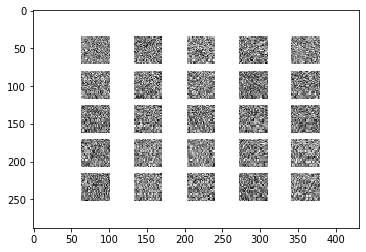

In [2]:
import matplotlib.image as mpimg

image = mpimg.imread("images/0.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()